# Bank of England Sentiment Analysis
## Employer Project
### Team 8 AnalytIQ, June 2nd, 2025
**Team Members**: Lalitha Vemuri, Christina Tsoulfa, Reka Bodo, Yann Hirsig, Louis Pang, Dr. Karin Agius Ferrante

## Content
1. Approach
2. Load the Data
4. Exploratory Sentiment Analysis & Natural Language Processing (NLP)
5. Exploratory Analysis for Correlation with Economic Indicators
8. Insights & Recommendations

## 1. Approach

The **Bank of England (BoE)**, the UK’s central bank and one of the world’s leading financial institutions, plays a pivotal role in maintaining economic and financial stability, and supporting the UK government’s economic policies. One of its key communication channels with the public and markets is through formal speeches delivered by its representatives. These speeches aim to offer guidance, manage expectations, and provide clarity in times of uncertainty.

However, the effectiveness and impact of these speeches on economic indicators and market behaviour are not fully understood. 

This project seeks to explore whether the sentiment and timing of BoE speeches hold analytical or predictive value, when compared with economic performance and key events.

### Main Business Questions
**Has the tone or sentiment of the BoE’s speeches evolved over time? If so, how?**<br>
**How do sentiments align with events like interest rate changes, policy reports, or major economic releases?**

**Sub-questions**

1.	Are there measurable correlations between speech sentiment and UK economic indicators such as inflation, GDP, employment rates and bond yields?
2. Does the change in sentiment change economic indicators or is the speech sentiment reactive to economic indicators?
3. Can speech sentiment trends be used to predict market reactions or economic outcomes?
4. What broader insights can be drawn to support data-informed communication strategies?

## 2. Load the Data

### 2.1. Import libraries

In [ ]:
# Install the necessary libraries.
# !pip install nltk
# !pip install vaderSentiment
# !pip install textblob
# !pip install pandas openpyxl
# !pip install transformers torch

In [ ]:
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('words')
# nltk.download('omw-1.4')

In [1]:
# General libraries
import numpy as np                             # Numerical operations and array handling.
import pandas as pd                            # Data manipulation and analysis.
import contractions                            # Expanding/contracting text contractions.
import re                                      # Regular expression operations on strings.
import os                                      # Interacting with the operating system and file handling.
import matplotlib.pyplot as plt                # Create visualisations.
from matplotlib.colors import rgb2hex          # Colour conversion in plots.
import seaborn as sns                          # Enhanced statistical data visualisations.
import math                                    # Mathematical functions and constants.
from IPython.display import display, Markdown  # Rich output in Jupyter.
from functools import reduce
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose   # Seasonality
import matplotlib.dates as mdates
import matplotlib.cm as cm

In [572]:
# Text and Sentiment Analysis 
from wordcloud import WordCloud                                       # Generating visual word frequency clouds from text.
import nltk                                                           # Natural language processing tasks.
from nltk import word_tokenize, pos_tag                               # Splitting text into words and tags with part of speech
from nltk import defaultdict                                          # Providing default values for nonexistent keys.
from nltk.probability import FreqDist                                 # Calculating frequency distribution of tokens.
from nltk.corpus import stopwords                                     # Providing list of common words to exclude from analysis.
from nltk.corpus import words
from nltk.corpus import wordnet as wn                                 # Lexical database for retrieving word relationships & meanings.
from nltk.stem import WordNetLemmatizer, PorterStemmer                # Reducing words to base or root form.
from nltk.probability import FreqDist
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer  # Assessing sentiment intensity in text.
from textblob import TextBlob                                         # API for text processing tasks including sentiment analysis.
import contractions                                                   # Expanding/contracting text contractions.
import re                                                             # Regular expression operations on strings.
import ast                                                            # If column contains string representations of lists
from collections import defaultdict  # Creating dictionaries that return default value for nonexistent keys.
from collections import Counter  # Importing Counter for counting hashable objects and efficiently tallying occurrences in an iterable.
from transformers import AutoTokenizer                                # FinBERT Model
from transformers import AutoModelForSequenceClassification           # FinBERT Model
import torch                                                          # FinBERT Model
import torch.nn.functional as F                                       # FinBERT Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
stop_words = set(stopwords.words('english'))

In [3]:
# Correlation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
import scipy.stats as stats

In [4]:
# Import warnings
import warnings
# Settings for the notebook.
warnings.filterwarnings("ignore")

In [5]:
# Set figure style for seaborn.
sns.set_theme(style='darkgrid')

### 2.2. Define functions

**2.2.a. Charts**

In [9]:
def clean_label(label):
    # If label is a Series, return its name.
    if isinstance(label, pd.Series):
        return label.name.replace('_', ' ').title() if label.name else ' '
    elif isinstance(label, str):
        return label.replace('_', ' ').title()
    return ' '

In [10]:
# Define function for scatterplot.
def generate_scatterplot(df, x_axis, y_axis, title, hue, save_path=None):

    # Set figure size & style for seaborn.
    sns.set_theme(style='darkgrid')
    sns.set(rc={'figure.figsize':(8, 6)})

    # Plot the scatterplot.
    sns.scatterplot(data=df, x=x_axis, y=y_axis, hue=hue, color='#0e1b2c')

    # Customize the plot.
    plt.title(title, fontsize=12, fontweight='bold')
    plt.xlabel(clean_label(x_axis), fontsize=10)
    plt.ylabel(clean_label(y_axis), fontsize=10)

    # Add legend ONLY if hue is not None.
    if hue is not None:
        plt.legend(title='Legend', fontsize=10, bbox_to_anchor=(1.05,1), loc='upper left')
    
    # Save the plot, if save_path is provided.
    if save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')

    # Display the chart.
    plt.tight_layout()
    plt.show()

In [11]:
# Define function to plot a lineplot.
def generate_lineplot(df, x_axis, y_axis, title, ylim=None, save_path=None, \
                      rotate_xticks=False):
    
    # Set figure size & style for seaborn.
    sns.set_theme(style='darkgrid')
    sns.set(rc={'figure.figsize':(14, 8)})
    
    # Ensure time column is in datetime format.
    df[x_axis] = pd.to_datetime(df[x_axis])
    
    # Sort DataFrame by the time column.
    df.sort_values(by=x_axis, inplace=True)
    
    # Plot the lineplot.
    sns.lineplot(data=df, x=x_axis, y=y_axis, label=clean_label(y_axis))
    
    # Customize the plot.
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(clean_label(x_axis), fontsize=14)
    plt.ylabel(clean_label(y_axis), fontsize=14)
    plt.legend(title='Legend', fontsize=12, bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tick_params(axis='both', labelsize=12)
    
    # Rotate x-tick labels by 45 degrees, if specified.
    if rotate_xticks:
        plt.xticks(rotation=45)
    
    # Set y-axis limits, if provided.
    if ylim:
        plt.ylim(ylim)

    # Save the plot, if save_path is provided.
    if save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')
    
    # Display the chart.
    plt.tight_layout()
    plt.show()

**2.2.b. NLP analysis**

In [13]:
# Preprocessing function
def preprocess_text(text):
    text = contractions.fix(text)  # Expand contractions i.e I'm not good goes to I am not good
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub('#', '', text)         # Remove hashtags
    text = re.sub(r'\W', ' ', text)      # Remove special characters
    text = text.lower()                  # Convert to lowercase
    #Below is to create a set of stop words from the NLTK library's predefined list but not is excluded.
    stop_words = set(stopwords.words('english')) - {'not'} 
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [14]:
# Define the tag map for POS tagging.
tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

# Lemmatise the tokens with correct POS tags.
lemma_function = WordNetLemmatizer()

# Lemmatisation function.
def lemmatize_tokens(tokens):
    #For each word in the token list, it lemmatizes the word with the correct part-of-speech
    lemmatized_tokens = [lemma_function.lemmatize(token, tag_map[tag[0]]) for token, tag in pos_tag(tokens)]
    return lemmatized_tokens

In [16]:
# VADER Sentiment Intensity Analyzer.
analyzer = SentimentIntensityAnalyzer()

# Define the function to compute and return sentiment scores.
def analyse_sentiment(text):
    return analyzer.polarity_scores(' '.join(text))

In [24]:
# Define function to label sentiments.
def get_sentiment_label(compound):
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [25]:
# Define a function to extract a polarity score using TextBlob.
def generate_polarity(comment):
    return TextBlob(comment).sentiment[0]

In [26]:
# Define a function to extract a subjectivity score using TextBlob.
def generate_subjectivity(comment):
    return TextBlob(comment).sentiment[1]

### 2.3. Import and review the data

**2.3.a. Import Bank of England Speeches**

In [35]:
# Load the CSV file as speeches.
speeches_original = pd.read_csv('/Users/kaferrante/Documents/Python/_Course4_Project/all_speeches.csv')

# View the data.
speeches_original.head()

reference    country        date                               title  \
0  r901128a_BOA  australia  1990-11-28   A Proper Role for Monetary Policy   
1  r911003a_BOA  australia  1991-10-03                                       
2  r920314a_BOA  australia  1992-03-14                                       
3  r920529a_BOA  australia  1992-05-29                                       
4  r920817a_BOA  australia  1992-08-17                                       

   author  is_gov                                               text  
0  fraser       0  They would no doubt argue that to have two obj...  
1  fraser       0  Today I wish to talk about real interest rates...  
2  fraser       0  I welcome this opportunity to talk about prosp...  
3  fraser       0  It is a pleasure to have this opportunity to a...  
4  fraser       0  As a long-time fan of Don Sanders, I am deligh...

In [36]:
# Explore data set.
speeches_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7721 entries, 0 to 7720
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   reference  7721 non-null   object
 1   country    7721 non-null   object
 2   date       7721 non-null   object
 3   title      7721 non-null   object
 4   author     7721 non-null   object
 5   is_gov     7721 non-null   int64 
 6   text       7721 non-null   object
dtypes: int64(1), object(6)
memory usage: 422.4+ KB


In [37]:
# Check for missing values.
speeches_original.isnull().sum()

reference    0
country      0
date         0
title        0
author       0
is_gov       0
text         0
dtype: int64

In [41]:
# Check for duplicates.
speeches_original.duplicated().sum()

0

In [43]:
# Review basic descriptive statistics.
speeches_original.describe()

is_gov
count  7721.000000
mean      0.347235
std       0.476122
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000

In [45]:
# View the countries.
speeches_original['country'].unique()

array(['australia', 'canada', 'euro area', 'japan', 'sweden',
       'switzerland', 'united kingdom', 'united states'], dtype=object)

In [47]:
# View the author.
speeches_original['author'].unique()

array(['fraser', 'macfarlane', 'lowe', 'stevens', 'no_info', 'ac',
       'thiessen', 'bonin', 'dodge', 'jenkins', 'kennedy', 'macklem',
       'duguay', 'longworth', 'carney', 'murray', 'lane', 'wolf',
       'boivin', 'cote', 'poloz', 'schembri', 'johnson', 'wilkins',
       'chilcott', 'mendes', 'patterson', 'murchison', 'leduc', 'dinis',
       'beaudry', 'gravelle', 'kozicki', 'rogers', 'morrow', 'lamfalussy',
       'duisenberg', 'vienna', 'london', 'tokyo', 'kong', 'bank',
       'schioppa', 'hamalainen', 'main', 'noyer', 'committee', 'solans',
       'francisco', 'istanbul', 'issing', 'hoogduin', 'bankwashington',
       'efma', 'brussels', 'forum', 'workshop', 'quiros', 'papademos',
       'gugerell', 'trichet', 'network', 'delivered', 'paramo',
       'strasbourg', 'rome', 'berlin', 'smaghi', 'sevilla', 'madrid',
       'stark', 'singapore', 'summit', 'washington', 'aires',
       'bratislava', 'ecb', 'constancio', 'posen', 'praet', 'draghi',
       'coeure', 'asmussen', 'mer

**2.3.b. Import Lexicon Sentiment based on BoE Wordlist**

In [50]:
# Load the Excel file of BoE sentiment labelled wordlist.
speeches = pd.read_csv('/Users/kaferrante/Documents/Python/_Course4_Project/speeches_sentiment.csv')

# View the data.
speeches.head()

reference    country        date                               title  \
0  r901128a_BOA  australia  1990-11-28   A Proper Role for Monetary Policy   
1  r911003a_BOA  australia  1991-10-03                                       
2  r920314a_BOA  australia  1992-03-14                                       
3  r920529a_BOA  australia  1992-05-29                                       
4  r920817a_BOA  australia  1992-08-17                                       

   author  is_gov                                               text  \
0  fraser       0  They would no doubt argue that to have two obj...   
1  fraser       0  Today I wish to talk about real interest rates...   
2  fraser       0  I welcome this opportunity to talk about prosp...   
3  fraser       0  It is a pleasure to have this opportunity to a...   
4  fraser       0  As a long-time fan of Don Sanders, I am deligh...   

                                           text_norm  \
0  they would no doubt argue that to have two obj...   
1  today i wish to talk about real interest rates...   
2  i welcome this opportunity to talk about prosp...   
3  it is a pleasure to have this opportunity to a...   
4  as a long-time fan of don sanders, i am deligh...   

                                        text_cleaned  \
0  would doubt argue two objectives like trying c...   
1  today wish talk real interest rates mainly his...   
2  welcome opportunity talk prospects banks austr...   
3  pleasure opportunity address influential gathe...   
4  long time fan sanders delighted participating ...   

                                      text_tokenised  ... positive  \
0  ['would', 'doubt', 'argue', 'two', 'objectives...  ...       58   
1  ['today', 'wish', 'talk', 'real', 'interest', ...  ...       28   
2  ['welcome', 'opportunity', 'talk', 'prospects'...  ...       67   
3  ['pleasure', 'opportunity', 'address', 'influe...  ...       56   
4  ['long', 'time', 'fan', 'sanders', 'delighted'...  ...       62   

  uncertainty  litigious  strong  weak  constraining  word_count_sentiment  \
0          32          5      10    15            13                   217   
1          35          2       3    16            12                   149   
2          33          8      11    16            13                   191   
3          43          6       7    20             8                   202   
4          42          6      12    27            13                   234   

   sentiment_lexicon  sentiment_lexicon_simple  sentiment_lexicon_weighted  
0                -26                 -0.119816                    0.112442  
1                -25                 -0.167785                    0.014094  
2                 24                  0.125654                    0.421466  
3                 -6                 -0.029703                    0.227228  
4                -10                 -0.042735                    0.227350  

[5 rows x 25 columns]

In [51]:
# Explore data set.
speeches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7721 entries, 0 to 7720
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   reference                   7721 non-null   object 
 1   country                     7721 non-null   object 
 2   date                        7721 non-null   object 
 3   title                       7721 non-null   object 
 4   author                      7721 non-null   object 
 5   is_gov                      7721 non-null   int64  
 6   text                        7721 non-null   object 
 7   text_norm                   7721 non-null   object 
 8   text_cleaned                7721 non-null   object 
 9   text_tokenised              7721 non-null   object 
 10  text_lemmatised             7721 non-null   object 
 11  text_lemmatised_str         7721 non-null   object 
 12  word_count_text             7721 non-null   int64  
 13  word_count_text_cleaned     7721 

In [52]:
# Check for missing values.
speeches.isnull().sum()

reference                     0
country                       0
date                          0
title                         0
author                        0
is_gov                        0
text                          0
text_norm                     0
text_cleaned                  0
text_tokenised                0
text_lemmatised               0
text_lemmatised_str           0
word_count_text               0
word_count_text_cleaned       0
negative                      0
positive                      0
uncertainty                   0
litigious                     0
strong                        0
weak                          0
constraining                  0
word_count_sentiment          0
sentiment_lexicon             0
sentiment_lexicon_simple      1
sentiment_lexicon_weighted    1
dtype: int64

In [53]:
# Check for duplicates.
speeches.duplicated().sum()

0

In [54]:
# Review basic descriptive statistics.
speeches.describe()

is_gov  word_count_text  word_count_text_cleaned     negative  \
count  7721.000000      7721.000000              7721.000000  7721.000000   
mean      0.347235      3113.002072              1776.809222    68.278073   
std       0.476122      2047.797030              1174.241676    55.675494   
min       0.000000        16.000000                18.000000     0.000000   
25%       0.000000      1906.000000              1081.000000    31.000000   
50%       0.000000      2904.000000              1656.000000    57.000000   
75%       1.000000      3879.000000              2219.000000    91.000000   
max       1.000000     37522.000000             23119.000000  1251.000000   

          positive  uncertainty    litigious       strong         weak  \
count  7721.000000  7721.000000  7721.000000  7721.000000  7721.000000   
mean     55.249968    45.351768    11.074343     5.342831    18.962958   
std      37.151788    43.173626    15.827917     4.827564    18.883414   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      31.000000    19.000000     3.000000     2.000000     8.000000   
50%      49.000000    35.000000     6.000000     4.000000    15.000000   
75%      71.000000    60.000000    14.000000     7.000000    25.000000   
max    1042.000000   893.000000   351.000000    70.000000   422.000000   

       constraining  word_count_sentiment  sentiment_lexicon  \
count   7721.000000           7721.000000        7721.000000   
mean      11.482709            215.742650         -13.028105   
std       12.094693            154.677042          44.671586   
min        0.000000              0.000000        -962.000000   
25%        5.000000            120.000000         -31.000000   
50%        9.000000            195.000000          -6.000000   
75%       15.000000            277.000000          10.000000   
max      262.000000           3206.000000         486.000000   

       sentiment_lexicon_simple  sentiment_lexicon_weighted  
count               7720.000000                 7720.000000  
mean                  -0.023593                    0.201153  
std                    0.179111                    0.233669  
min                   -0.782609                   -0.833333  
25%                   -0.146341                    0.039150  
50%                   -0.039832                    0.179004  
75%                    0.082904                    0.341438  
max                    1.000000                    1.500000

In [55]:
# Check the number of unique values.
speeches.nunique()

reference                     7721
country                          8
date                          4410
title                         6218
author                         325
is_gov                           2
text                          7692
text_norm                     7692
text_cleaned                  7691
text_tokenised                7691
text_lemmatised               7691
text_lemmatised_str           7691
word_count_text               4183
word_count_text_cleaned       3074
negative                       293
positive                       225
uncertainty                    245
litigious                      120
strong                          42
weak                           126
constraining                    98
word_count_sentiment           681
sentiment_lexicon              301
sentiment_lexicon_simple      5426
sentiment_lexicon_weighted    7276
dtype: int64

In [56]:
# Create a normalized version of the 'text' column
speeches['text_norm'] = speeches['text'].str.strip().str.lower()

# Find duplicate 'text_norm' entries
duplicate_mask = speeches['text_norm'].duplicated(keep=False)

# Extract all duplicates based on normalized text
duplicates = speeches[duplicate_mask]

In [57]:
# Show the 'text' of these duplicates
duplicates

reference         country        date  \
564    r101026a_BOC          canada  2010-10-26   
565    r101027a_BOC          canada  2010-10-27   
610    r120424a_BOC          canada  2012-04-24   
611    r120425a_BOC          canada  2012-04-25   
624    r121030a_BOC          canada  2012-10-30   
625    r121031a_BOC          canada  2012-10-31   
668    r140429a_BOC          canada  2014-04-29   
669    r140430a_BOC          canada  2014-04-30   
1182   r020121a_ECB       euro area  2002-01-21   
1186   r020221a_ECB       euro area  2002-02-21   
2824   r180507a_ECB       euro area  2018-05-07   
2829   r180514c_ECB       euro area  2018-05-14   
3266   r981210a_BOJ           japan  1998-12-10   
3267   r981211a_BOJ           japan  1998-12-11   
3422   r071101a_BOJ           japan  2007-11-01   
3423   r071102a_BOJ           japan  2007-11-02   
3506   r100413a_BOJ           japan  2010-04-13   
3507   r100420a_BOJ           japan  2010-04-20   
3744   r150610a_BOJ           japan  2015-06-10   
3746   r150616a_BOJ           japan  2015-06-16   
3803   r161102a_BOJ           japan  2016-11-02   
3808   r161122a_BOJ           japan  2016-11-22   
3886   r181206a_BOJ           japan  2018-12-06   
3887   r181207a_BOJ           japan  2018-12-07   
3922   r191119a_BOJ           japan  2019-11-19   
3926   r191129a_BOJ           japan  2019-11-29   
5203   r061024a_BOE  united kingdom  2006-10-24   
5658   r150226a_BOE  united kingdom  2015-02-26   
5952   r190517a_BOE  united kingdom  2019-05-17   
6035   r200903a_BOE  united kingdom  2020-09-03   
6038   r200909a_BOE  united kingdom  2020-09-09   
6081   r210421a_BOE  united kingdom  2021-04-21   
6082   r210429b_BOE  united kingdom  2021-04-29   
6095   r210601a_BOE  united kingdom  2021-06-01   
6099   r210617a_BOE  united kingdom  2021-06-17   
6115   r211020a_BOE  united kingdom  2021-10-20   
6116   r211103a_BOE  united kingdom  2021-11-03   
6120   r211203a_BOE  united kingdom  2021-12-03   
6135   r220428a_BOE  united kingdom  2022-04-28   
6142   r220526a_BOE  united kingdom  2022-05-26   
6598  r040103a_FOMC   united states  2004-01-03   
6603  r040114a_FOMC   united states  2004-01-14   
6611  r040225b_FOMC   united states  2004-02-25   
6612  r040226a_FOMC   united states  2004-02-26   
6626  r040331a_FOMC   united states  2004-03-31   
6645  r040514a_FOMC   united states  2004-05-14   
6658  r040621a_FOMC   united states  2004-06-21   
6697  r050112a_FOMC   united states  2005-01-12   
6699  r050119a_FOMC   united states  2005-01-19   
6700  r050127a_FOMC   united states  2005-01-27   
6705  r050224a_FOMC   united states  2005-02-24   
6758  r051012b_FOMC   united states  2005-10-12   
6761  r051013a_FOMC   united states  2005-10-13   
6824  r060615a_FOMC   united states  2006-06-15   
6826  r060616b_FOMC   united states  2006-06-16   
6875  r070426a_FOMC   united states  2007-04-26   
6891  r070623a_FOMC   united states  2007-06-23   

                                                  title     author  is_gov  \
564   Opening Statement before the House of Commons ...     carney       1   
565   Opening Statement before the Standing Senate C...     carney       1   
610   Opening Statement before the House of Commons ...     carney       1   
611   Opening Statement before the Senate Standing C...     carney       1   
624   Opening Statement before the House of Commons ...     carney       1   
625   Opening Statement before the Standing Senate C...     carney       1   
668   Opening Statement before the House of Commons ...      poloz       1   
669   Opening Statement before the Senate Standing C...      poloz       1   
1182          Securities and banking: bridges and walls    no_info       0   
1186          Securities and banking: bridges and walls   schioppa       0   
2824             Economic developments in the euro area      praet       0   
2829             Economic developments in the euro area      praet       0   
3266  Statement by Masaru Hayami, Gov

In [58]:
# Export to csv
# duplicates.to_csv('/Users/kaferrante/Documents/Python/_Course4_Project/duplicates_full_rows.csv', index=False)

**2.3.c. Import BoE Wordlist**

In [63]:
# Load the Excel file of BoE sentiment labelled wordlist.
sentiment_lexicon = pd.read_excel('/Users/kaferrante/Documents/Python/_Course4_Project/sentiment_labelled_wordlist.xlsx')

# View the data.
sentiment_lexicon.head()

Word  Negative  Positive  Uncertainty  Litigious  Strong  Weak  \
0       ABANDON         1         0            0          0       0     0   
1     ABANDONED         1         0            0          0       0     0   
2    ABANDONING         1         0            0          0       0     0   
3   ABANDONMENT         1         0            0          0       0     0   
4  ABANDONMENTS         1         0            0          0       0     0   

   Constraining  
0             0  
1             0  
2             0  
3             0  
4             0

In [64]:
# Explore data set.
sentiment_lexicon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3880 entries, 0 to 3879
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Word          3880 non-null   object
 1   Negative      3880 non-null   int64 
 2   Positive      3880 non-null   int64 
 3   Uncertainty   3880 non-null   int64 
 4   Litigious     3880 non-null   int64 
 5   Strong        3880 non-null   int64 
 6   Weak          3880 non-null   int64 
 7   Constraining  3880 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 242.6+ KB


In [65]:
# Check for missing values.
sentiment_lexicon.isnull().sum()

Word            0
Negative        0
Positive        0
Uncertainty     0
Litigious       0
Strong          0
Weak            0
Constraining    0
dtype: int64

In [66]:
# Review basic descriptive statistics.
sentiment_lexicon.describe()

Negative     Positive  Uncertainty    Litigious       Strong  \
count  3880.000000  3880.000000  3880.000000  3880.000000  3880.000000   
mean      0.606959     0.092268     0.076546     0.233247     0.004897   
std       0.488489     0.289441     0.265905     0.422953     0.069815   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       1.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

              Weak  Constraining  
count  3880.000000   3880.000000  
mean      0.006959      0.047423  
std       0.083139      0.212569  
min       0.000000      0.000000  
25%       0.000000      0.000000  
50%       0.000000      0.000000  
75%       0.000000      0.000000  
max       1.000000      1.000000

**2.3.d. Import UK Economic Indicators (1998-2025)**

In [70]:
# Load the Excel file for UK Economic Indicators
uk_economic_indicators = pd.read_excel('/Users/kaferrante/Documents/Python/_Course4_Project/Consolidated_Eco_KPI _V3.xlsx')

# View the data.
uk_economic_indicators.head()

year  month year_month  uk_inflation_rate_CPIH  uk_unemployment_rate  \
0  1998      4    1998-04                   1.815                   6.3   
1  1998      5    1998-05                   2.039                   6.3   
2  1998      6    1998-06                   1.675                   6.3   
3  1998      7    1998-07                   1.443                   6.3   
4  1998      8    1998-08                   1.327                   6.2   

   uk_gdp_growth  uk_interest_rate  uk_consumer_confidence  gbp_usd_fx  \
0            0.6              7.25                     1.1    1.673270   
1            0.6              7.25                     1.2    1.636589   
2            0.6              7.50                    -1.3    1.650718   
3            0.3              7.50                    -4.3    1.643657   
4            0.3              7.50                    -6.5    1.631950   

      ftse_250  gilts_short   gilts_medium   gilts_long   \
0  5554.720972          5.91           5.70         5.71   
1  5799.256322          5.82           5.57         5.55   
2  5739.277233          6.17           5.64         5.43   
3  5595.919582          6.06           5.57         5.38   
4  5173.355054          5.52           5.19         5.11   

   uk_credit_growth_no_cc  uk_credit_growth_only_cc  \
0                    14.1                      24.7   
1                    14.4                      24.5   
2                    13.9                      25.5   
3                    14.6                      25.6   
4                    14.6                      26.1   

   avg_price_all_property_types  
0                         64258  
1                         64258  
2                         64258  
3                         67057  
4                         67057

In [71]:
# Explore data set.
uk_economic_indicators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321 entries, 0 to 320
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   year                          321 non-null    int64  
 1   month                         321 non-null    int64  
 2   year_month                    321 non-null    object 
 3   uk_inflation_rate_CPIH        321 non-null    float64
 4   uk_unemployment_rate          321 non-null    float64
 5   uk_gdp_growth                 321 non-null    float64
 6   uk_interest_rate              321 non-null    float64
 7   uk_consumer_confidence        321 non-null    float64
 8   gbp_usd_fx                    321 non-null    float64
 9   ftse_250                      321 non-null    float64
 10  gilts_short                   321 non-null    float64
 11  gilts_medium                  321 non-null    float64
 12  gilts_long                    321 non-null    float64
 13  uk_cr

In [72]:
# Check for missing values.
uk_economic_indicators.isnull().sum()

year                            0
month                           0
year_month                      0
uk_inflation_rate_CPIH          0
uk_unemployment_rate            0
uk_gdp_growth                   0
uk_interest_rate                0
uk_consumer_confidence          0
gbp_usd_fx                      0
ftse_250                        0
gilts_short                     0
gilts_medium                    0
gilts_long                      0
uk_credit_growth_no_cc          0
uk_credit_growth_only_cc        0
avg_price_all_property_types    0
dtype: int64

In [73]:
# View column types.
uk_economic_indicators.dtypes

year                              int64
month                             int64
year_month                       object
uk_inflation_rate_CPIH          float64
uk_unemployment_rate            float64
uk_gdp_growth                   float64
uk_interest_rate                float64
uk_consumer_confidence          float64
gbp_usd_fx                      float64
ftse_250                        float64
gilts_short                     float64
gilts_medium                    float64
gilts_long                      float64
uk_credit_growth_no_cc          float64
uk_credit_growth_only_cc        float64
avg_price_all_property_types      int64
dtype: object

### 2.4. Date Transformation

**Speeches**

In [80]:
# Determine the date format for speeches.
speeches.date.head()

0    1990-11-28
1    1991-10-03
2    1992-03-14
3    1992-05-29
4    1992-08-17
Name: date, dtype: object

In [81]:
# Change date format from 'object' to 'datetime64' and display in a new column
speeches['date_format'] = speeches['date'].astype('datetime64[ns]')

In [90]:
# Add a new column for year and month
speeches['year_month'] = pd.to_datetime(speeches['date_format']).dt.to_period('M')

In [94]:
# Add a new column for year only
speeches['year'] = pd.to_datetime(speeches.date).dt.year

In [96]:
# Add a column for year_month in date format
speeches['year_month_dt'] = speeches['year_month'].dt.to_timestamp()

In [98]:
# View the DataFrame.
speeches.head()

reference    country        date                               title  \
0  r901128a_BOA  australia  1990-11-28   A Proper Role for Monetary Policy   
1  r911003a_BOA  australia  1991-10-03                                       
2  r920314a_BOA  australia  1992-03-14                                       
3  r920529a_BOA  australia  1992-05-29                                       
4  r920817a_BOA  australia  1992-08-17                                       

   author  is_gov                                               text  \
0  fraser       0  They would no doubt argue that to have two obj...   
1  fraser       0  Today I wish to talk about real interest rates...   
2  fraser       0  I welcome this opportunity to talk about prosp...   
3  fraser       0  It is a pleasure to have this opportunity to a...   
4  fraser       0  As a long-time fan of Don Sanders, I am deligh...   

                                           text_norm  \
0  they would no doubt argue that to have two obj...   
1  today i wish to talk about real interest rates...   
2  i welcome this opportunity to talk about prosp...   
3  it is a pleasure to have this opportunity to a...   
4  as a long-time fan of don sanders, i am deligh...   

                                        text_cleaned  \
0  would doubt argue two objectives like trying c...   
1  today wish talk real interest rates mainly his...   
2  welcome opportunity talk prospects banks austr...   
3  pleasure opportunity address influential gathe...   
4  long time fan sanders delighted participating ...   

                                      text_tokenised  ... weak constraining  \
0  ['would', 'doubt', 'argue', 'two', 'objectives...  ...   15           13   
1  ['today', 'wish', 'talk', 'real', 'interest', ...  ...   16           12   
2  ['welcome', 'opportunity', 'talk', 'prospects'...  ...   16           13   
3  ['pleasure', 'opportunity', 'address', 'influe...  ...   20            8   
4  ['long', 'time', 'fan', 'sanders', 'delighted'...  ...   27           13   

   word_count_sentiment  sentiment_lexicon  sentiment_lexicon_simple  \
0                   217                -26                 -0.119816   
1                   149                -25                 -0.167785   
2                   191                 24                  0.125654   
3                   202                 -6                 -0.029703   
4                   234                -10                 -0.042735   

   sentiment_lexicon_weighted  date_format  year_month  year  year_month_dt  
0                    0.112442   1990-11-28     1990-11  1990     1990-11-01  
1                    0.014094   1991-10-03     1991-10  1991     1991-10-01  
2                    0.421466   1992-03-14     1992-03  1992     1992-03-01  
3                    0.227228   1992-05-29     1992-05  1992     1992-05-01  
4                    0.227350   1992-08-17     1992-08  1992     1992-08-01  

[5 rows x 29 columns]

In [100]:
# View column types.
speeches.dtypes

reference                             object
country                               object
date                                  object
title                                 object
author                                object
is_gov                                 int64
text                                  object
text_norm                             object
text_cleaned                          object
text_tokenised                        object
text_lemmatised                       object
text_lemmatised_str                   object
word_count_text                        int64
word_count_text_cleaned                int64
negative                               int64
positive                               int64
uncertainty                            int64
litigious                              int64
strong                                 int64
weak                                   int64
constraining                           int64
word_count_sentiment                   int64
sentiment_

**Indicators**

In [104]:
# Add a new column for year and month.
uk_economic_indicators['year_month'] = pd.to_datetime(uk_economic_indicators['year_month']).dt.to_period('M')

In [106]:
# View the DataFrame.
uk_economic_indicators.head()

year  month year_month  uk_inflation_rate_CPIH  uk_unemployment_rate  \
0  1998      4    1998-04                   1.815                   6.3   
1  1998      5    1998-05                   2.039                   6.3   
2  1998      6    1998-06                   1.675                   6.3   
3  1998      7    1998-07                   1.443                   6.3   
4  1998      8    1998-08                   1.327                   6.2   

   uk_gdp_growth  uk_interest_rate  uk_consumer_confidence  gbp_usd_fx  \
0            0.6              7.25                     1.1    1.673270   
1            0.6              7.25                     1.2    1.636589   
2            0.6              7.50                    -1.3    1.650718   
3            0.3              7.50                    -4.3    1.643657   
4            0.3              7.50                    -6.5    1.631950   

      ftse_250  gilts_short   gilts_medium   gilts_long   \
0  5554.720972          5.91           5.70         5.71   
1  5799.256322          5.82           5.57         5.55   
2  5739.277233          6.17           5.64         5.43   
3  5595.919582          6.06           5.57         5.38   
4  5173.355054          5.52           5.19         5.11   

   uk_credit_growth_no_cc  uk_credit_growth_only_cc  \
0                    14.1                      24.7   
1                    14.4                      24.5   
2                    13.9                      25.5   
3                    14.6                      25.6   
4                    14.6                      26.1   

   avg_price_all_property_types  
0                         64258  
1                         64258  
2                         64258  
3                         67057  
4                         67057

In [108]:
# View column types.
uk_economic_indicators.dtypes

year                                int64
month                               int64
year_month                      period[M]
uk_inflation_rate_CPIH            float64
uk_unemployment_rate              float64
uk_gdp_growth                     float64
uk_interest_rate                  float64
uk_consumer_confidence            float64
gbp_usd_fx                        float64
ftse_250                          float64
gilts_short                       float64
gilts_medium                      float64
gilts_long                        float64
uk_credit_growth_no_cc            float64
uk_credit_growth_only_cc          float64
avg_price_all_property_types        int64
dtype: object

### 2.5. Data Correction

**2.5.a Author 'Edward George' wrongly not stated as governor**

In [113]:
# Speeches given by Edward George are wrongly not stated as is_gov
def correct_is_gov_column(speeches_df: pd.DataFrame):
    # Make sure date is datetime first
    speeches['date'] = pd.to_datetime(speeches['date'], errors='coerce')
    
    # Apply correction
    condition = (
        (speeches['author'].str.lower() == 'george') &
        (speeches['date'].dt.year > 1993) &
        (speeches['date'].dt.year < 2004)
    )
    speeches.loc[condition, 'is_gov'] = 1  # 1 means Governor
    
    return speeches

# Correct the is_gov column
speeches = correct_is_gov_column(speeches)

# View the DataFrame
display(speeches[speeches['author'].str.lower() == 'george'].head())

reference         country       date              title  author  \
4961  r980915a_BOE  united kingdom 1998-09-15             Speech  george   
4962  r981021b_BOE  united kingdom 1998-10-21  Britain in Europe  george   
4966  r981119a_BOE  united kingdom 1998-11-19             Speech  george   
4969  r990112a_BOE  united kingdom 1999-01-12             Speech  george   
4970  r990118a_BOE  united kingdom 1999-01-18             Speech  george   

      is_gov                                               text  \
4961       1  Thank you, Chairman. I'm actually very pleased...   
4962       1  It's a great pleasure to be here in the beauti...   
4966       1  Let me put some of the recent newspaper headli...   
4969       1  I am only too well aware of the pressure curre...   
4970       1  It would be a masterly understatement to descr...   

                                              text_norm  \
4961  thank you, chairman. i'm actually very pleased...   
4962  it's a great pleasure to be here in the beauti...   
4966  let me put some of the recent newspaper headli...   
4969  i am only too well aware of the pressure curre...   
4970  it would be a masterly understatement to descr...   

                                           text_cleaned  \
4961  thank chairman actually pleased opportunity re...   
4962  great pleasure beautiful city bruges honoured ...   
4966  let put recent newspaper headlines alongside f...   
4969  well aware pressure currently facing large par...   
4970  would masterly understatement describe past tw...   

                                         text_tokenised  ... weak  \
4961  ['thank', 'chairman', 'actually', 'pleased', '...  ...   16   
4962  ['great', 'pleasure', 'beautiful', 'city', 'br...  ...   28   
4966  ['let', 'put', 'recent', 'newspaper', 'headlin...  ...   14   
4969  ['well', 'aware', 'pressure', 'currently', 'fa...  ...   20   
4970  ['would', 'masterly', 'understatement', 'descr...  ...   11   

     constraining  word_count_sentiment  sentiment_lexicon  \
4961            2                   160                -23   
4962           17                   280                  8   
4966            3                   162                -30   
4969            3                   195                -38   
4970            9                   168                -10   

      sentiment_lexicon_simple  sentiment_lexicon_weighted  date_format  \
4961                 -0.143750                    0.179375   1998-09-15   
4962                  0.028571                    0.291071   1998-10-21   
4966                 -0.185185                    0.069136   1998-11-19   
4969                 -0.194872                    0.022051   1999-01-12   
4970                 -0.059524                    0.149405   1999-01-18   

      year_month  year  year_month_dt  
4961     1998-09  1998     1998-09-01  
4962     1998-10  1998     1998-10-01  
4966     1998-11  1998     1998-11-01  
4969     1999-01  1999     1999-01-01  
4970     1999-01  1999     1999-01-01  

[5 rows x 29 columns]

**2.5.b Remove Date Outlier**

In [117]:
# Check for earliest and latest dates
min_year = speeches['year'].min()
max_year = speeches['year'].max()

print(f"Minimum year: {min_year}")
print(f"Maximum year: {max_year}")

Minimum year: 1900
Maximum year: 2022


In [119]:
# Filter for speeches in year 1900
speeches_1900 = speeches[speeches['year'] == 1900]

# View the DataFrame
speeches_1900

reference country       date                          title  \
4010  r000101a_SRB  sweden 1900-01-01  Swedish economy in transition   

         author  is_gov                                               text  \
4010  backstrom       1  Thank you for inviting me to talk with you thi...   

                                              text_norm  \
4010  thank you for inviting me to talk with you thi...   

                                           text_cleaned  \
4010  thank inviting talk evening swedish economy mo...   

                                         text_tokenised  ... weak  \
4010  ['thank', 'inviting', 'talk', 'evening', 'swed...  ...   32   

     constraining  word_count_sentiment  sentiment_lexicon  \
4010            5                   260                 41   

      sentiment_lexicon_simple  sentiment_lexicon_weighted  date_format  \
4010                  0.157692                    0.491923   1900-01-01   

      year_month  year  year_month_dt  
4010     1900-01  1900     1900-01-01  

[1 rows x 29 columns]

In [121]:
# Remove the specific row with index 4010, as the date must be wrongly entered, as dates on start in 1990
# Backstrom was governor of the Bank of Sweden from 1994 to 2002.
speeches = speeches.drop(4010)

In [123]:
# Check for earliest and latest dates
min_year = speeches['year'].min()
max_year = speeches['year'].max()

print(f"Minimum year: {min_year}")
print(f"Maximum year: {max_year}")

Minimum year: 1990
Maximum year: 2022


**2.5.c. Standardise Scores**

In [126]:
# Calculate mean and std
mean_score_simple = speeches['sentiment_lexicon_simple'].mean()
std_score_simple = speeches['sentiment_lexicon_simple'].std()

# Standardize
speeches['sentiment_lexicon_simple_std'] = (speeches['sentiment_lexicon_simple'] - mean_score_simple) / std_score_simple

In [128]:

# Calculate mean and std
mean_score_weighted = speeches['sentiment_lexicon_weighted'].mean()
std_score_weighted = speeches['sentiment_lexicon_weighted'].std()

# Standardize
speeches['sentiment_lexicon_weighted_std'] = (speeches['sentiment_lexicon_weighted'] - mean_score_weighted) / std_score_weighted

In [130]:
# View the DataFrame
speeches.head()

reference    country       date                               title  \
0  r901128a_BOA  australia 1990-11-28   A Proper Role for Monetary Policy   
1  r911003a_BOA  australia 1991-10-03                                       
2  r920314a_BOA  australia 1992-03-14                                       
3  r920529a_BOA  australia 1992-05-29                                       
4  r920817a_BOA  australia 1992-08-17                                       

   author  is_gov                                               text  \
0  fraser       0  They would no doubt argue that to have two obj...   
1  fraser       0  Today I wish to talk about real interest rates...   
2  fraser       0  I welcome this opportunity to talk about prosp...   
3  fraser       0  It is a pleasure to have this opportunity to a...   
4  fraser       0  As a long-time fan of Don Sanders, I am deligh...   

                                           text_norm  \
0  they would no doubt argue that to have two obj...   
1  today i wish to talk about real interest rates...   
2  i welcome this opportunity to talk about prosp...   
3  it is a pleasure to have this opportunity to a...   
4  as a long-time fan of don sanders, i am deligh...   

                                        text_cleaned  \
0  would doubt argue two objectives like trying c...   
1  today wish talk real interest rates mainly his...   
2  welcome opportunity talk prospects banks austr...   
3  pleasure opportunity address influential gathe...   
4  long time fan sanders delighted participating ...   

                                      text_tokenised  ...  \
0  ['would', 'doubt', 'argue', 'two', 'objectives...  ...   
1  ['today', 'wish', 'talk', 'real', 'interest', ...  ...   
2  ['welcome', 'opportunity', 'talk', 'prospects'...  ...   
3  ['pleasure', 'opportunity', 'address', 'influe...  ...   
4  ['long', 'time', 'fan', 'sanders', 'delighted'...  ...   

  word_count_sentiment sentiment_lexicon  sentiment_lexicon_simple  \
0                  217               -26                 -0.119816   
1                  149               -25                 -0.167785   
2                  191                24                  0.125654   
3                  202                -6                 -0.029703   
4                  234               -10                 -0.042735   

   sentiment_lexicon_weighted  date_format  year_month  year  year_month_dt  \
0                    0.112442   1990-11-28     1990-11  1990     1990-11-01   
1                    0.014094   1991-10-03     1991-10  1991     1991-10-01   
2                    0.421466   1992-03-14     1992-03  1992     1992-03-01   
3                    0.227228   1992-05-29     1992-05  1992     1992-05-01   
4                    0.227350   1992-08-17     1992-08  1992     1992-08-01   

   sentiment_lexicon_simple_std  sentiment_lexicon_weighted_std  
0                     -0.537091                       -0.379494  
1                     -0.804912                       -0.800397  
2                      0.833403                        0.943040  
3                     -0.033979                        0.111755  
4                     -0.106739                        0.112280  

[5 rows x 31 columns]

In [132]:
speeches.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7720 entries, 0 to 7720
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   reference                       7720 non-null   object        
 1   country                         7720 non-null   object        
 2   date                            7720 non-null   datetime64[ns]
 3   title                           7720 non-null   object        
 4   author                          7720 non-null   object        
 5   is_gov                          7720 non-null   int64         
 6   text                            7720 non-null   object        
 7   text_norm                       7720 non-null   object        
 8   text_cleaned                    7720 non-null   object        
 9   text_tokenised                  7720 non-null   object        
 10  text_lemmatised                 7720 non-null   object        
 11  text_lemm

**2.5.d Remove rows with sentiment scores**

In [135]:
# Find the row that is missing the sentiment score
row_missing_score = speeches[speeches['sentiment_lexicon_weighted_std'].isnull()]

# View the row
row_missing_score

reference country       date  \
795  r181025a_BOC  canada 2018-10-25   

                                                 title   author  is_gov  \
795  Money for Nothing? A Central Banker’s Take on ...  wilkins       0   

                                                  text  \
795  I - a FI - b FI - n bankofcanada.ca bankofcana...   

                                             text_norm  \
795  i - a fi - b fi - n bankofcanada.ca bankofcana...   

                                          text_cleaned  \
795  fi b fi n bankofcanada ca bankofcanada ca bank...   

                                        text_tokenised  ...  \
795  ['fi', 'b', 'fi', 'n', 'bankofcanada', 'ca', '...  ...   

    word_count_sentiment sentiment_lexicon  sentiment_lexicon_simple  \
795                    0                 0                       NaN   

     sentiment_lexicon_weighted  date_format  year_month  year  year_month_dt  \
795                         NaN   2018-10-25     2018-10  2018     2018-10-01   

     sentiment_lexicon_simple_std  sentiment_lexicon_weighted_std  
795                           NaN                             NaN  

[1 rows x 31 columns]

In [137]:
speeches = speeches.drop(index=795)

In [139]:
speeches.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7719 entries, 0 to 7720
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   reference                       7719 non-null   object        
 1   country                         7719 non-null   object        
 2   date                            7719 non-null   datetime64[ns]
 3   title                           7719 non-null   object        
 4   author                          7719 non-null   object        
 5   is_gov                          7719 non-null   int64         
 6   text                            7719 non-null   object        
 7   text_norm                       7719 non-null   object        
 8   text_cleaned                    7719 non-null   object        
 9   text_tokenised                  7719 non-null   object        
 10  text_lemmatised                 7719 non-null   object        
 11  text_lemm

### 2.6. Review of Economic Events

### 2000s
- **2003 Introduction of the BoE Inflation Target**: BoE formalised its inflation targeting policy, focusing on controlling inflation through monetary policy
- **2005 London Bombings**: economic impact included effects on the tourism and hospitality sectors
- **2008 Global Financial Crisis**: UK’s economy entered a recession, banks faced collapse, and extensive government interventions were implemented.

### 2010s
- **2010 Austerity Measures**: UK government, under David Cameron, implemented austerity policies to reduce budget deficits post-2008 crisis.
- **2016 Brexit Referendum**: UK voted to leave the EU, causing significant economic uncertainty, currency depreciation, and market volatility.
- **2017 Post-Brexit Currency Shock**: The pound fell sharply after the Brexit vote, increasing inflation and impacting consumer prices.
- **2018-2020 Economic Growth and Challenges**: UK faced slow growth, investment uncertainties, and the beginning of the COVID-19 pandemic impact.

### 2020s
- **2020 COVID-19 Pandemic**: Massive economic disruption worldwide, with the UK-government introducing support measures like the furlough scheme and emergency loans. GDP contracted by around 9.9% in 2020.
- **2021-2022 Post-Pandemic Recovery**: Efforts to recover growth, inflation concerns, labor shortages, and supply chain disruptions.
- **2021-2022 Inflation Surge**: Rising inflation due to supply chain bottlenecks, energy prices, and post-pandemic demand.
- **2021-2022 Energy Price Shock**: Rising energy costs affected households and industries.
- **2022 Interest Rate Hikes**: BoE increased interest rates to curb inflation.

## 3. Exploratory Analysis

### 3.1. Prepare the DataFrames

**3.1.a. All countries**

In [142]:
# Review columns in speeches DataFrame
speeches.columns

Index(['reference', 'country', 'date', 'title', 'author', 'is_gov', 'text',
       'text_norm', 'text_cleaned', 'text_tokenised', 'text_lemmatised',
       'text_lemmatised_str', 'word_count_text', 'word_count_text_cleaned',
       'negative', 'positive', 'uncertainty', 'litigious', 'strong', 'weak',
       'constraining', 'word_count_sentiment', 'sentiment_lexicon',
       'sentiment_lexicon_simple', 'sentiment_lexicon_weighted', 'date_format',
       'year_month', 'year', 'year_month_dt', 'sentiment_lexicon_simple_std',
       'sentiment_lexicon_weighted_std'],
      dtype='object')

In [144]:
# Remove unnecessary columns
speeches_short = speeches[['reference', 'country', 'date_format', 'year_month', 'year',
       'year_month_dt', 'title', 'author', 'is_gov', 'text', 'text_lemmatised',
       'text_lemmatised_str', 'word_count_text', 'word_count_text_cleaned',
       'sentiment_lexicon_simple', 'sentiment_lexicon_simple_std', 'sentiment_lexicon_weighted', 
       'sentiment_lexicon_weighted_std']]

# View the DataFrame
speeches_short.head()

reference    country date_format year_month  year year_month_dt  \
0  r901128a_BOA  australia  1990-11-28    1990-11  1990    1990-11-01   
1  r911003a_BOA  australia  1991-10-03    1991-10  1991    1991-10-01   
2  r920314a_BOA  australia  1992-03-14    1992-03  1992    1992-03-01   
3  r920529a_BOA  australia  1992-05-29    1992-05  1992    1992-05-01   
4  r920817a_BOA  australia  1992-08-17    1992-08  1992    1992-08-01   

                                title  author  is_gov  \
0   A Proper Role for Monetary Policy  fraser       0   
1                                      fraser       0   
2                                      fraser       0   
3                                      fraser       0   
4                                      fraser       0   

                                                text  \
0  They would no doubt argue that to have two obj...   
1  Today I wish to talk about real interest rates...   
2  I welcome this opportunity to talk about prosp...   
3  It is a pleasure to have this opportunity to a...   
4  As a long-time fan of Don Sanders, I am deligh...   

                                     text_lemmatised  \
0  ['would', 'doubt', 'argue', 'two', 'objective'...   
1  ['today', 'wish', 'talk', 'real', 'interest', ...   
2  ['welcome', 'opportunity', 'talk', 'prospect',...   
3  ['pleasure', 'opportunity', 'address', 'influe...   
4  ['long', 'time', 'fan', 'sander', 'delight', '...   

                                 text_lemmatised_str  word_count_text  \
0  would doubt argue two objective like try cake ...             3627   
1  today wish talk real interest rate mainly hist...             3054   
2  welcome opportunity talk prospect bank austral...             3399   
3  pleasure opportunity address influential gathe...             3841   
4  long time fan sander delight participate tribu...             4152   

   word_count_text_cleaned  sentiment_lexicon_simple  \
0                     1919                 -0.119816   
1                     1754                 -0.167785   
2                     1867                  0.125654   
3                     2123                 -0.029703   
4                     2150                 -0.042735   

   sentiment_lexicon_simple_std  sentiment_lexicon_weighted  \
0                     -0.537091                    0.112442   
1                     -0.804912                    0.014094   
2                      0.833403                    0.421466   
3                     -0.033979                    0.227228   
4                     -0.106739                    0.227350   

   sentiment_lexicon_weighted_std  
0                       -0.379494  
1                       -0.800397  
2                        0.943040  
3                        0.111755  
4                        0.112280

In [146]:
speeches_short.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7719 entries, 0 to 7720
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   reference                       7719 non-null   object        
 1   country                         7719 non-null   object        
 2   date_format                     7719 non-null   datetime64[ns]
 3   year_month                      7719 non-null   period[M]     
 4   year                            7719 non-null   int32         
 5   year_month_dt                   7719 non-null   datetime64[ns]
 6   title                           7719 non-null   object        
 7   author                          7719 non-null   object        
 8   is_gov                          7719 non-null   int64         
 9   text                            7719 non-null   object        
 10  text_lemmatised                 7719 non-null   object        
 11  text_lemm

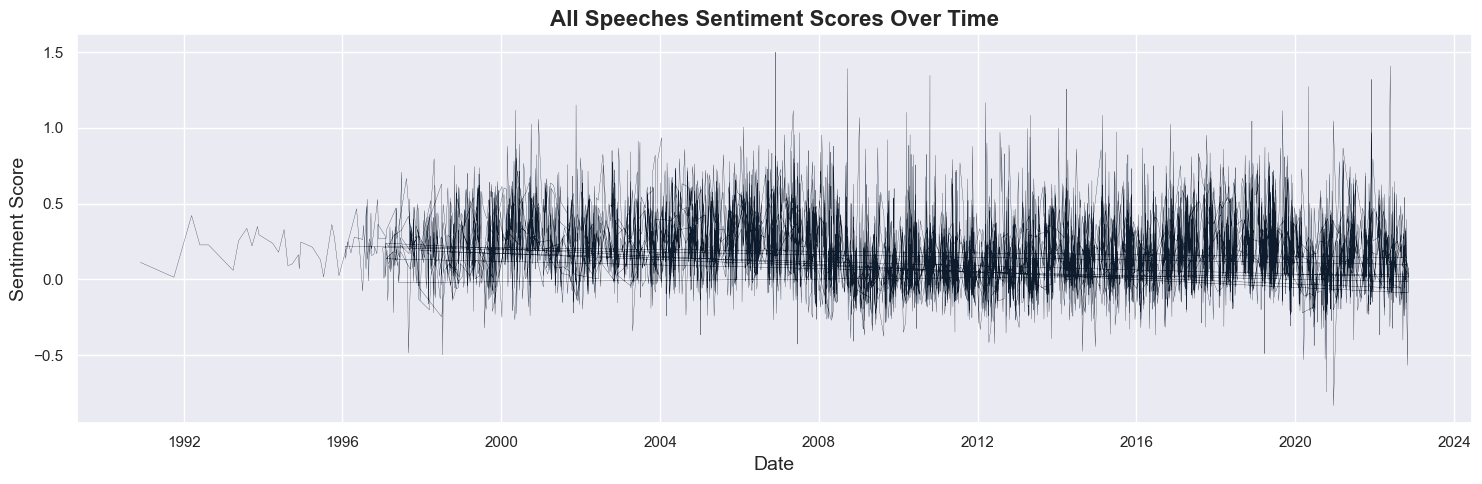

In [404]:
# Sentiment Score over time
plt.figure(figsize=(15, 5))
plt.plot(speeches_short['date_format'], speeches_short['sentiment_lexicon_weighted'], color='#0e1b2c', linewidth=0.2)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sentiment Score', fontsize=14)
plt.title('All Speeches Sentiment Scores Over Time', fontsize=16, fontweight='bold')
plt.grid(True)
plt.tight_layout()
plt.show()

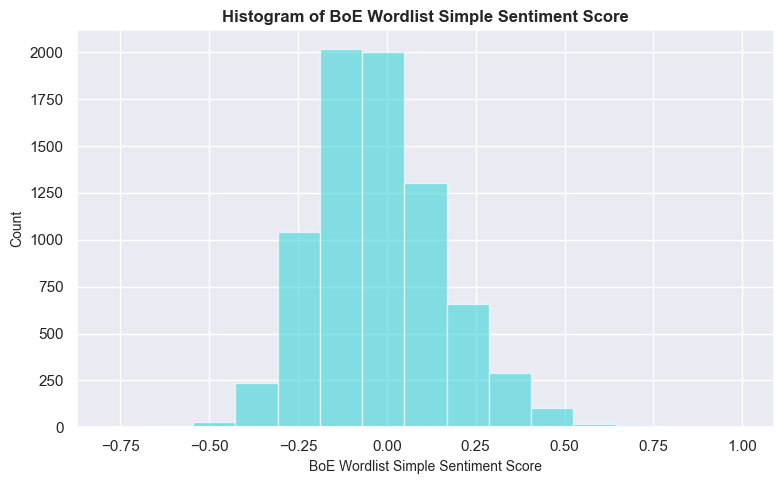

In [382]:
# Plot a histogram of the vader sentiment score for summary
# Set the number of bins.
num_bins = 15
# Set the plot area.
plt.figure(figsize=(8,5))

# Define the bars.
n, bins, patches = plt.hist(speeches_short['sentiment_lexicon_simple'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('BoE Wordlist Simple Sentiment Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of BoE Wordlist Simple Sentiment Score', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

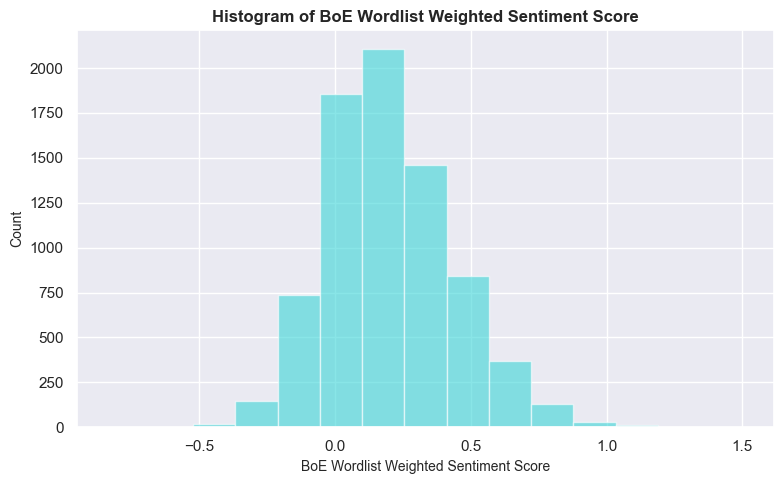

In [384]:
# Plot a histogram of the vader sentiment score for summary
# Set the number of bins.
num_bins = 15
# Set the plot area.
plt.figure(figsize=(8,5))

# Define the bars.
n, bins, patches = plt.hist(speeches_short['sentiment_lexicon_weighted'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('BoE Wordlist Weighted Sentiment Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of BoE Wordlist Weighted Sentiment Score', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

**3.1.b. BoE Speeches only**

In [375]:
# Bank OF England (UK) Speeches Only  
boe_speeches = speeches_short[speeches_short['country'].str.lower() == 'united kingdom'].copy()

# View the Dataframe
boe_speeches.head()

reference         country date_format year_month  year year_month_dt  \
4961  r980915a_BOE  united kingdom  1998-09-15    1998-09  1998    1998-09-01   
4962  r981021b_BOE  united kingdom  1998-10-21    1998-10  1998    1998-10-01   
4963  r981021a_BOE  united kingdom  1998-10-21    1998-10  1998    1998-10-01   
4964  r981101a_BOE  united kingdom  1998-11-01    1998-11  1998    1998-11-01   
4965  r981101b_BOE  united kingdom  1998-11-01    1998-11  1998    1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text  \
4961  Thank you, Chairman. I'm actually very pleased...   
4962  It's a great pleasure to be here in the beauti...   
4963  Few industries have suffered more from volatil...   
4964  My topic this evening is the use of forecasts ...   
4965  Six years ago this week, sterling left the exc...   

                                        text_lemmatised  \
4961  ['thank', 'chairman', 'actually', 'pleased', '...   
4962  ['great', 'pleasure', 'beautiful', 'city', 'br...   
4963  ['industry', 'suffer', 'volatility', 'british'...   
4964  ['topic', 'evening', 'use', 'forecast', 'econo...   
4965  ['six', 'year', 'ago', 'week', 'sterling', 'le...   

                                    text_lemmatised_str  word_count_text  \
4961  thank chairman actually pleased opportunity re...             2387   
4962  great pleasure beautiful city bruges honour op...             4045   
4963  industry suffer volatility british economy pas...             2311   
4964  topic evening use forecast economic policy mak...             4690   
4965  six year ago week sterling leave exchange rate...             4452   

      word_count_text_cleaned  sentiment_lexicon_simple  \
4961                     1162                 -0.143750   
4962                     2108                  0.028571   
4963                     1240                 -0.182353   
4964                     2380                 -0.125424   
4965                     2580                 -0.157303   

      sentiment_lexicon_simple_std  sentiment_lexicon_weighted  \
4961                     -0.670720                    0.179375   
4962                      0.291375                    0.291071   
4963                     -0.886246                    0.020000   
4964                     -0.568402                    0.116271   
4965                     -0.746390                    0.063764   

      sentiment_lexicon_weighted_std  
4961                       -0.093041  
4962                        0.384988  
4963                       -0.775121  
4964                       -0.363107  
4965                       -0.587823

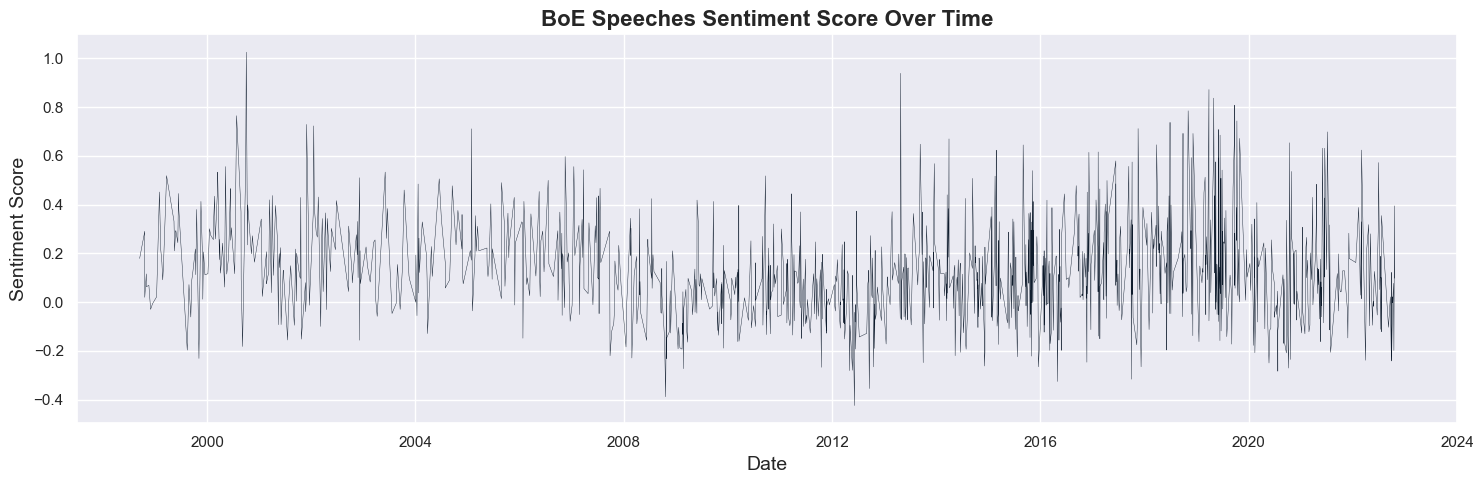

In [398]:
# Sentiment Score over time
plt.figure(figsize=(15, 5))
plt.plot(boe_speeches['date_format'], boe_speeches['sentiment_lexicon_weighted'], color='#0e1b2c', linewidth=0.3)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sentiment Score', fontsize=14)
plt.title('BoE Speeches Sentiment Score Over Time', fontsize=16, fontweight='bold')
plt.grid(True)
plt.tight_layout()
plt.show()

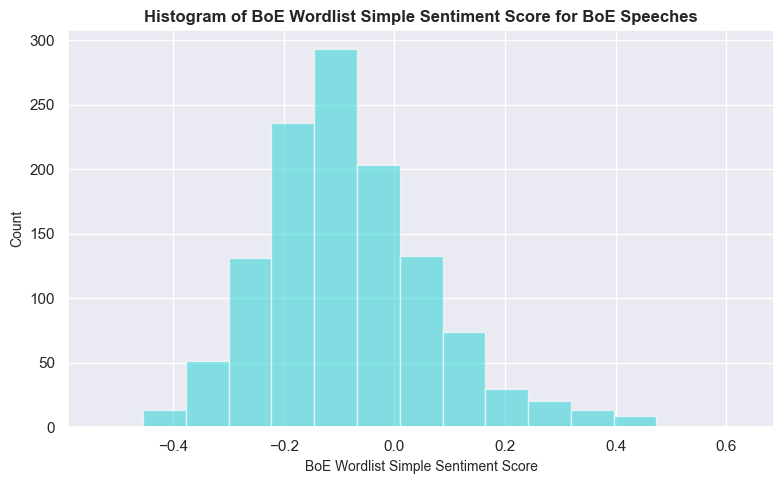

In [155]:
# Plot a histogram of the vader sentiment score for summary
# Set the number of bins.
num_bins = 15
# Set the plot area.
plt.figure(figsize=(8,5))

# Define the bars.
n, bins, patches = plt.hist(boe_speeches['sentiment_lexicon_simple'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('BoE Wordlist Simple Sentiment Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of BoE Wordlist Simple Sentiment Score for BoE Speeches', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

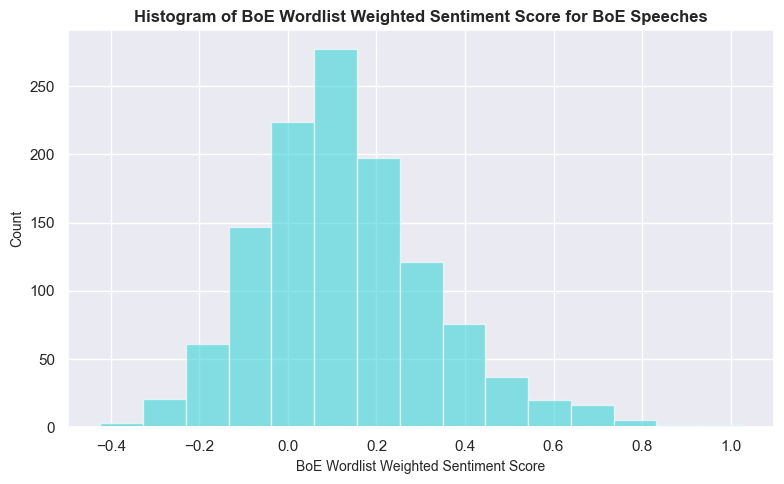

In [157]:
# Plot a histogram of the vader sentiment score for summary
# Set the number of bins.
num_bins = 15
# Set the plot area.
plt.figure(figsize=(8,5))

# Define the bars.
n, bins, patches = plt.hist(boe_speeches['sentiment_lexicon_weighted'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('BoE Wordlist Weighted Sentiment Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of BoE Wordlist Weighted Sentiment Score for BoE Speeches', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

In [159]:
# Prepare indicator dataframe for merge
uk_economic_indicators_merge = uk_economic_indicators.drop(columns=['year', 'month'])

# View the DataFrame
uk_economic_indicators_merge

year_month  uk_inflation_rate_CPIH  uk_unemployment_rate  uk_gdp_growth  \
0      1998-04                   1.815                   6.3            0.6   
1      1998-05                   2.039                   6.3            0.6   
2      1998-06                   1.675                   6.3            0.6   
3      1998-07                   1.443                   6.3            0.3   
4      1998-08                   1.327                   6.2            0.3   
..         ...                     ...                   ...            ...   
316    2024-08                   2.216                   4.3            0.0   
317    2024-09                   1.680                   4.3            0.0   
318    2024-10                   2.281                   4.4            0.1   
319    2024-11                   2.622                   4.4            0.1   
320    2024-12                   2.503                   4.4            0.1   

     uk_interest_rate  uk_consumer_confidence  gbp_usd_fx      ftse_250  \
0                7.25                    1.10    1.673270   5554.720972   
1                7.25                    1.20    1.636589   5799.256322   
2                7.50                   -1.30    1.650718   5739.277233   
3                7.50                   -4.30    1.643657   5595.919582   
4                7.50                   -6.50    1.631950   5173.355054   
..                ...                     ...         ...           ...   
316              5.00                   -7.25    1.293286  20908.952720   
317              5.00                  -15.50    1.321781  20841.357310   
318              5.00                  -15.25    1.304578  20817.302486   
319              4.75                  -13.00    1.274986  20517.825545   
320              4.75                  -12.00    1.264715  20743.810428   

     gilts_short   gilts_medium   gilts_long   uk_credit_growth_no_cc  \
0        5.910000       5.700000     5.710000                    14.1   
1        5.820000       5.570000     5.550000                    14.4   
2        6.170000       5.640000     5.430000                    13.9   
3        6.060000       5.570000     5.380000                    14.6   
4        5.520000       5.190000     5.110000                    14.6   
..            ...            ...          ...                     ...   
316      3.843331       3.949251     4.480954                     6.6   
317      3.755558       3.895691     4.464948                     6.6   
318      4.040317       4.177002     4.703413                     6.3   
319      4.302807       4.430016     4.886294                     6.0   
320      4.243428       4.423888     4.966090                     5.8   

     uk_credit_growth_only_cc  avg_price_all_property_types  
0                        24.7                         64258  
1                        24.5                         64258  
2                        25.5                         64258  
3                        25.6                         67057  
4                        26.1                         67057  
..                        ...                           ...  
316                       9.9                        266225  
317                       9.5                        266398  
318                       9.4                        267358  
319                       8.0                        267946  
320                       8.1                        267864  

[321 rows x 14 columns]

In [161]:
# List of DataFrames to merge
dataframes_to_merge = [uk_economic_indicators_merge]

# Use reduce to merge all DataFrames in the list
boe_speeches_indicators = reduce(lambda left, right: left.merge(right, on='year_month', how='left'), dataframes_to_merge, boe_speeches)

# View the merged DataFrame
boe_speeches_indicators.head()

reference         country date_format year_month  year year_month_dt  \
0  r980915a_BOE  united kingdom  1998-09-15    1998-09  1998    1998-09-01   
1  r981021b_BOE  united kingdom  1998-10-21    1998-10  1998    1998-10-01   
2  r981021a_BOE  united kingdom  1998-10-21    1998-10  1998    1998-10-01   
3  r981101a_BOE  united kingdom  1998-11-01    1998-11  1998    1998-11-01   
4  r981101b_BOE  united kingdom  1998-11-01    1998-11  1998    1998-11-01   

                                               title   author  is_gov  \
0                                             Speech   george       1   
1                                  Britain in Europe   george       1   
2  Impact of the recent turbulence in internation...     king       1   
3        Economic policy, with and without forecasts     budd       0   
4  Inflation targeting in practice: the UK experi...  vickers       0   

                                                text  ... uk_interest_rate  \
0  Thank you, Chairman. I'm actually very pleased...  ...             7.50   
1  It's a great pleasure to be here in the beauti...  ...             7.25   
2  Few industries have suffered more from volatil...  ...             7.25   
3  My topic this evening is the use of forecasts ...  ...             6.75   
4  Six years ago this week, sterling left the exc...  ...             6.75   

  uk_consumer_confidence  gbp_usd_fx     ftse_250  gilts_short   \
0                   -4.9    1.682209  4657.921320          5.00   
1                   -6.7    1.695200  4516.211359          4.98   
2                   -6.7    1.695200  4516.211359          4.98   
3                   -3.5    1.661986  4885.032366          4.71   
4                   -3.5    1.661986  4885.032366          4.71   

   gilts_medium   gilts_long   uk_credit_growth_no_cc  \
0           4.80         4.77                    15.3   
1           4.96         5.00                    15.6   
2           4.96         5.00                    15.6   
3           4.59         4.60                    14.9   
4           4.59         4.60                    14.9   

   uk_credit_growth_only_cc  avg_price_all_property_types  
0                      26.7                         67057  
1                      25.8                         66757  
2                      25.8                         66757  
3                      26.9                         66757  
4                      26.9                         66757  

[5 rows x 31 columns]

In [163]:
# View the columns in the DataFrame
boe_speeches_indicators.columns

Index(['reference', 'country', 'date_format', 'year_month', 'year',
       'year_month_dt', 'title', 'author', 'is_gov', 'text', 'text_lemmatised',
       'text_lemmatised_str', 'word_count_text', 'word_count_text_cleaned',
       'sentiment_lexicon_simple', 'sentiment_lexicon_simple_std',
       'sentiment_lexicon_weighted', 'sentiment_lexicon_weighted_std',
       'uk_inflation_rate_CPIH', 'uk_unemployment_rate', 'uk_gdp_growth',
       'uk_interest_rate', 'uk_consumer_confidence', 'gbp_usd_fx', 'ftse_250',
       'gilts_short ', 'gilts_medium ', 'gilts_long ',
       'uk_credit_growth_no_cc', 'uk_credit_growth_only_cc',
       'avg_price_all_property_types'],
      dtype='object')

In [165]:
# Review the DataFrame
boe_speeches_indicators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1209 entries, 0 to 1208
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   reference                       1209 non-null   object        
 1   country                         1209 non-null   object        
 2   date_format                     1209 non-null   datetime64[ns]
 3   year_month                      1209 non-null   period[M]     
 4   year                            1209 non-null   int32         
 5   year_month_dt                   1209 non-null   datetime64[ns]
 6   title                           1209 non-null   object        
 7   author                          1209 non-null   object        
 8   is_gov                          1209 non-null   int64         
 9   text                            1209 non-null   object        
 10  text_lemmatised                 1209 non-null   object        
 11  text

**3.1.c. Timeframes**

Time scale selected based on introduction of the euro to make data comparable acorss countries.

In [169]:
# Create separate DataFrame to filter for 2000 to 2022
speeches_1999_2022 = speeches_short[(speeches_short['year'] >= 1999) & (speeches_short['year'] <= 2022)].reset_index()

# View the DataFrame
speeches_1999_2022

index      reference        country date_format year_month  year  \
0        55   r990311a_BOA      australia  1999-03-11    1999-03  1999   
1        56   r990521a_BOA      australia  1999-05-21    1999-05  1999   
2        57   r990617a_BOA      australia  1999-06-17    1999-06  1999   
3        58   r990729a_BOA      australia  1999-07-29    1999-07  1999   
4        59   r991027a_BOA      australia  1999-10-27    1999-10  1999   
...     ...            ...            ...         ...        ...   ...   
7375   7716  r221010a_FOMC  united states  2022-10-10    2022-10  2022   
7376   7717  r221012b_FOMC  united states  2022-10-12    2022-10  2022   
7377   7718  r221012a_FOMC  united states  2022-10-12    2022-10  2022   
7378   7719  r221014a_FOMC  united states  2022-10-14    2022-10  2022   
7379   7720  r221020a_FOMC  united states  2022-10-20    2022-10  2022   

     year_month_dt                                              title  \
0       1999-03-01                                                      
1       1999-05-01                                                      
2       1999-06-01                                                      
3       1999-07-01                                                      
4       1999-10-01                                                      
...            ...                                                ...   
7375    2022-10-01  Restoring Price Stability in an Uncertain Econ...   
7376    2022-10-01  Managing the Promise and Risk of Financial Inn...   
7377    2022-10-01  Forward Guidance as a Monetary Policy Tool: Co...   
7378    2022-10-01  The U.S. Dollar and Central Bank Digital Curre...   
7379    2022-10-01                                  Welcoming Remarks   

          author  is_gov                                               text  \
0     macfarlane       1  Last time I spoke to a group like this in Toky...   
1     macfarlane       1  It is a pleasure to be in Hong Kong talking to...   
2     macfarlane       1  Governor, in testimony to the House of was rel...   
3     macfarlane       1  The following is the text of the R.C. Mills Me...   
4     macfarlane       1  The following is the text of the Chris Higgins...   
...          ...     ...                                                ...   
7375    brainard       0  It is a pleasure to join this discussion today...   
7376        barr       0  Thank you, Chris, and thank you for the invita...   
7377      bowman       0  Thanks to the Money Marketeers for inviting me...   
7378      waller       0  Thank you, Professor Jackson, and thank you to...   
7379      bowman       0  Welcome, and thank you for joining us to discu...   

                                        text_lemmatised  \
0     ['last', 'time', 'speak', 'group', 'like', 'to...   
1     ['pleasure', 'hong', 'kong', 'talk', 'clsa', '...   
2     ['governor', 'testimony', 'house', 'release', ...   
3     ['follow', 'text', 'r', 'c', 'mill', 'memorial...   
4     ['follow', 'text', 'chris', 'higgins', 'delive...   
...                                                 ...   
7375  ['pleasure', 'join', 'discussion', 'today', 'i...   
7376  ['thank', 'chris', 'thank', 'invitation', 'spe...   
7377  ['thanks', 'money', 'marketeers', 'invite', 's...   
7378  ['thank', 'professor', 'jackson', 'thank', 'in...   
7379  ['welcome', 'thank', 'join', 'u', 'discuss', '...   

                                    text_lemmatised_str  word_count_text  \
0     last time speak group like tokyo september 199...             2271   
1     pleasure hong kong talk clsa investor forum co...             1944   
2     governor testimony house release 6 may 1999 th...             2787   
3     follow text r c mill memorial lecture deliver ...             4521   
4     follow text chris higgins deliver honour invit...             2679   
...                                                 ...              ...   
7375  pleasure join discussion today inflation hig

In [171]:
# Create separate DataFrame to filter for 2000 to 2022 for BoE speeches only
boe_indicators_1999_2022 = boe_speeches_indicators[(boe_speeches_indicators['year'] >= 1999) & \
                                                    (boe_speeches_indicators['year'] <= 2022)].reset_index()

# View the DataFrame
boe_indicators_1999_2022

index     reference         country date_format year_month  year  \
0         8  r990112a_BOE  united kingdom  1999-01-12    1999-01  1999   
1         9  r990118a_BOE  united kingdom  1999-01-18    1999-01  1999   
2        10  r990201a_BOE  united kingdom  1999-02-01    1999-02  1999   
3        11  r990210a_BOE  united kingdom  1999-02-10    1999-02  1999   
4        12  r990218a_BOE  united kingdom  1999-02-18    1999-02  1999   
...     ...           ...             ...         ...        ...   ...   
1196   1204  r221007a_BOE  united kingdom  2022-10-07    2022-10  2022   
1197   1205  r221012a_BOE  united kingdom  2022-10-12    2022-10  2022   
1198   1206  r221015a_BOE  united kingdom  2022-10-15    2022-10  2022   
1199   1207  r221019a_BOE  united kingdom  2022-10-19    2022-10  2022   
1200   1208  r221020a_BOE  united kingdom  2022-10-20    2022-10  2022   

     year_month_dt                                              title  \
0       1999-01-01                                             Speech   
1       1999-01-01                                             Speech   
2       1999-02-01                                             Speech   
3       1999-02-01                                             Speech   
4       1999-02-01                           The Chancellor's Lecture   
...            ...                                                ...   
1196    2022-10-01         Shocks, inflation, and the policy response   
1197    2022-10-01    Monetary policy: an anchor in challenging times   
1198    2022-10-01  Monetary policy and financial stability interv...   
1199    2022-10-01  Governance of “Decentralised” Finance: Get up,...   
1200    2022-10-01       The inflationary consequences of real shocks   

         author  is_gov  ... uk_interest_rate uk_consumer_confidence  \
0        george       1  ...             6.00                   -3.6   
1        george       1  ...             6.00                   -3.6   
2        george       1  ...             5.50                   -1.6   
3        george       1  ...             5.50                   -1.6   
4        george       1  ...             5.50                   -1.6   
...         ...     ...  ...              ...                    ...   
1196    ramsden       0  ...             2.25                  -41.0   
1197       pill       0  ...             2.25                  -41.0   
1198     bailey       1  ...             2.25                  -41.0   
1199    wilkins       0  ...             2.25                  -41.0   
1200  broadbent       0  ...             2.25                  -41.0   

     gbp_usd_fx      ftse_250  gilts_short   gilts_medium   gilts_long   \
0      1.650910   4904.934033      4.300000       4.240000     4.320000   
1      1.650910   4904.934033      4.300000       4.240000     4.320000   
2      1.627565   5192.548511      4.450000       4.390000     4.420000   
3      1.627565   5192.548511      4.450000       4.390000     4.420000   
4      1.627565   5192.548511      4.450000       4.390000     4.420000   
...         ...           ...           ...            ...          ...   
1196   1.130743  17442.702079      4.039021       3.959858     4.129311   
1197   1.130743  17442.702079      4.039021       3.959858     4.129311   
1198   1.130743  17442.702079      4.039021       3.959858     4.129311   
1199   1.130743  17442.702079      4.039021       3.959858     4.129311   
1200   1.130743  17442.702079      4.039021       3.959858     4.129311   

      uk_credit_growth_no_cc  uk_credit_growth_only_cc  \
0                       13.5                      26.1   
1                       13.5                      26.1   
2                       13.2                      26.1   
3                       13.2                      26.1   
4                       13.2                      26.1   
...                      ...                       ...   
1196                     5.1                      11.5   
1197      

In [173]:
boe_indicators_1999_2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1201 entries, 0 to 1200
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   index                           1201 non-null   int64         
 1   reference                       1201 non-null   object        
 2   country                         1201 non-null   object        
 3   date_format                     1201 non-null   datetime64[ns]
 4   year_month                      1201 non-null   period[M]     
 5   year                            1201 non-null   int32         
 6   year_month_dt                   1201 non-null   datetime64[ns]
 7   title                           1201 non-null   object        
 8   author                          1201 non-null   object        
 9   is_gov                          1201 non-null   int64         
 10  text                            1201 non-null   object        
 11  text

### 3.1. Country comparison

In [176]:
# Check columns in the DataFrame
speeches_short.columns

Index(['reference', 'country', 'date_format', 'year_month', 'year',
       'year_month_dt', 'title', 'author', 'is_gov', 'text', 'text_lemmatised',
       'text_lemmatised_str', 'word_count_text', 'word_count_text_cleaned',
       'sentiment_lexicon_simple', 'sentiment_lexicon_simple_std',
       'sentiment_lexicon_weighted', 'sentiment_lexicon_weighted_std'],
      dtype='object')

In [178]:
# View the countries
speeches_short['country'].unique()

array(['australia', 'canada', 'euro area', 'japan', 'sweden',
       'switzerland', 'united kingdom', 'united states'], dtype=object)

In [180]:
# Group average sentiment data by year
speeches_yearly = speeches_short.groupby(['year', 'country'])[['sentiment_lexicon_simple', 'sentiment_lexicon_simple_std', \
                                                         'sentiment_lexicon_weighted', 'sentiment_lexicon_weighted_std'\
                                                        ]].mean().reset_index()

# View the DataFrame
speeches_yearly.head()

year    country  sentiment_lexicon_simple  sentiment_lexicon_simple_std  \
0  1990  australia                 -0.119816                     -0.537091   
1  1991  australia                 -0.167785                     -0.804912   
2  1992  australia                  0.017739                      0.230895   
3  1993  australia                 -0.012194                      0.063773   
4  1994  australia                 -0.052324                     -0.160276   

   sentiment_lexicon_weighted  sentiment_lexicon_weighted_std  
0                    0.112442                       -0.379494  
1                    0.014094                       -0.800397  
2                    0.292015                        0.389025  
3                    0.252628                        0.220463  
4                    0.178494                       -0.096809

In [182]:
# Review the DataFrame
speeches_yearly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   year                            215 non-null    int32  
 1   country                         215 non-null    object 
 2   sentiment_lexicon_simple        215 non-null    float64
 3   sentiment_lexicon_simple_std    215 non-null    float64
 4   sentiment_lexicon_weighted      215 non-null    float64
 5   sentiment_lexicon_weighted_std  215 non-null    float64
dtypes: float64(4), int32(1), object(1)
memory usage: 9.4+ KB


In [184]:
# Group average sentiment data for 1999 to 2022
speeches_1999_2022_yearly = speeches_1999_2022.groupby(['year', 'country'])[['sentiment_lexicon_simple', \
                                                                            'sentiment_lexicon_simple_std', \
                                                                            'sentiment_lexicon_weighted', \
                                                                            'sentiment_lexicon_weighted_std'\
                                                                           ]].mean().reset_index()

# View the DataFrame
speeches_1999_2022_yearly.head()

year    country  sentiment_lexicon_simple  sentiment_lexicon_simple_std  \
0  1999  australia                 -0.064206                     -0.226613   
1  1999     canada                  0.033602                      0.319458   
2  1999  euro area                  0.128988                      0.852015   
3  1999      japan                 -0.082874                     -0.330839   
4  1999     sweden                 -0.056931                     -0.185997   

   sentiment_lexicon_weighted  sentiment_lexicon_weighted_std  
0                    0.196030                       -0.021763  
1                    0.309715                        0.464776  
2                    0.402779                        0.863068  
3                    0.134954                       -0.283151  
4                    0.185153                       -0.068313

In [186]:
speeches_1999_2022_yearly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   year                            192 non-null    int32  
 1   country                         192 non-null    object 
 2   sentiment_lexicon_simple        192 non-null    float64
 3   sentiment_lexicon_simple_std    192 non-null    float64
 4   sentiment_lexicon_weighted      192 non-null    float64
 5   sentiment_lexicon_weighted_std  192 non-null    float64
dtypes: float64(4), int32(1), object(1)
memory usage: 8.4+ KB


In [188]:
# Group average sentiment data by year
boe_speeches_yearly = boe_speeches_indicators.groupby(['year'])[['sentiment_lexicon_simple', 'sentiment_lexicon_simple_std', \
                                                                 'sentiment_lexicon_weighted', 'sentiment_lexicon_weighted_std', \
                                                                 'uk_inflation_rate_CPIH', 'uk_unemployment_rate', 'uk_gdp_growth', \
                                                                 'uk_interest_rate', 'uk_consumer_confidence', 'gbp_usd_fx',  \
                                                                 'ftse_250', 'gilts_short ', 'gilts_medium ', 'gilts_long ', \
                                                                 'uk_credit_growth_no_cc', 'uk_credit_growth_only_cc', \
                                                                 'avg_price_all_property_types']].mean().reset_index()

# View the DataFrame
boe_speeches_yearly.head()

year  sentiment_lexicon_simple  sentiment_lexicon_simple_std  \
0  1998                 -0.149342                     -0.701943   
1  1999                 -0.051135                     -0.153640   
2  2000                  0.037997                      0.343998   
3  2001                 -0.087290                     -0.355498   
4  2002                 -0.030069                     -0.036025   

   sentiment_lexicon_weighted  sentiment_lexicon_weighted_std  \
0                    0.088097                       -0.483684   
1                    0.185937                       -0.064958   
2                    0.308585                        0.459943   
3                    0.148234                       -0.226316   
4                    0.236919                        0.153231   

   uk_inflation_rate_CPIH  uk_unemployment_rate  uk_gdp_growth  \
0                1.412375                6.1625       0.650000   
1                1.294533                5.9800       1.006667   
2                0.784556                5.5000       0.830556   
3                1.219525                5.0750       0.520000   
4                1.379433                5.1500       0.546667   

   uk_interest_rate  uk_consumer_confidence  gbp_usd_fx     ftse_250  \
0          6.843750               -4.675000    1.674952  4733.667270   
1          5.358333                0.156667    1.622406  5716.781754   
2          5.979167               -0.388889    1.529136  6501.639693   
3          5.081250                0.140000    1.441217  6102.856224   
4          4.000000                1.103333    1.492741  5368.412391   

   gilts_short   gilts_medium   gilts_long   uk_credit_growth_no_cc  \
0      4.736250       4.636250     4.661250               14.925000   
1      5.326333       4.992667     4.592333               12.860000   
2      5.901389       5.305000     4.497778               11.297222   
3      5.014250       4.890250     4.604750               10.162500   
4      4.844000       4.879000     4.696000               13.903333   

   uk_credit_growth_only_cc  avg_price_all_property_types  
0                 26.400000                  66794.500000  
1                 23.380000                  71727.166667  
2                 21.158333                  81757.027778  
3                 18.155000                  89094.600000  
4                 18.436667                 102983.866667

In [871]:
# Group average sentiment data by year
boe_speeches_1999_2022_yearly = boe_indicators_1999_2022.groupby(['year'])[['sentiment_lexicon_simple', 'sentiment_lexicon_simple_std', \
                                                                 'sentiment_lexicon_weighted', 'sentiment_lexicon_weighted_std', \
                                                                 'uk_inflation_rate_CPIH', 'uk_unemployment_rate', 'uk_gdp_growth', \
                                                                 'uk_interest_rate', 'uk_consumer_confidence', 'gbp_usd_fx',  \
                                                                 'ftse_250', 'gilts_short ', 'gilts_medium ', 'gilts_long ', \
                                                                 'uk_credit_growth_no_cc', 'uk_credit_growth_only_cc', \
                                                                 'avg_price_all_property_types']].mean().reset_index()

# View the DataFrame
boe_speeches_1999_2022_yearly.head()

year  sentiment_lexicon_simple  sentiment_lexicon_simple_std  \
0  1999                 -0.051135                     -0.153640   
1  2000                  0.037997                      0.343998   
2  2001                 -0.087290                     -0.355498   
3  2002                 -0.030069                     -0.036025   
4  2003                 -0.070092                     -0.259477   

   sentiment_lexicon_weighted  sentiment_lexicon_weighted_std  \
0                    0.185937                       -0.064958   
1                    0.308585                        0.459943   
2                    0.148234                       -0.226316   
3                    0.236919                        0.153231   
4                    0.163706                       -0.160098   

   uk_inflation_rate_CPIH  uk_unemployment_rate  uk_gdp_growth  \
0                1.294533              5.980000       1.006667   
1                0.784556              5.500000       0.830556   
2                1.219525              5.075000       0.520000   
3                1.379433              5.150000       0.546667   
4                1.371211              5.042105       0.805263   

   uk_interest_rate  uk_consumer_confidence  gbp_usd_fx     ftse_250  \
0          5.358333                0.156667    1.622406  5716.781754   
1          5.979167               -0.388889    1.529136  6501.639693   
2          5.081250                0.140000    1.441217  6102.856224   
3          4.000000                1.103333    1.492741  5368.412391   
4          3.697368               -5.457895    1.626196  4854.418901   

   gilts_short   gilts_medium   gilts_long   uk_credit_growth_no_cc  \
0      5.326333       4.992667     4.592333               12.860000   
1      5.901389       5.305000     4.497778               11.297222   
2      5.014250       4.890250     4.604750               10.162500   
3      4.844000       4.879000     4.696000               13.903333   
4      4.171186       4.456977     4.579004               12.215789   

   uk_credit_growth_only_cc  avg_price_all_property_types  
0                 23.380000                  71727.166667  
1                 21.158333                  81757.027778  
2                 18.155000                  89094.600000  
3                 18.436667                 102983.866667  
4                 20.236842                 119253.421053

In [873]:
# View the data types
boe_speeches_1999_2022_yearly.dtypes

year                                int32
sentiment_lexicon_simple          float64
sentiment_lexicon_simple_std      float64
sentiment_lexicon_weighted        float64
sentiment_lexicon_weighted_std    float64
uk_inflation_rate_CPIH            float64
uk_unemployment_rate              float64
uk_gdp_growth                     float64
uk_interest_rate                  float64
uk_consumer_confidence            float64
gbp_usd_fx                        float64
ftse_250                          float64
gilts_short                       float64
gilts_medium                      float64
gilts_long                        float64
uk_credit_growth_no_cc            float64
uk_credit_growth_only_cc          float64
avg_price_all_property_types      float64
dtype: object

In [867]:
# Define function to plot a lineplot with various categories.
def generate_multi_lineplot(df, x_axis, y_axis, hue, title, date=None, ylim=None, \
                            save_path=None, errorbar=None, events=None, event_years=None, **kwargs):

    # Set figure size & style for seaborn.
    sns.set_theme(style='darkgrid')
    sns.set(rc={'figure.figsize':(14, 8)})
    
    # Sort DataFrame by the time column.
    df.sort_values(by=x_axis, inplace=True)
    
    # Plot the lineplot.
    sns.lineplot(data=df, x=x_axis, y=y_axis, hue=hue, ci=None, **kwargs)

    # Get current axes
    ax = plt.gca()
    
    # Customize the plot.
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(clean_label(x_axis), fontsize=14)
    plt.ylabel(clean_label(y_axis), fontsize=14)
    plt.legend(title='Legend', fontsize=12, bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tick_params(axis='both', labelsize=12)
    
    # Add annotation lines, if provided.
    if date:
        plt.axvline(x=date, color='k', linestyle='--')

    # Add shading for each event period
    if events:
        for start_date, end_date in events:
            ax.axvspan(start_date, end_date, color='yellow', alpha=0.3)

    # Add event lines if provided
    if event_years:
        for year, label in event_years:
            ax.axvline(x=year, color='blue', linestyle='--', alpha=0.7)
            # Add a label or annotation
            y_position = plt.ylim()[1] * 0.3  # 30% of max y for label placement
            ax.text(year, y_position, label, rotation=90, verticalalignment='bottom', color='blue')
    
    # Rotate labels on the x-axis.
    plt.xticks(rotation=45)
    
    # Set y-axis limits, if provided.
    if ylim:
        plt.ylim(ylim)

    # Save the plot, if save_path is provided.
    if save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')
    
    # Display the chart.
    plt.tight_layout()
    plt.show()

In [254]:
def lineplot_two_axis(df, x_axis, y_axis, hue, title, 
                            second_y=None, second_y_label=None,
                            date=None, ylim=None, save_path=None, 
                            errorbar=None, events=None, event_years=None, **kwargs):
    # Set theme and size
    sns.set_theme(style='darkgrid')
    sns.set(rc={'figure.figsize':(14, 8)})

    # Sort DataFrame by x_axis
    df.sort_values(by=x_axis, inplace=True)

    # Plot primary y data
    ax = plt.gca()
    sns.lineplot(data=df, x=x_axis, y=y_axis, hue=hue, ci=None, ax=ax, **kwargs)

    # Plot secondary y data if provided
    if second_y is not None:
        ax2 = ax.twinx()
        sns.lineplot(data=df, x=x_axis, y=second_y, hue=hue, ci=None, ax=ax2, legend=False, **kwargs)
        if second_y_label:
            ax2.set_ylabel(second_y_label, fontsize=14)

    # Titles and labels
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(x_axis, fontsize=14)  # You can add a cleaning function if needed
    plt.ylabel(y_axis, fontsize=14)
    if second_y and second_y_label:
        # If multiple y-axes, set label of primary axis (optional)
        plt.ylabel(y_axis, fontsize=14)

    # Legend handling
    plt.legend(title='Legend', fontsize=12, bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tick_params(axis='both', labelsize=12)

    # Annotations: date line
    if date:
        plt.axvline(x=date, color='k', linestyle='--')

    # Event shaded regions
    if events:
        for start_date, end_date in events:
            ax.axvspan(start_date, end_date, color='yellow', alpha=0.3)

    # Event lines & labels
    if event_years:
        for year, label in event_years:
            ax.axvline(x=year, color='blue', linestyle='--', alpha=0.7)
            y_pos = plt.ylim()[1] * 0.3
            ax.text(year, y_pos, label, rotation=90, verticalalignment='bottom', color='blue')

    # Rotate date labels
    plt.xticks(rotation=45)

    # Y-axis limits
    if ylim:
        plt.ylim(ylim)

    # Save plot if path provided
    if save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')

    plt.tight_layout()
    plt.show()


In [256]:
# Define function to plot a lineplot with a trendline.
def generate_lineplot_with_trendline(df, x_axis, y_axis, title, date=None, ylim=None, \
                                     rotate_xticks=False, save_path=None, errorbar=None):
    
    # Set figure size & style for seaborn.
    sns.set_theme(style='darkgrid')
    sns.set(rc={'figure.figsize':(14, 8)})
    
    # Ensure time column is in datetime format.
    df[x_axis] = pd.to_datetime(df[x_axis])
    
    # Sort DataFrame by the time column.
    df.sort_values(by=x_axis, inplace=True)
    
    # Calculate trendline.
    x = np.arange(len(df))
    y = df[y_axis].values
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    
    # Plot the lineplot.
    sns.lineplot(data=df, x=x_axis, y=y_axis, label=clean_label(y_axis))
    
    # Plot the trendline.
    plt.plot(df[x_axis], p(x), linestyle='--', color='r', label='Trendline')

    # Customize the plot.
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(clean_label(x_axis), fontsize=14)
    plt.ylabel(clean_label(y_axis), fontsize=14)
    plt.legend(title='Legend', fontsize=12, bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tick_params(axis='both', labelsize=12)
    
    # Add annotation lines, if provided.
    if date:
        plt.axvline(x=date, color='k', linestyle='--')
    
    # Rotate x-tick labels by 45 degrees, if specified.
    if rotate_xticks:
        plt.xticks(rotation=45)
    
    # Set y-axis limits, if provided.
    if ylim:
        plt.ylim(ylim)

    # Save the plot, if save_path is provided.
    if save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')
    
    # Display the chart.
    plt.tight_layout()
    plt.show()

In [857]:
# Define function to plot a lineplot with a trendline.
def generate_lineplot(df, x_axis, y_axis, title, date=None, ylim=None, \
                                     rotate_xticks=False, save_path=None, errorbar=None):
    
    # Set figure size & style for seaborn.
    sns.set_theme(style='darkgrid')
    sns.set(rc={'figure.figsize':(14, 8)})
    
    # Ensure time column is in datetime format.
    df[x_axis] = pd.to_datetime(df[x_axis])
    
    # Sort DataFrame by the time column.
    df.sort_values(by=x_axis, inplace=True)
    
    # Calculate trendline.
    x = np.arange(len(df))
    y = df[y_axis].values
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    
    # Plot the lineplot.
    sns.lineplot(data=df, x=x_axis, y=y_axis, label=clean_label(y_axis))

    # Customize the plot.
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(clean_label(x_axis), fontsize=14)
    plt.ylabel(clean_label(y_axis), fontsize=14)
    plt.legend(title='Legend', fontsize=12, bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tick_params(axis='both', labelsize=12)
    
    # Add annotation lines, if provided.
    if date:
        plt.axvline(x=date, color='k', linestyle='--')
    
    # Rotate x-tick labels by 45 degrees, if specified.
    if rotate_xticks:
        plt.xticks(rotation=45)
    
    # Set y-axis limits, if provided.
    if ylim:
        plt.ylim(ylim)

    # Save the plot, if save_path is provided.
    if save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')
    
    # Display the chart.
    plt.tight_layout()
    plt.show()

In [258]:
# List of countries to display
countries_to_display = ['united kingdom', 'united states', 'euro area']

# Only UK to display
country_to_display = ['united kingdom']

# Dates to incude
events = [(2003, 'BoE Inflation Target'), (2008, 'Global Financial Crisis'), (2016, 'Brexit Referendum'), \
            (2020, 'Covid Pandemic')]

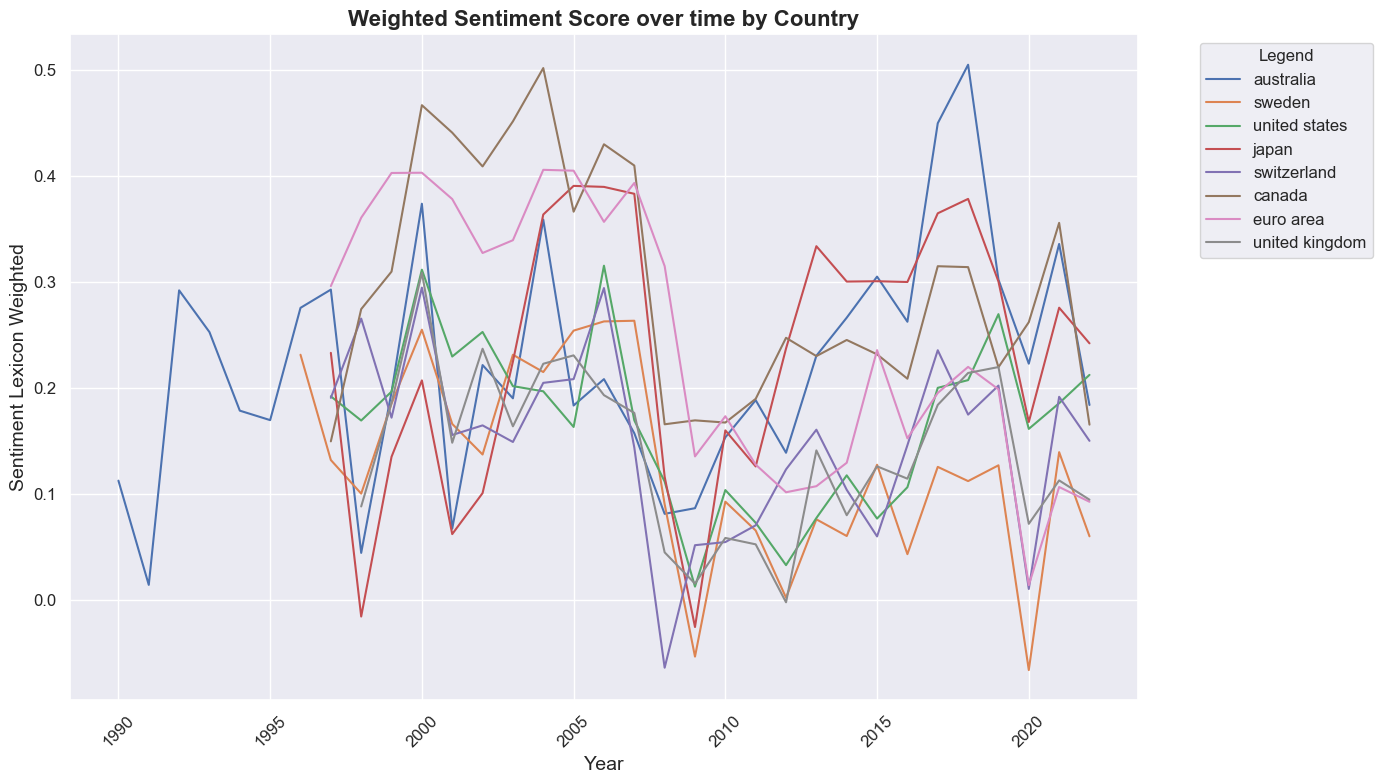

In [260]:
generate_multi_lineplot(speeches_yearly, x_axis='year', y_axis='sentiment_lexicon_weighted', hue='country', \
                        title= 'Weighted Sentiment Score over time by Country', date=None, ylim=None, \
                            save_path=None, errorbar=None, events=None)

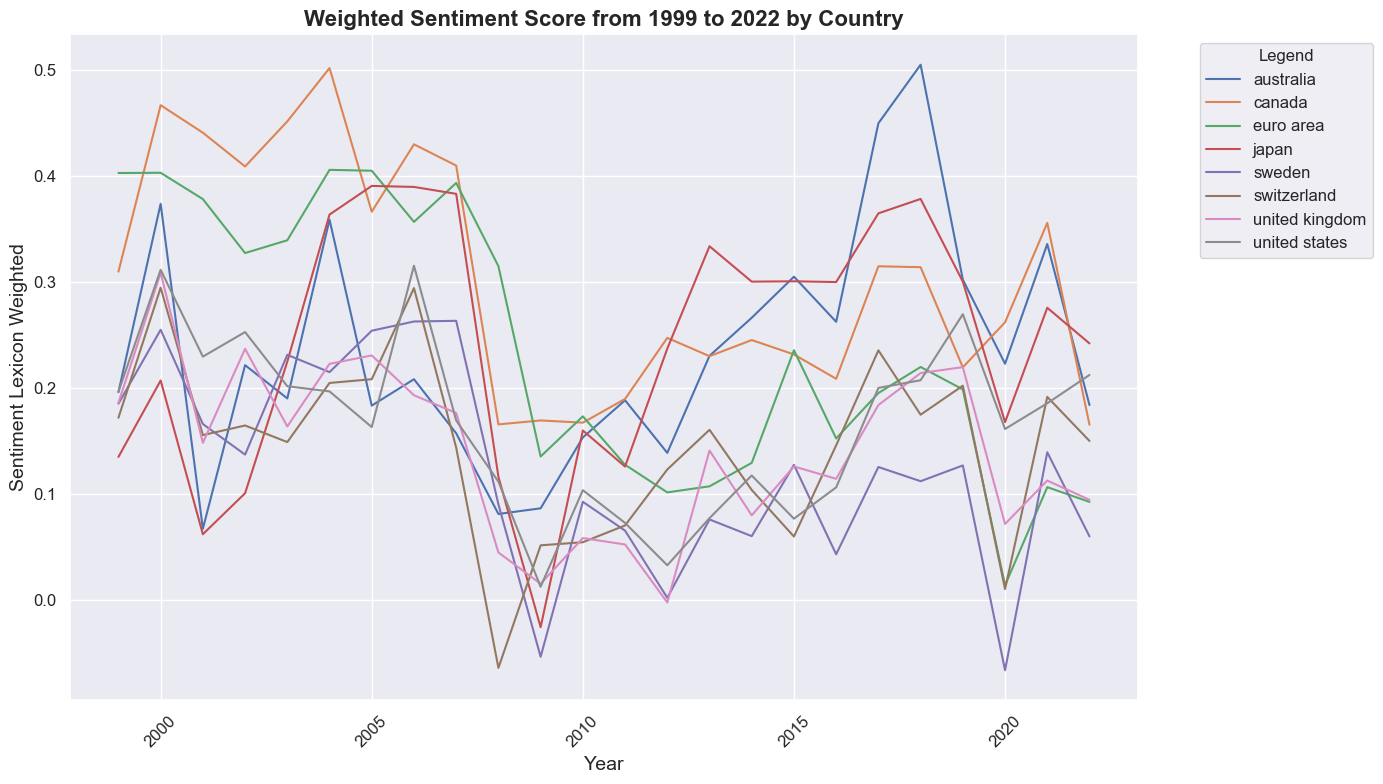

In [262]:
generate_multi_lineplot(speeches_1999_2022_yearly, x_axis='year', y_axis='sentiment_lexicon_weighted', hue='country', \
                        title= 'Weighted Sentiment Score from 1999 to 2022 by Country', date=None, ylim=None, \
                            save_path=None, errorbar=None, events=None)

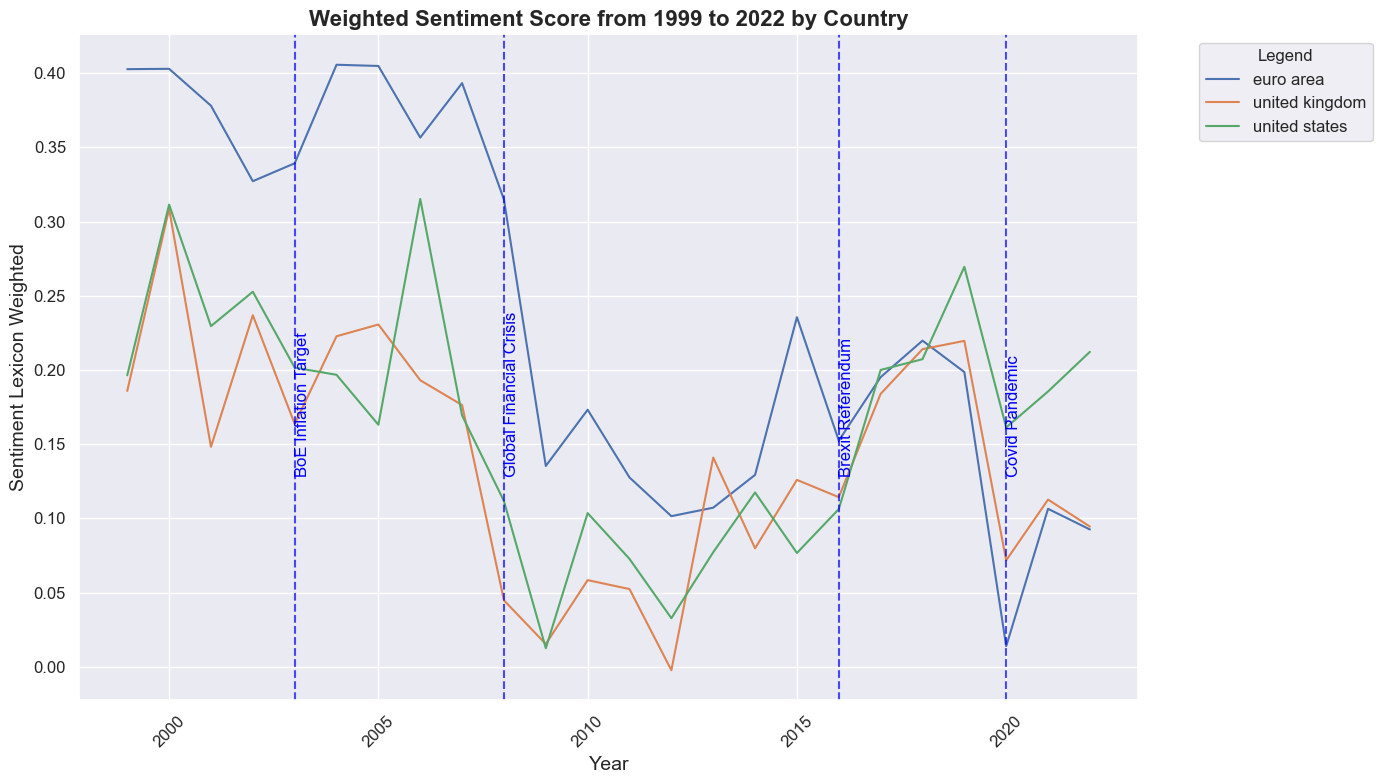

In [264]:
generate_multi_lineplot(speeches_1999_2022_yearly[speeches_1999_2022_yearly['country'].isin(countries_to_display)], \
                        x_axis='year', y_axis='sentiment_lexicon_weighted', hue='country', \
                        title= 'Weighted Sentiment Score from 1999 to 2022 by Country', date=None, ylim=None, \
                            save_path=None, errorbar=None, events=None, event_years=events)

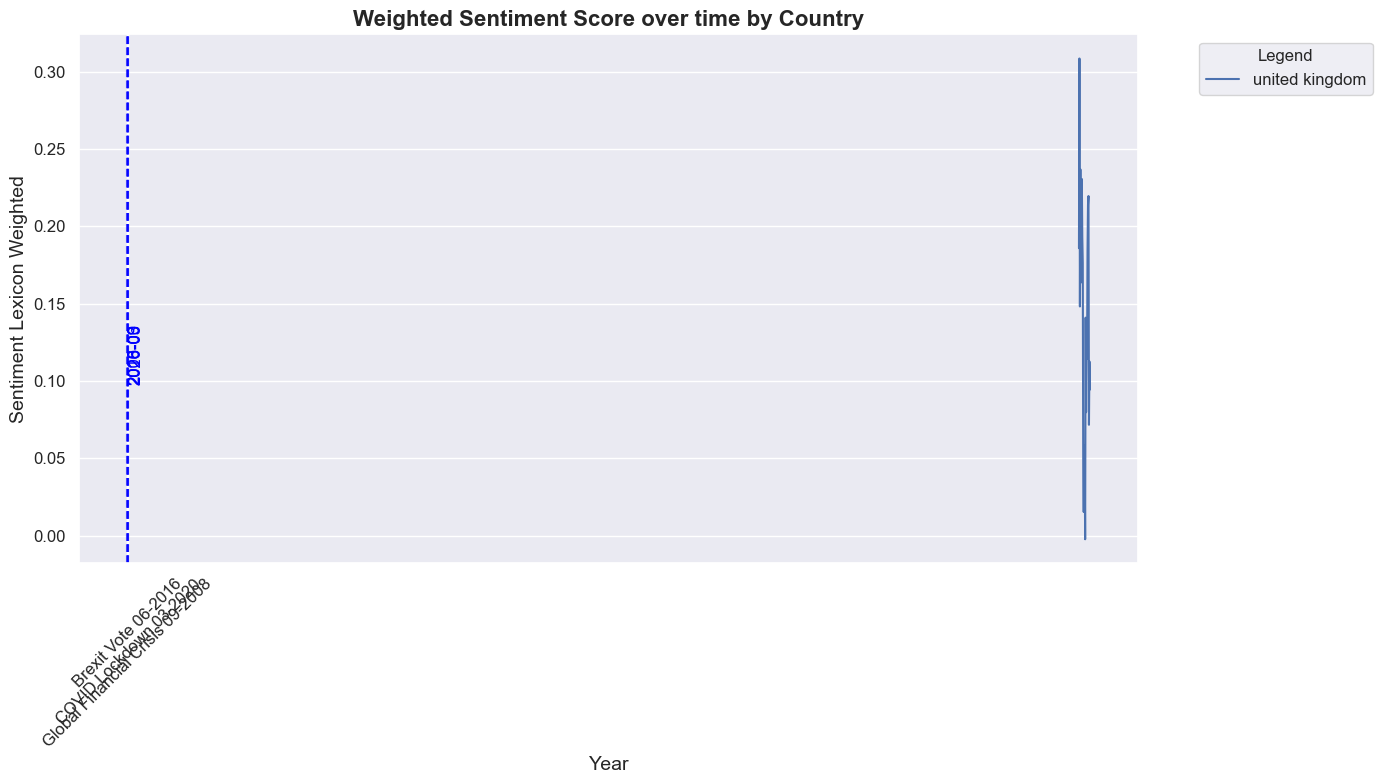

In [875]:
generate_multi_lineplot(speeches_1999_2022_yearly[speeches_1999_2022_yearly['country'].isin(country_to_display)], \
                        x_axis='year', y_axis='sentiment_lexicon_weighted', hue='country', \
                        title= 'Weighted Sentiment Score over time by Country', date=None, ylim=None, \
                            save_path=None, errorbar=None, events=None, event_years=events)

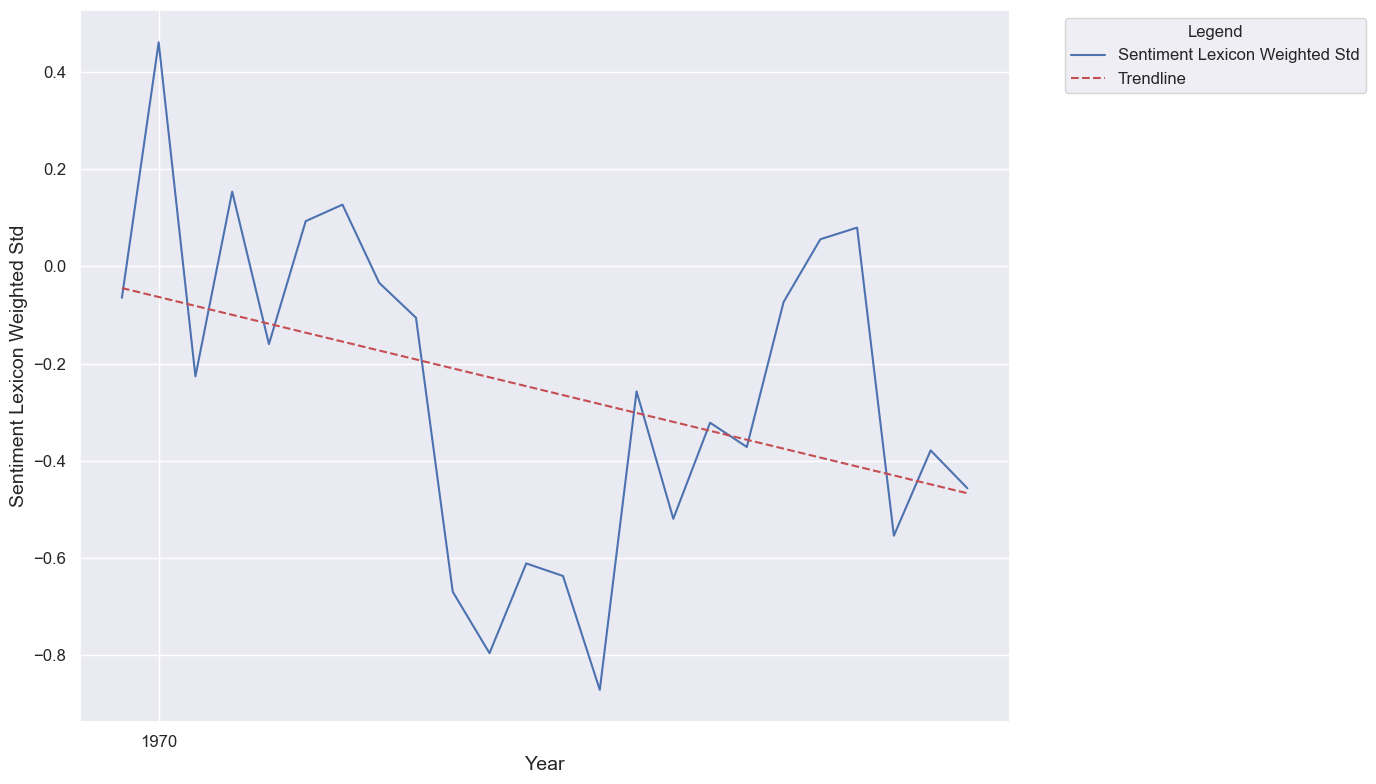

In [280]:
generate_lineplot_with_trendline(boe_speeches_1999_2022_yearly, x_axis='year', y_axis='sentiment_lexicon_weighted_std', \
                                 title=None, date=None, ylim=None, rotate_xticks=False, save_path=None, errorbar=None)

### 3.2. View BoE data in a wordclouds 

In [282]:
def show_wordcloud(counter):
    # Generate and display the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(counter)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_top_non_stopwords_wordcloud(text):
    stop = set(stopwords.words('english'))
    
    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    # Show the word cloud
    show_wordcloud(counter)

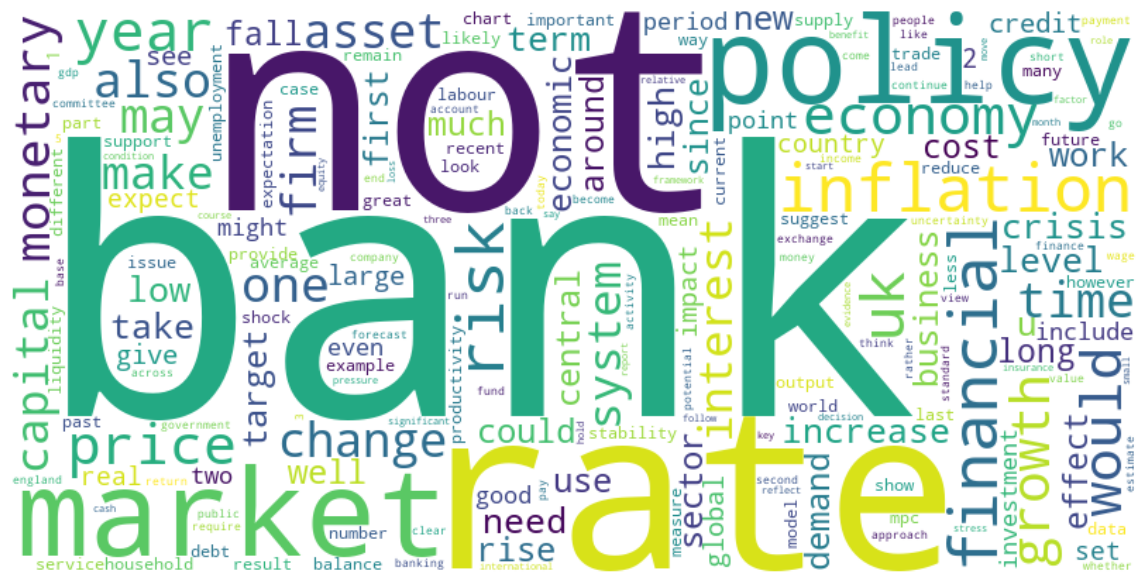

In [284]:
# Create wordcloud of lemmatised text
plot_top_non_stopwords_wordcloud(boe_speeches['text_lemmatised_str'])

In [285]:
# Define bar chart for top words
def top_words_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    # Set plot size
    plt.figure(figsize=(12, 8))
    
    # Plot
    sns.barplot(x=y, y=x)
    
    # Set label font sizes
    plt.xlabel('Count', fontsize=14)
    plt.ylabel('Words', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.title('Top Non-Stopword Words', fontsize=16)
    plt.tight_layout()
    plt.show()

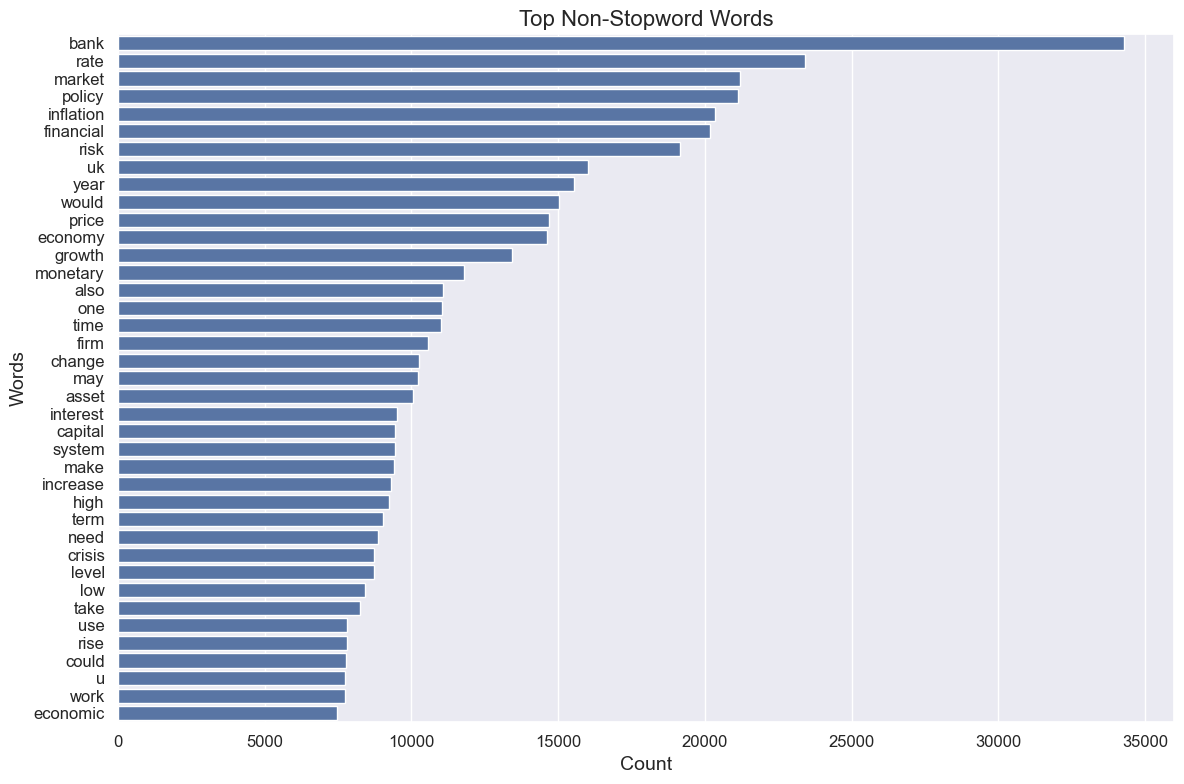

In [288]:
# Create bar chart to show top words
top_words_barchart(boe_speeches['text_lemmatised_str'])

In [289]:
# Define bar chart for top word groups
def top_word_group_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

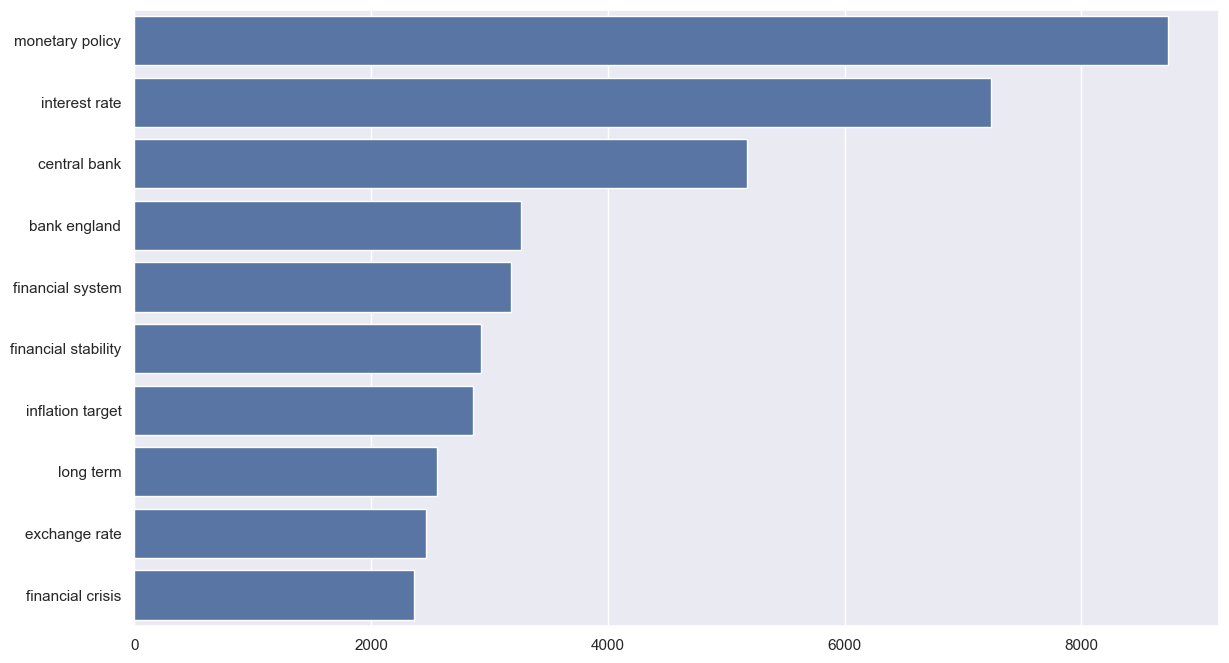

In [292]:
# Plot top phrases with 2 words
top_word_group_barchart(boe_indicators_1999_2022['text_lemmatised_str'],2)

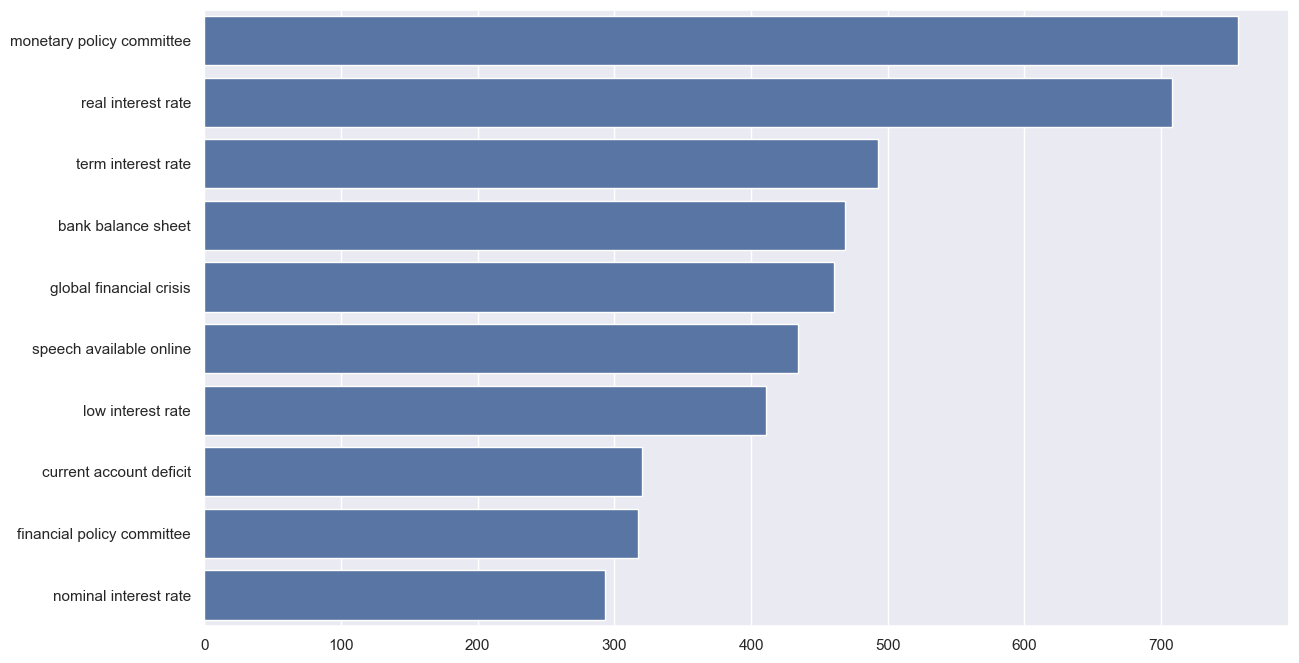

In [293]:
# Plot top phrases with 3 words
top_word_group_barchart(boe_indicators_1999_2022['text_lemmatised_str'],3)

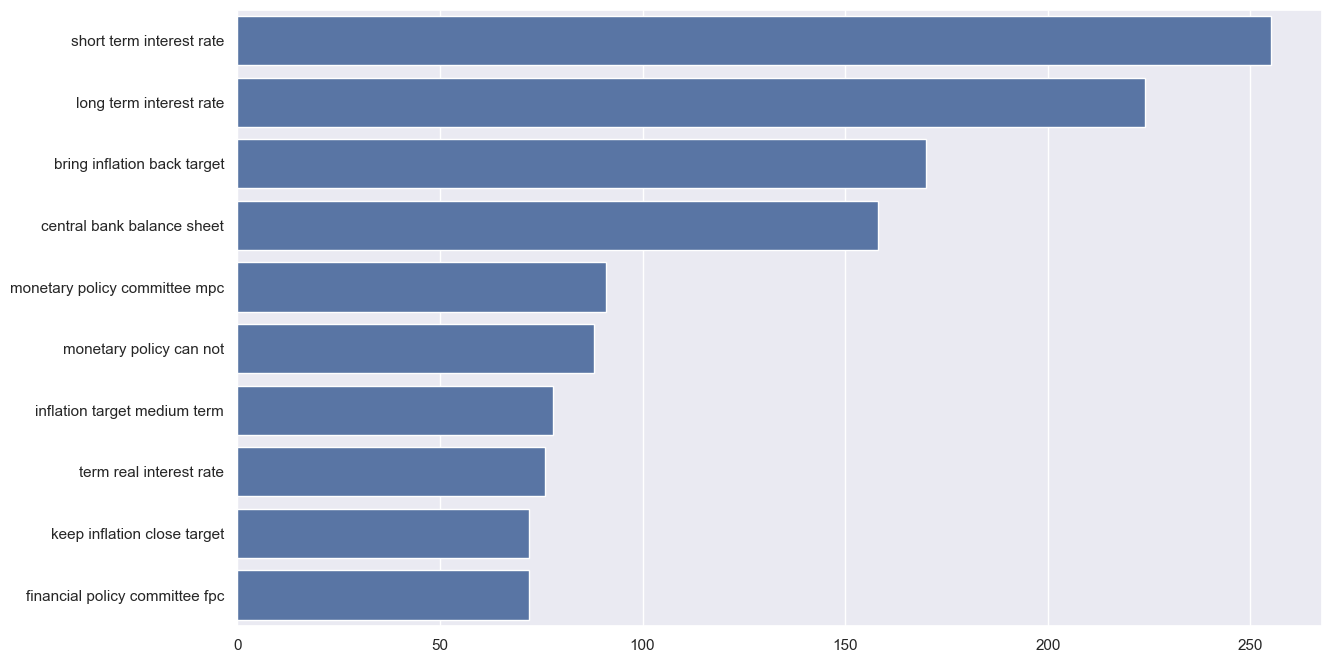

In [294]:
# Plot top phrases with 4 words
top_word_group_barchart(boe_indicators_1999_2022['text_lemmatised_str'],4)

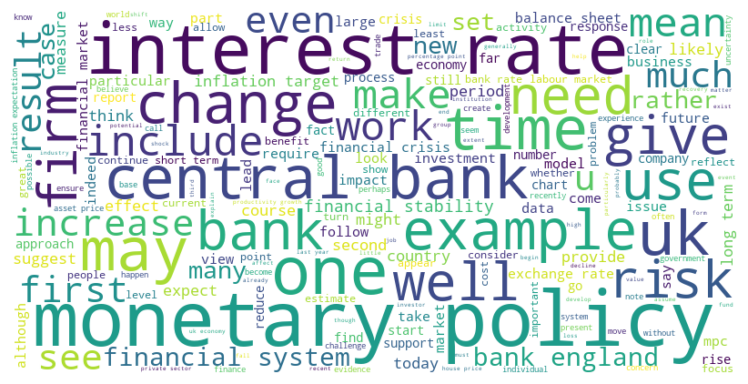

In [295]:
# Convert tokens into a single string.
boe_speeches_text = ' '.join(boe_indicators_1999_2022['text_lemmatised_str'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=42).generate(boe_speeches_text)

# Display the word cloud
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')

# Hide the axis.
plt.axis('off') 

# Dispaly the word cloud.
plt.tight_layout()
plt.show()

**View data for before and after 2010**

In [297]:
# Create separate DataFrames to filter for 1999 to 2009 and 2010 to 2022
boe_1999_2009 = boe_indicators_1999_2022[(boe_indicators_1999_2022['year'] >= 1999) & (boe_indicators_1999_2022['year'] <= 2009)].reset_index()
boe_2010_2022 = boe_indicators_1999_2022[(boe_indicators_1999_2022['year'] >= 2010) & (boe_indicators_1999_2022['year'] <= 2022)].reset_index()

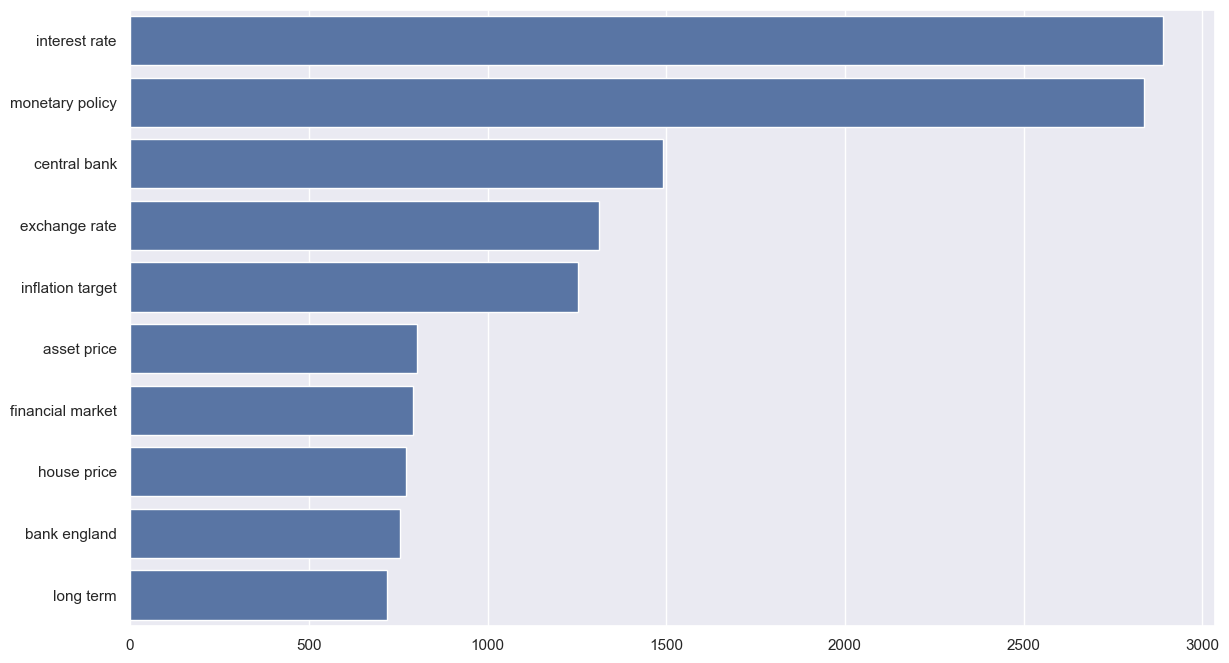

In [299]:
# Plot top phrases with 2 words
top_word_group_barchart(boe_1999_2009['text_lemmatised_str'],2)

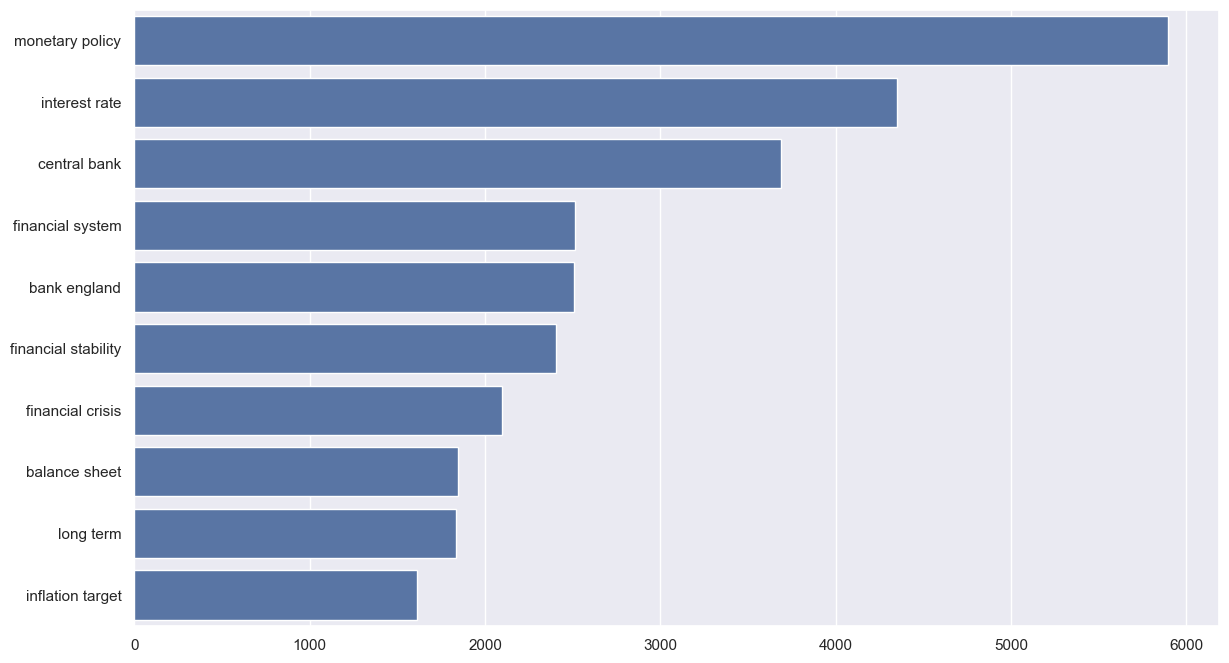

In [300]:
# Plot top phrases with 2 words
top_word_group_barchart(boe_2010_2022['text_lemmatised_str'],2)

### 3.3. BoE Speech Statistics

**3.3.a. Word Count per Year**

In [308]:
# Group and aggregate sentiment scores by month
wordcount_monthly = boe_indicators_1999_2022.groupby('year_month_dt').agg({'word_count_text': 'mean',
                                                                       'word_count_text_cleaned': 'mean',
                                                                       'reference': 'count'
                                                                      }).reset_index().rename(columns={'reference': 'speech_count'})
# View the DataFrame
wordcount_monthly.head()

year_month_dt  word_count_text  word_count_text_cleaned  speech_count
0    1999-01-01      2492.000000              1274.500000             2
1    1999-02-01      2583.750000              1335.000000             4
2    1999-03-01      4021.500000              2166.500000             2
3    1999-05-01      3686.800000              2012.400000             5
4    1999-06-01      2086.333333              1087.333333             3

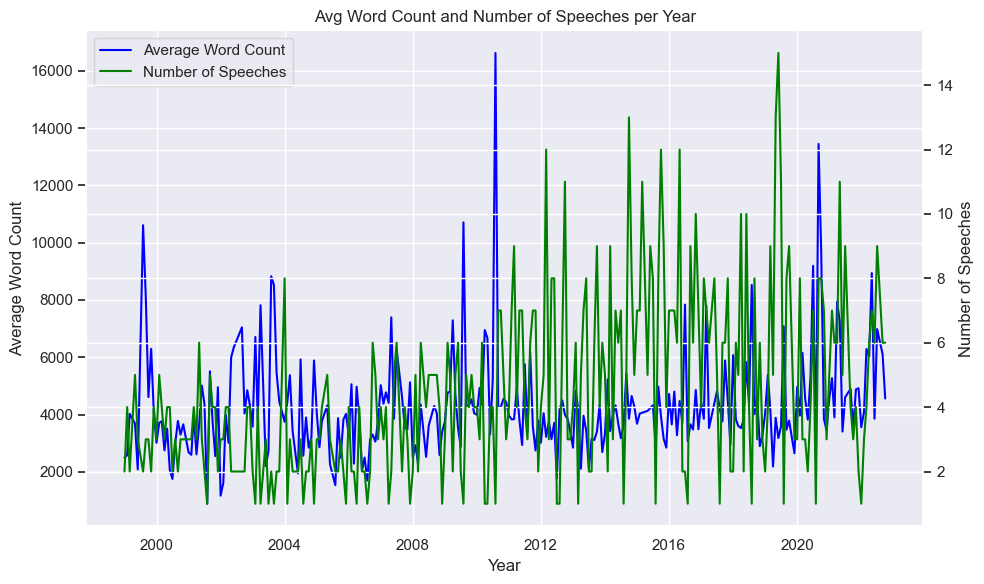

In [310]:
# Create the main plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot 'word_count' on the primary y-axis
ax1.plot(wordcount_monthly['year_month_dt'], wordcount_monthly['word_count_text'], color='blue', label='Average Word Count')
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Word Count')
ax1.tick_params(axis='y')

# Create a secondary y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot 'speech_count' on the secondary y-axis
ax2.plot(wordcount_monthly['year_month_dt'], wordcount_monthly['speech_count'], color='green', label='Number of Speeches')
ax2.set_ylabel('Number of Speeches')
ax2.tick_params(axis='y')

# Add titles and grid if needed
plt.title('Avg Word Count and Number of Speeches per Year')

# Optionally, add a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [312]:
# Group and aggregate sentiment scores by year
wordcount_yearly = boe_indicators_1999_2022.groupby('year').agg({'word_count_text': 'mean',
                                                                       'word_count_text_cleaned': 'mean',
                                                                       'reference': 'count'
                                                                      }).reset_index().rename(columns={'reference': 'speech_count'})

# View the DataFrame
wordcount_yearly.head()

year  word_count_text  word_count_text_cleaned  speech_count
0  1999      4543.966667              2514.633333            30
1  2000      3168.472222              1707.055556            36
2  2001      3716.375000              2049.550000            40
3  2002      3996.500000              2184.500000            30
4  2003      4854.000000              2679.684211            19

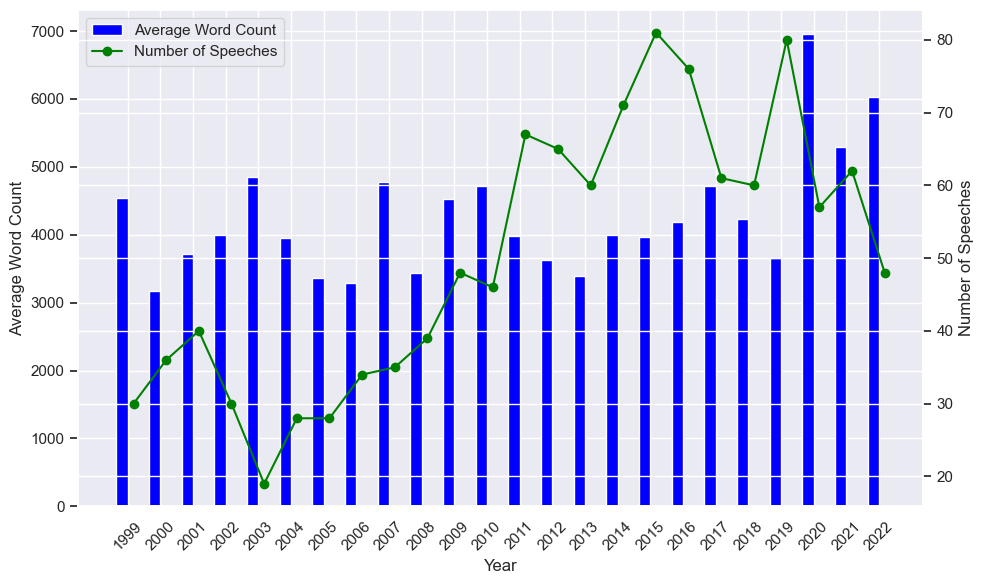

In [314]:
years = wordcount_yearly['year']
n_years = len(years)
x = np.arange(n_years)
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for 'word_count_text'
ax1.bar(x - width/2, wordcount_yearly['word_count_text'], width, color='blue', label='Average Word Count')
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Word Count')
ax1.set_xticks(x)
ax1.set_xticklabels(years, rotation=45)

# Create the secondary axis
ax2 = ax1.twinx()

# Line plot for 'speech_count' without log scale
ax2.plot(x + width/2, wordcount_yearly['speech_count'], color='green', marker='o', label='Number of Speeches')

ax2.set_ylabel('Number of Speeches')

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.tight_layout()
plt.show()

**3.3.b. Speeches by Govenor and Non-Govenor**

In [316]:
# Group and aggregate number of speeches by governor by year
boe_indicators_1999_2022_gov_yearly = boe_indicators_1999_2022.groupby(['year', 'is_gov']).size().reset_index(name='count')

# View the DataFrame
boe_indicators_1999_2022_gov_yearly.head()

year  is_gov  count
0  1999       0     14
1  1999       1     16
2  2000       0     19
3  2000       1     17
4  2001       0     27

In [318]:
# Pivot the data for plotting
boe_indicators_1999_2022_gov_yearly_pivot = boe_indicators_1999_2022_gov_yearly.pivot(index='year', \
                                                                                      columns='is_gov', values='count').fillna(0)

# View the DataFrame
boe_indicators_1999_2022_gov_yearly_pivot.head()

is_gov   0   1
year          
1999    14  16
2000    19  17
2001    27  13
2002    14  16
2003    14   5

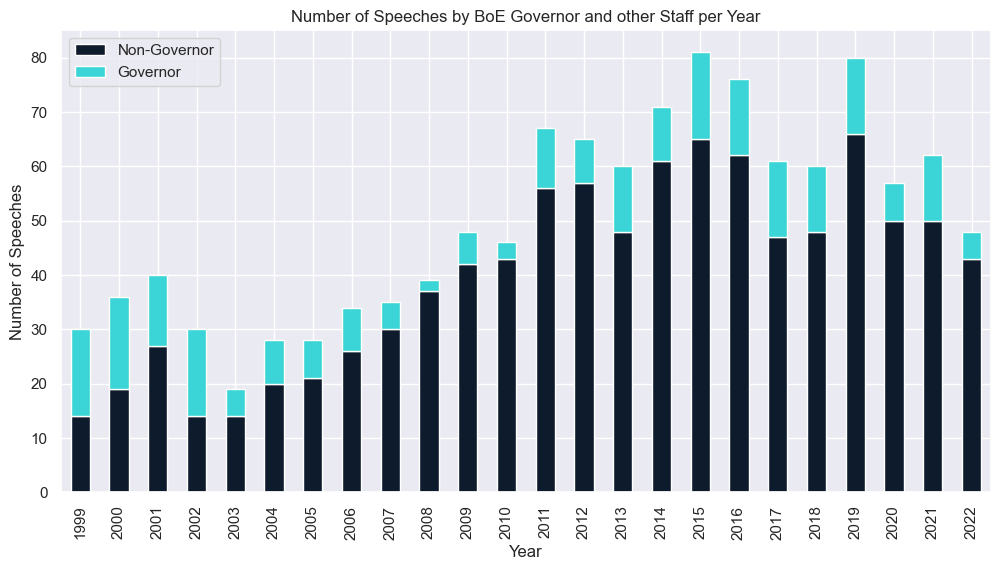

In [839]:
# Plot a bar chart per month
ax = boe_indicators_1999_2022_gov_yearly_pivot.plot(kind='bar', stacked=True, figsize=(12, 6), color=('#0e1b2c','#3bd5d7'))

# Customize plot
ax.set_xlabel('Year')
ax.set_ylabel('Number of Speeches')
ax.set_title('Number of Speeches by BoE Governor and other Staff per Year')

# Get current legend handles and labels
handles, labels = ax.get_legend_handles_labels()

# Replace '0' and '1' in labels with desired labels
labels = ['Non-Governor' if lbl == '0' else 'Governor' for lbl in labels]

# Set the legend with updated labels
ax.legend(handles, labels)

# Display the plot
plt.show()

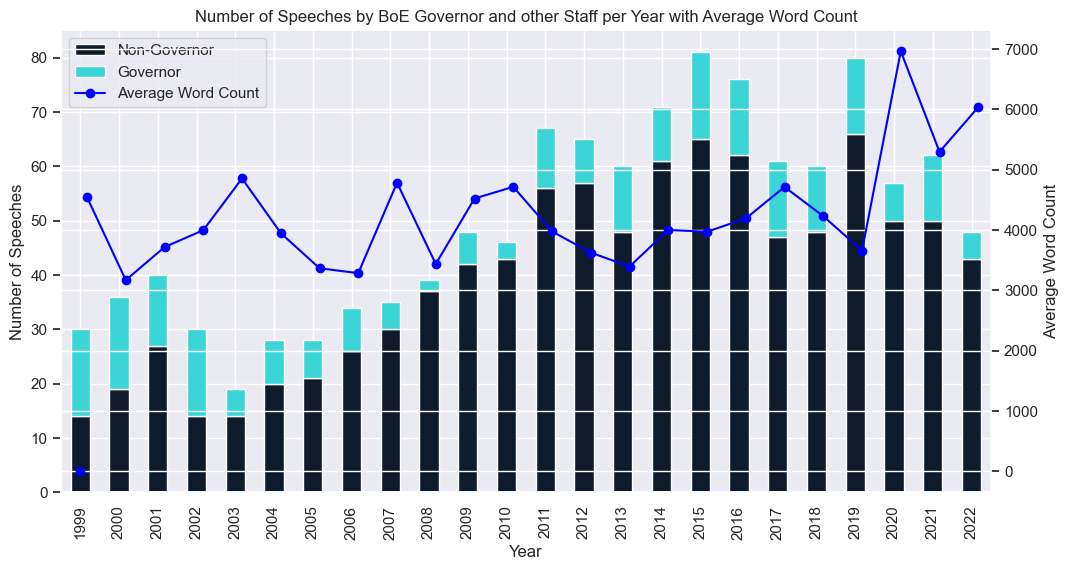

In [354]:
# Plot the bar chart of governor and non governor speeches
ax = boe_indicators_1999_2022_gov_yearly_pivot.plot(
    kind='bar', stacked=True, figsize=(12, 6), color=('#0e1b2c','#3bd5d7'))

ax.set_xlabel('Year')
ax.set_ylabel('Number of Speeches')
ax.set_title('Number of Speeches by BoE Governor and other Staff per Year with Average Word Count')
# ax.legend(title='Staff Member')

# Create a secondary axis
ax2 = ax.twinx()

# Line plot for 'speech_count' without log scale
ax2.plot(x + width/2, wordcount_yearly['word_count_text'], width, color='blue', marker='o', label='Average Word Count')

# Set secondary y-label
ax2.set_ylabel('Average Word Count')

# Retrieve handles and labels for both plots
handles, labels = ax.get_legend_handles_labels()
handles_line, labels_line = ax2.get_legend_handles_labels()

# Replace '0' and '1' in labels with 'Non-Governor' and 'Governor'
labels = ['Non-Governor' if lbl == '0' else 'Governor' for lbl in labels]

# Combine handles and labels
all_handles = handles + [handles_line[0]]
all_labels = labels + [labels_line[0]]

# Plot the full legend once
ax.legend(all_handles, all_labels, loc='upper left')

# Show the combined plot
plt.show()

### 3.4. Sentiment Analysis

**3.4.a. Governor vs Non-governor**

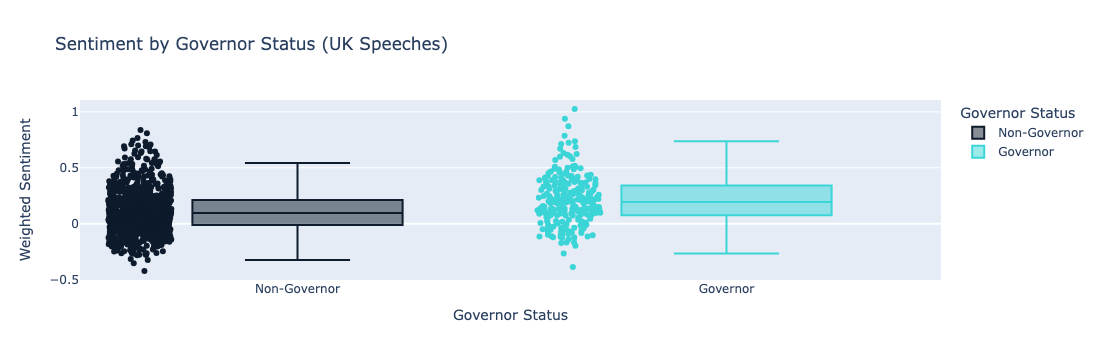

In [847]:
# Create a new column with descriptive labels
boe_indicators_1999_2022['gov_label'] = boe_indicators_1999_2022['is_gov'].map({0: 'Non-Governor', 1: 'Governor'})

# Now plot using 'gov_label' as x
fig_gov = px.box(
    boe_indicators_1999_2022,
    x='gov_label',  # use the new label column
    y='sentiment_lexicon_weighted',
    points='all',
    title='Sentiment by Governor Status (UK Speeches)',
    labels={'gov_label': 'Governor Status', 'sentiment_lexicon_weighted': 'Weighted Sentiment'},
    color='gov_label',
    color_discrete_map={
        'Non-Governor': '#0e1b2c',
        'Governor': '#3bd5d7'
    },
    category_orders={'gov_label': ['Non-Governor', 'Governor']}
)

fig_gov.show()

**3.4.b. Major Events**

In [436]:
# Major events (month granularity)
events = [
    ('Global Financial Crisis 09-2008', '2008-09'),
    ('Brexit Vote 06-2016', '2016-06'),
    ('COVID Lockdown 03-2020', '2020-03')
]

# Your list of events with order
events_order = ['Global Financial Crisis 09-2008', 'Brexit Vote 06-2016', 'COVID Lockdown 03-2020']

# Create DataFrame and convert to datetime
event_df = pd.DataFrame(events, columns=['event', 'month'])
event_df['month'] = pd.to_datetime(event_df['month'], format='%Y-%m')

# Convert 'event' column to categorical with specified order
event_df['event'] = pd.Categorical(event_df['event'], categories=events_order, ordered=True)

# Optional: sort DataFrame by 'event'
event_df = event_df.sort_values('event')

In [438]:
# Initialize list for sentiment comparison results
sentiment_comparison = []

for _, row in event_df.iterrows():
    event_name = row['event']
    event_date = row['month']
    
    # Define time windows around the event
    windows = {
        '4-6 months before': (event_date - pd.DateOffset(months=6), event_date - pd.DateOffset(months=3)),
        '2-3 months before': (event_date - pd.DateOffset(months=3), event_date - pd.DateOffset(months=1)),
        '1 month before': (event_date - pd.DateOffset(months=1), event_date - pd.DateOffset(days=1)),
        '1 month after': (event_date, event_date + pd.DateOffset(months=1) - pd.DateOffset(days=1)),
        '2-3 months after': (event_date, event_date + pd.DateOffset(months=3) - pd.DateOffset(months=1)),
        '4-6 months after': (event_date, event_date + pd.DateOffset(months=6) - pd.DateOffset(months=3))
    }

    for period_name, (start_date, end_date) in windows.items():
        speeches = boe_indicators_1999_2022[
            (boe_indicators_1999_2022['date_format'] >= start_date) &
            (boe_indicators_1999_2022['date_format'] <= end_date)
        ]

        # Save results
        sentiment_comparison.append({
            'event': event_name,
            'period': period_name,
            'avg_sentiment': speeches['sentiment_lexicon_weighted'].mean(),
            'count': speeches.shape[0]
        })

# Convert to DataFrame
sentiment_df = pd.DataFrame(sentiment_comparison)

# Define the order of periods
order = ['4-6 months before', '2-3 months before', '1 month before', '1 month after', '2-3 months after', '4-6 months after']
sentiment_df['period'] = pd.Categorical(sentiment_df['period'], categories=order, ordered=True)
sentiment_df = sentiment_df.sort_values(['period'])

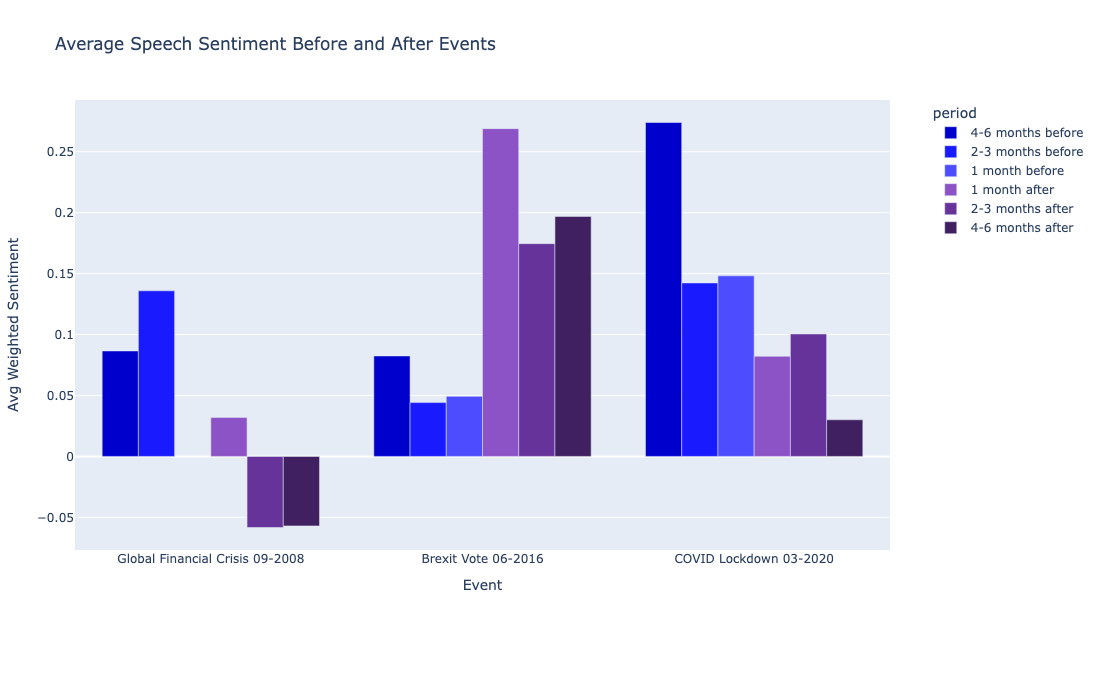

In [444]:
# Create bar plot
fig = px.bar(
    sentiment_df,
    x='event',
    y='avg_sentiment',
    color='period',
    barmode='group',
    text='avg_sentiment',
    title='Average Speech Sentiment Before and After Events',
    labels={'avg_sentiment': 'Avg Weighted Sentiment', 'event': 'Event'},
    category_orders={'event': ['Global Financial Crisis 09-2008', 'Brexit Vote 06-2016', 'COVID Lockdown 03-2020']},
    color_discrete_map={
        '4-6 months before': '#0000cc', 
        '2-3 months before': '#1a1aff', 
        '1 month before': '#4d4dff',
        '1 month after': '#8c53c6',
        '2-3 months after': '#66339a',
        '4-6 months after': '#402061'
    }
)

# Rotate x-axis labels for better fit
fig.update_xaxes()
fig.update_traces(text=None)

# Improve layout: bigger size, margins, and legend position
fig.update_layout(
    height=700,
    width=1000,
    margin=dict(l=50, r=50, t=100, b=150),
    showlegend=True,
    legend=dict(
        x=1.05,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

# Show the plot
fig.show()

### 3.4.Seasonality Analysis

**3.4.a. BoE Analysis**

In [446]:
# Group and aggregate sentiment scores by month
boe_sentiment_monthly = boe_indicators_1999_2022.groupby('year_month_dt')[['sentiment_lexicon_weighted']].mean().reset_index()

# View the DataFrame.
boe_sentiment_monthly.head()

year_month_dt  sentiment_lexicon_weighted
0    1999-01-01                    0.085728
1    1999-02-01                    0.231430
2    1999-03-01                    0.332402
3    1999-05-01                    0.271080
4    1999-06-01                    0.356269

In [448]:
# Set the datetime as index
boe_sentiment_monthly.set_index('year_month_dt', inplace=True)

# View the DataFrame
boe_sentiment_monthly.head()

sentiment_lexicon_weighted
year_month_dt                            
1999-01-01                       0.085728
1999-02-01                       0.231430
1999-03-01                       0.332402
1999-05-01                       0.271080
1999-06-01                       0.356269

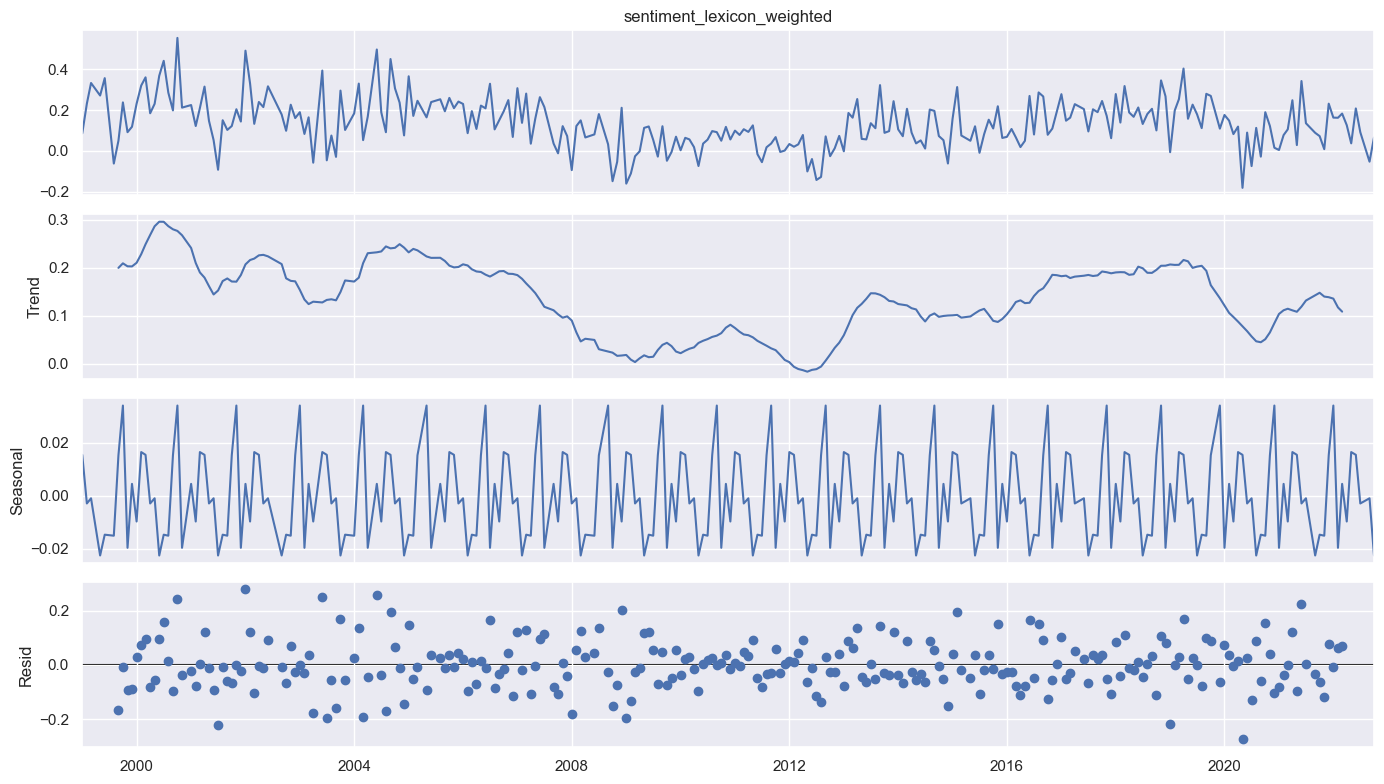

In [450]:
# Perform decomposition
boe_sentiment_decomposed = seasonal_decompose(boe_sentiment_monthly['sentiment_lexicon_weighted'], model='additive', period=12)

# Plot the decomposition
boe_sentiment_decomposed.plot()
plt.show()

**Observations Peaks**
- August 2013: Peak with a speech announcing Jane Austen on 10 GBP note and a discussion of the evolution of monetary policy since 2008-2009 crisis
- January 2022: speech about inflation with a sense of urgency about controlling inflation with reassurance that the Bank is actively monitoring and prepared to act responsibly. 

In [453]:
# Copy the data to prepare it quarterly
boe_sentiment_quarterly = boe_indicators_1999_2022.groupby('year_month_dt')[['sentiment_lexicon_weighted']].mean().reset_index()

In [455]:
# Extract year and quarter
boe_sentiment_quarterly['year'] = boe_sentiment_quarterly['year_month_dt'].dt.year
boe_sentiment_quarterly['quarter'] = boe_sentiment_quarterly['year_month_dt'].dt.quarter

# Group by year and quarter
boe_sentiment_quarterly = boe_sentiment_quarterly.groupby(['year', 'quarter'])[['sentiment_lexicon_weighted']].mean().reset_index()

# Create a 'quarter_start' date if needed
boe_sentiment_quarterly['quarter_start'] = pd.to_datetime(boe_sentiment_quarterly['year'].astype(str) + 'Q' \
                                                          + boe_sentiment_quarterly['quarter'].astype(str))

# View the DataFrame
boe_sentiment_quarterly.head()

year  quarter  sentiment_lexicon_weighted quarter_start
0  1999        1                    0.216520    1999-01-01
1  1999        2                    0.313675    1999-04-01
2  1999        3                   -0.006232    1999-07-01
3  1999        4                    0.148963    1999-10-01
4  2000        1                    0.303788    2000-01-01

In [457]:
# Set the datetime as index
boe_sentiment_quarterly.set_index('quarter_start', inplace=True)

# View the DataFrame
boe_sentiment_quarterly

year  quarter  sentiment_lexicon_weighted
quarter_start                                           
1999-01-01     1999        1                    0.216520
1999-04-01     1999        2                    0.313675
1999-07-01     1999        3                   -0.006232
1999-10-01     1999        4                    0.148963
2000-01-01     2000        1                    0.303788
...             ...      ...                         ...
2021-10-01     2021        4                    0.103875
2022-01-01     2022        1                    0.169176
2022-04-01     2022        2                    0.123447
2022-07-01     2022        3                    0.019141
2022-10-01     2022        4                    0.065534

[96 rows x 3 columns]

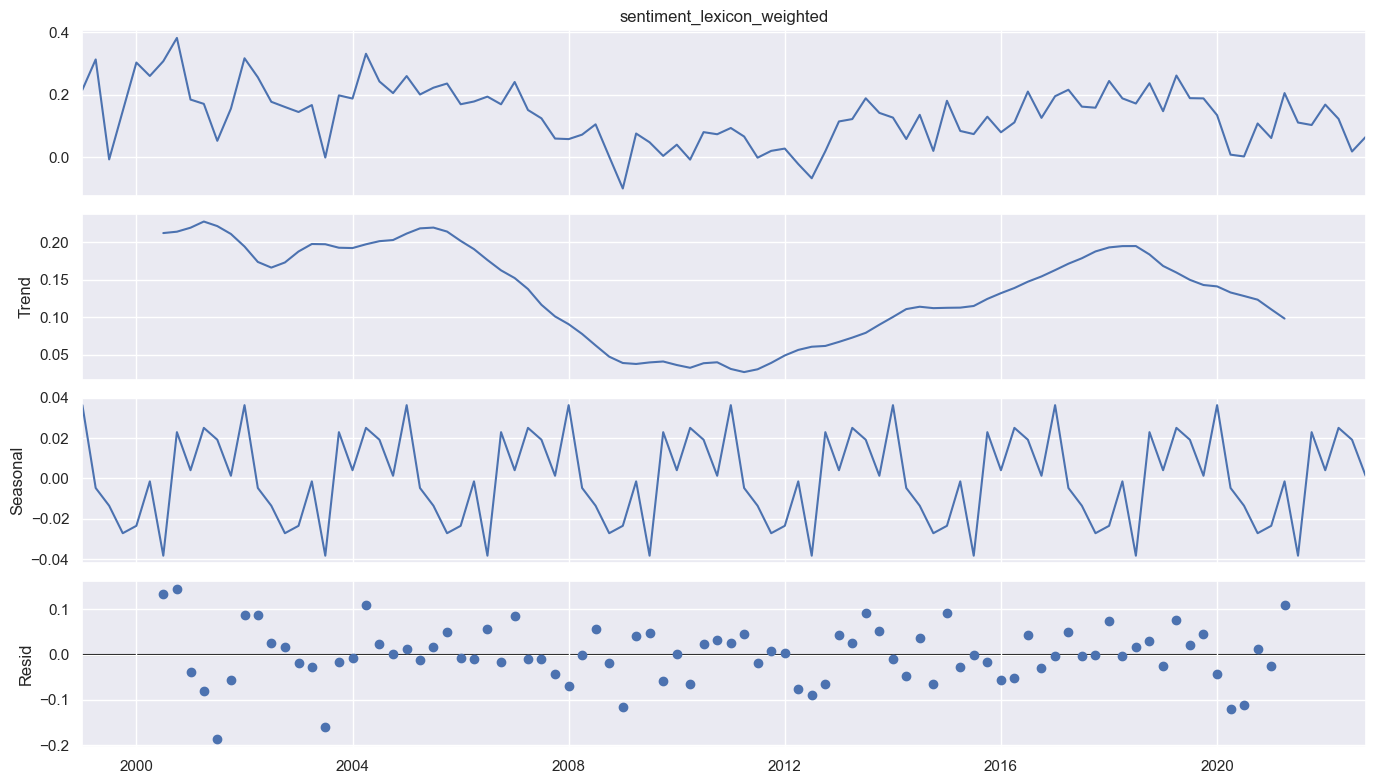

In [459]:
# Perform decomposition
boe_sentiment_decomposed_quarterly = seasonal_decompose(boe_sentiment_quarterly['sentiment_lexicon_weighted'], \
                                                        model='additive', period=12)

# Plot the decomposition
boe_sentiment_decomposed_quarterly.plot()
plt.show()

**3.4.b. BoE Governor Analysis**

In [462]:
# Filter speeches for governors only
boe_indicators_1999_2022_gov = boe_indicators_1999_2022[boe_indicators_1999_2022['is_gov'] == 1]

# View the DataFrame
boe_indicators_1999_2022_gov.head()

index     reference         country date_format year_month  year  \
0      8  r990112a_BOE  united kingdom  1999-01-12    1999-01  1999   
1      9  r990118a_BOE  united kingdom  1999-01-18    1999-01  1999   
2     10  r990201a_BOE  united kingdom  1999-02-01    1999-02  1999   
3     11  r990210a_BOE  united kingdom  1999-02-10    1999-02  1999   
4     12  r990218a_BOE  united kingdom  1999-02-18    1999-02  1999   

  year_month_dt                     title  author  is_gov  ...  \
0    1999-01-01                    Speech  george       1  ...   
1    1999-01-01                    Speech  george       1  ...   
2    1999-02-01                    Speech  george       1  ...   
3    1999-02-01                    Speech  george       1  ...   
4    1999-02-01  The Chancellor's Lecture  george       1  ...   

  uk_interest_rate uk_consumer_confidence gbp_usd_fx     ftse_250  \
0              6.0                   -3.6   1.650910  4904.934033   
1              6.0                   -3.6   1.650910  4904.934033   
2              5.5                   -1.6   1.627565  5192.548511   
3              5.5                   -1.6   1.627565  5192.548511   
4              5.5                   -1.6   1.627565  5192.548511   

   gilts_short   gilts_medium   gilts_long   uk_credit_growth_no_cc  \
0          4.30           4.24         4.32                    13.5   
1          4.30           4.24         4.32                    13.5   
2          4.45           4.39         4.42                    13.2   
3          4.45           4.39         4.42                    13.2   
4          4.45           4.39         4.42                    13.2   

   uk_credit_growth_only_cc  avg_price_all_property_types  
0                      26.1                         67157  
1                      26.1                         67157  
2                      26.1                         67157  
3                      26.1                         67157  
4                      26.1                         67157  

[5 rows x 32 columns]

In [464]:
# Group and aggregate sentiment scores by month
boe_sentiment_gov_monthly = boe_indicators_1999_2022_gov.groupby('year_month_dt')[['sentiment_lexicon_weighted']] \
                                                                            .mean().reset_index()
# View the DataFrame
boe_sentiment_gov_monthly.head()

year_month_dt  sentiment_lexicon_weighted
0    1999-01-01                    0.085728
1    1999-02-01                    0.231430
2    1999-03-01                    0.145802
3    1999-05-01                    0.256614
4    1999-06-01                    0.244156

In [466]:
# Set the datetime as index
boe_sentiment_gov_monthly.set_index('year_month_dt', inplace=True)

# View the DataFrame
boe_sentiment_gov_monthly.head()

sentiment_lexicon_weighted
year_month_dt                            
1999-01-01                       0.085728
1999-02-01                       0.231430
1999-03-01                       0.145802
1999-05-01                       0.256614
1999-06-01                       0.244156

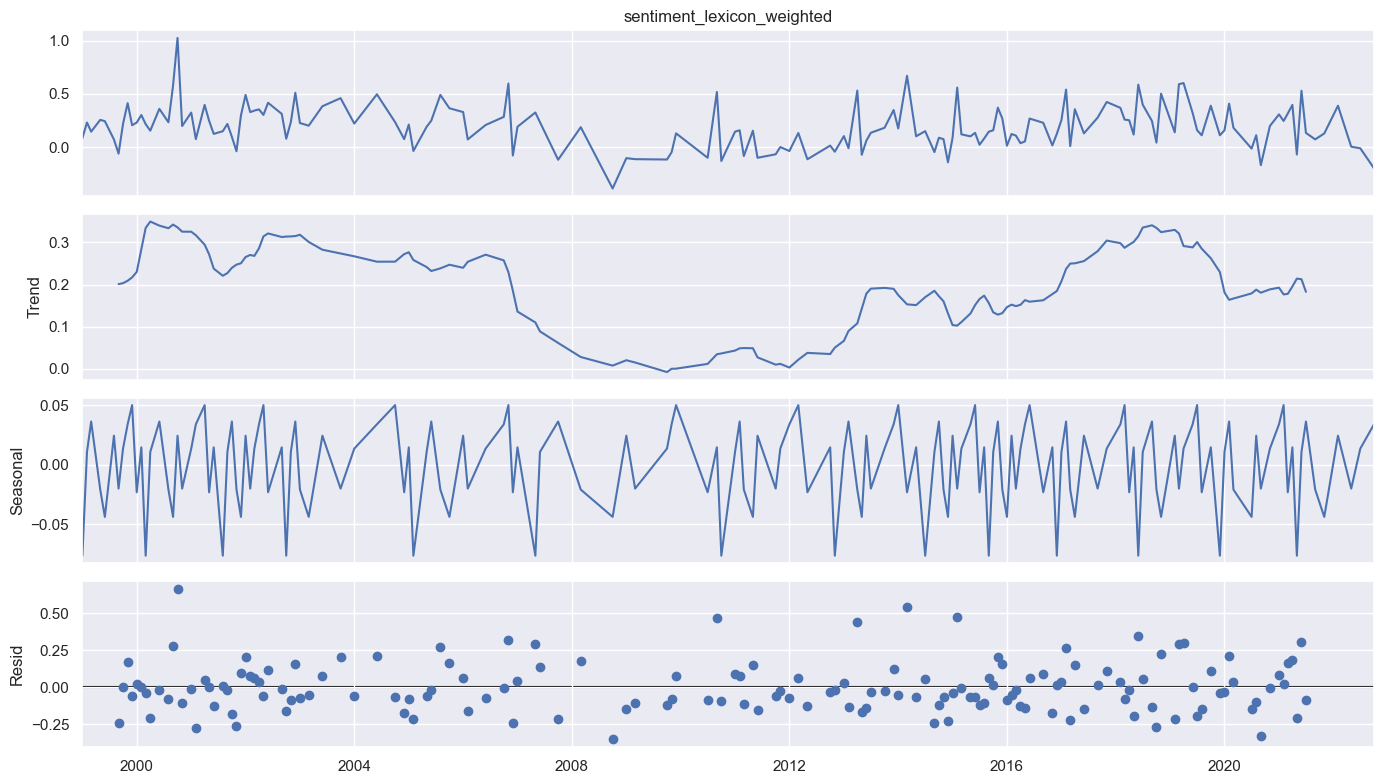

In [468]:
# Perform decomposition
boe_sentiment_gov_decomposed = seasonal_decompose(boe_sentiment_gov_monthly['sentiment_lexicon_weighted'], model='additive', period=12)

# Plot the decomposition
boe_sentiment_gov_decomposed.plot()
plt.show()

**Obersvations**: trend in governor speeches more positive - only during and following financial crisis is sentiment as negative

**3.4.c. All speeches and countries**

In [470]:
# Group and aggregate sentiment scores by month
sentiment_quarterly = speeches_1999_2022.groupby(['year_month_dt', 'country'])[['sentiment_lexicon_weighted']].mean().reset_index()

# View the DataFrame.
sentiment_quarterly.head()

year_month_dt         country  sentiment_lexicon_weighted
0    1999-01-01          canada                    0.290551
1    1999-01-01       euro area                    0.348793
2    1999-01-01          sweden                    0.273480
3    1999-01-01     switzerland                    0.326246
4    1999-01-01  united kingdom                    0.085728

In [472]:
# Extract year and quarter
sentiment_quarterly['year'] = sentiment_quarterly['year_month_dt'].dt.year
sentiment_quarterly['quarter'] = sentiment_quarterly['year_month_dt'].dt.quarter

# Group by year and quarter
sentiment_quarterly = sentiment_quarterly.groupby(['year', 'quarter', 'country'])[['sentiment_lexicon_weighted']].mean().reset_index()

# Create a 'quarter_start' date if needed
sentiment_quarterly['quarter_start'] = pd.to_datetime(sentiment_quarterly['year'].astype(str) + 'Q' \
                                                      + sentiment_quarterly['quarter'].astype(str))

# View the DataFrame
sentiment_quarterly

year  quarter         country  sentiment_lexicon_weighted quarter_start
0    1999        1       australia                    0.192661    1999-01-01
1    1999        1          canada                    0.241694    1999-01-01
2    1999        1       euro area                    0.353401    1999-01-01
3    1999        1           japan                    0.023971    1999-01-01
4    1999        1          sweden                    0.166323    1999-01-01
..    ...      ...             ...                         ...           ...
746  2022        4       euro area                   -0.082410    2022-10-01
747  2022        4           japan                    0.143825    2022-10-01
748  2022        4     switzerland                    0.015589    2022-10-01
749  2022        4  united kingdom                    0.065534    2022-10-01
750  2022        4   united states                    0.147327    2022-10-01

[751 rows x 5 columns]

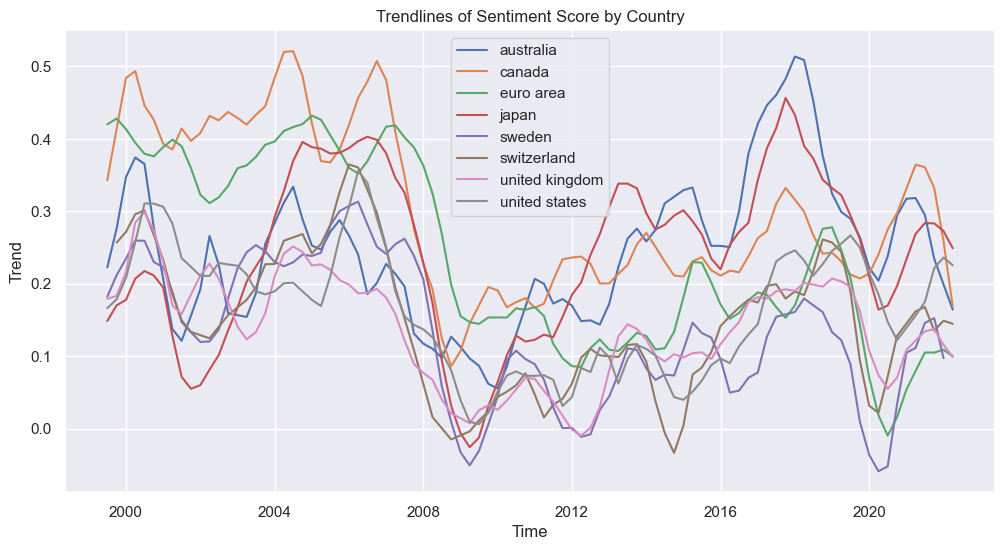

In [474]:
# Plot the trend chart for all countries
plt.figure(figsize=(12, 6))

for country, group in sentiment_quarterly.groupby('country'):
    # Set date as index
    group = group.set_index('quarter_start').sort_index()
    
    # Check for missing dates or gaps, handle if needed

    # Decompose to get trend
    result = seasonal_decompose(group['sentiment_lexicon_weighted'], model='additive', period=4)

    # Plot the trend
    plt.plot(group.index, result.trend, label=country)
    
plt.legend()
plt.title('Trendlines of Sentiment Score by Country')
plt.xlabel('Time')
plt.ylabel('Trend')
plt.show()

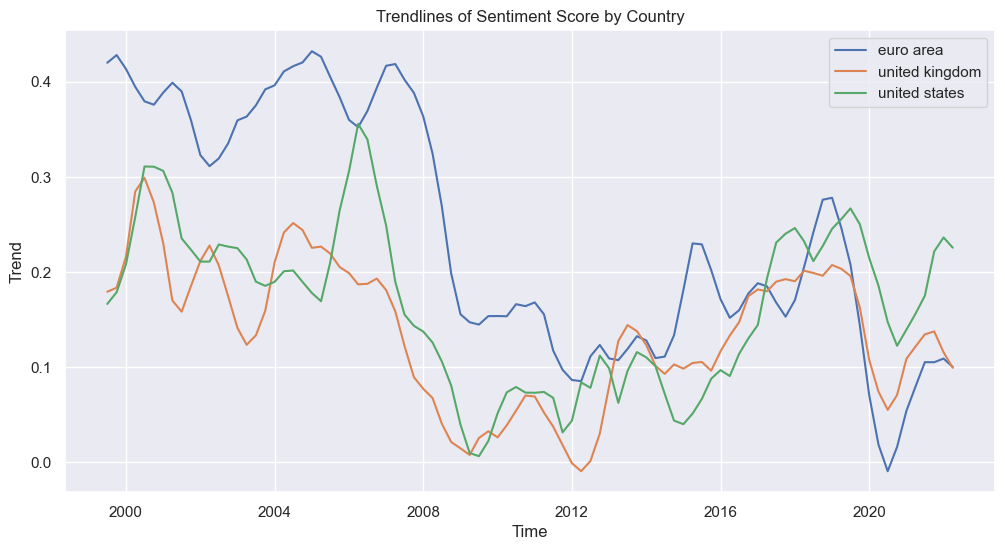

In [476]:
# Plot the trend chart only for UK, USA, Euro Area and Australia
plt.figure(figsize=(12, 6))

for country, group in sentiment_quarterly[sentiment_quarterly['country'].isin(countries_to_display)].groupby('country'):
    # Set date as index
    group = group.set_index('quarter_start').sort_index()
    
    # Check for missing dates or gaps, handle if needed

    # Decompose to get trend
    result = seasonal_decompose(group['sentiment_lexicon_weighted'], model='additive', period=4)

    # Plot the trend
    plt.plot(group.index, result.trend, label=country)
    
plt.legend()
plt.title('Trendlines of Sentiment Score by Country')
plt.xlabel('Time')
plt.ylabel('Trend')
plt.show()

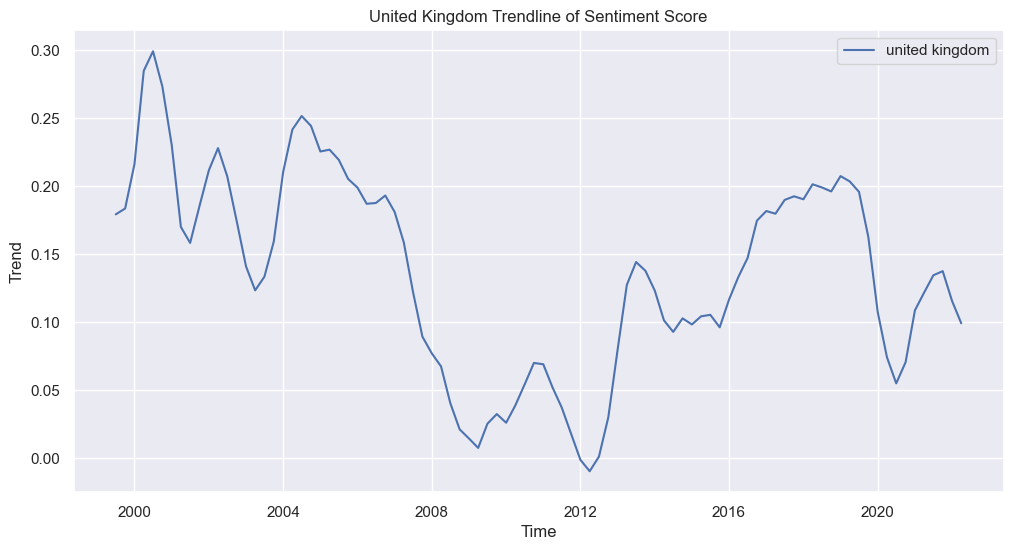

In [480]:
# PLot the chart for UK only
plt.figure(figsize=(12, 6))

for country, group in sentiment_quarterly[sentiment_quarterly['country'].isin(country_to_display)].groupby('country'):
    # Set date as index
    group = group.set_index('quarter_start').sort_index()
    
    # Check for missing dates or gaps, handle if needed

    # Decompose to get trend
    result = seasonal_decompose(group['sentiment_lexicon_weighted'], model='additive', period=4)

    # Plot the trend
    plt.plot(group.index, result.trend, label=country)
    
plt.legend()
plt.title('United Kingdom Trendline of Sentiment Score')
plt.xlabel('Time')
plt.ylabel('Trend')
plt.show()

### 3.5. Topic Analysis

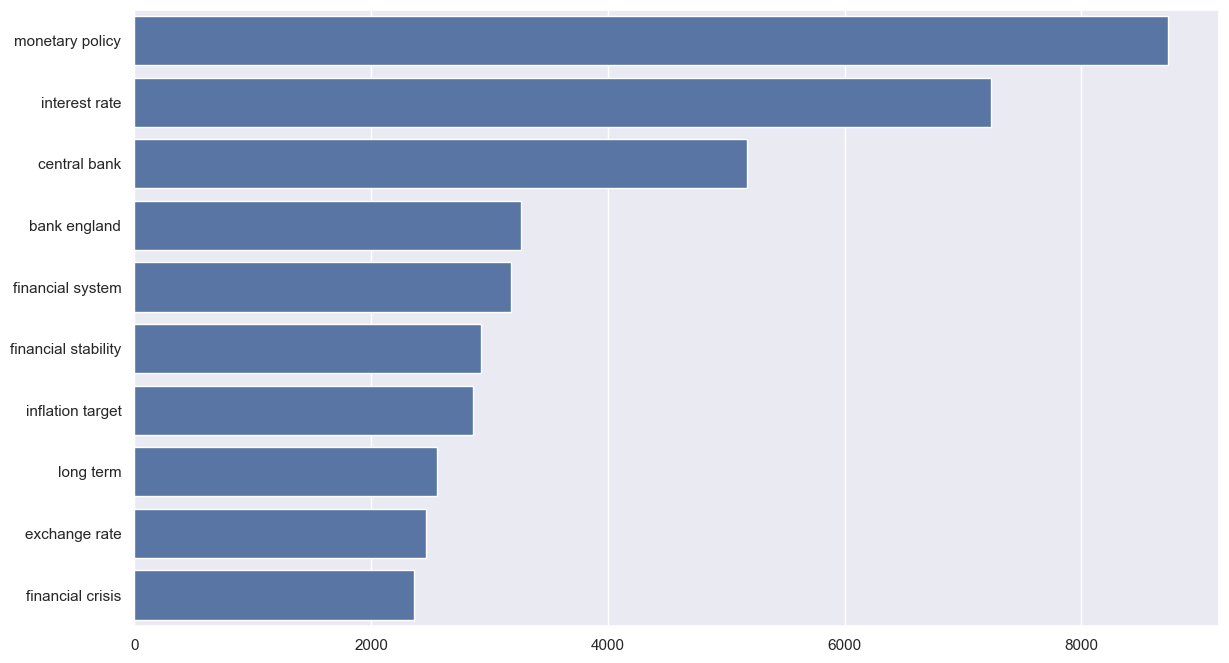

In [482]:
# Plot top phrases with 2 words
top_word_group_barchart(boe_indicators_1999_2022['text_lemmatised_str'],2)

In [483]:
# Let's say 'top_bigrams' is your list of most common bigram strings
top_bigrams = ['monetary policy', 'interest rate', ' central bank', 'financial system', 'financial stability', 'inflation target', \
              'long term', 'financial crisis', 'balance sheet', 'exchange rate']  # Replace with actual bigrams

# Initialize a dictionary to store counts
bigram_counts = {bigram: 0 for bigram in top_bigrams}

# Loop through speeches and count how many contain each bigram
for index, row in boe_indicators_1999_2022.iterrows():
    speech_text = row['text_lemmatised_str'].lower()
    for bigram in top_bigrams:
        if bigram in speech_text:
            bigram_counts[bigram] += 1

# Convert to DataFrame for better visualization
bigram_counts_boe = pd.DataFrame(bigram_counts.items(), columns=['Bigram', 'Count']).sort_values(by='Count', ascending=False)

# View the DataFrame
bigram_counts_boe

Bigram  Count
0      monetary policy    839
1        interest rate    816
2         central bank    745
6            long term    730
3     financial system    663
7     financial crisis    659
4  financial stability    579
8        balance sheet    569
5     inflation target    541
9        exchange rate    428

**Calculating number of bigrams per speech**

In [484]:
# Bigrams to search for
target_bigrams = ['monetary policy', 'interest rate', 'financial stability', 'inflation target', 'financial crisis', 'exchange rate']

# Fit CountVectorizer on all speeches
vectorizer = CountVectorizer(ngram_range=(2, 2))
X = vectorizer.fit_transform(boe_indicators_1999_2022['text_lemmatised_str'].str.lower())

# Create a DataFrame of counts
bigram_counts_df = pd.DataFrame(X.toarray(), index=boe_indicators_1999_2022.index, columns=vectorizer.get_feature_names_out())

# For each target bigram, add a column with its count
for bigram in target_bigrams:
    if bigram in bigram_counts_df.columns:
        boe_indicators_1999_2022[f'{bigram}'] = bigram_counts_df[bigram]
    else:
        # Bigram not found in the data
        boe_indicators_1999_2022[f'{bigram}'] = 0

**Bigrams in speech more than 5 times**

In [ ]:
# Filter speeches with 'monetary policy' > 5
boe_monetary_policy = boe_indicators_1999_2022[boe_indicators_1999_2022['monetary policy'] > 5]

In [ ]:
monetary_policy_avg_yearly = boe_monetary_policy.groupby('year')['sentiment_lexicon_weighted'].mean().reset_index()
monetary_policy_avg_yearly.rename(columns={'sentiment_lexicon_weighted': 'Monetary Policy'}, inplace=True)

In [ ]:
# Filter speeches with 'interest rate' > 5
boe_interest_rate = boe_indicators_1999_2022[boe_indicators_1999_2022['interest rate'] > 5]

In [ ]:
interest_rate_avg_yearly = boe_interest_rate.groupby('year')['sentiment_lexicon_weighted'].mean().reset_index()
interest_rate_avg_yearly.rename(columns={'sentiment_lexicon_weighted': 'Interest Rate'}, inplace=True)

In [ ]:
# Filter speeches with 'financial stability' > 5
boe_financial_stability = boe_indicators_1999_2022[boe_indicators_1999_2022['financial stability'] > 5]

In [ ]:
financial_stability_avg_yearly = boe_financial_stability.groupby('year')['sentiment_lexicon_weighted'].mean().reset_index()
financial_stability_avg_yearly.rename(columns={'sentiment_lexicon_weighted': 'Financial Stability'}, inplace=True)

In [ ]:
# Filter speeches with 'inflation target' > 5
boe_inflation_target = boe_indicators_1999_2022[boe_indicators_1999_2022['inflation target'] > 5]

In [ ]:
inflation_target_avg_yearly = boe_inflation_target.groupby('year')['sentiment_lexicon_weighted'].mean().reset_index()
inflation_target_avg_yearly.rename(columns={'sentiment_lexicon_weighted': 'Inflation Target'}, inplace=True)

In [ ]:
# Filter speeches with 'financial crisis' > 5
boe_financial_crisis = boe_indicators_1999_2022[boe_indicators_1999_2022['financial crisis'] > 5]

In [ ]:
financial_crisis_avg_yearly = boe_financial_crisis.groupby('year')['sentiment_lexicon_weighted'].mean().reset_index()
financial_crisis_avg_yearly.rename(columns={'sentiment_lexicon_weighted': 'Financial Crisis'}, inplace=True)

In [ ]:
# Filter speeches with 'financial crisis' > 5
boe_exchange_rate = boe_indicators_1999_2022[boe_indicators_1999_2022['exchange rate'] > 5]

In [ ]:
exchange_rate_avg_yearly = boe_exchange_rate.groupby('year')['sentiment_lexicon_weighted'].mean().reset_index()
exchange_rate_avg_yearly.rename(columns={'sentiment_lexicon_weighted': 'Exchange Rate'}, inplace=True)

In [ ]:
# List of DataFrames to merge
dataframes_to_merge = [interest_rate_avg_yearly, financial_stability_avg_yearly, inflation_target_avg_yearly, \
                       financial_crisis_avg_yearly, exchange_rate_avg_yearly]

# Use reduce to merge all DataFrames in the list
sentiment_by_topic = reduce(lambda left, right: left.merge(right, on='year', how='left'), dataframes_to_merge, monetary_policy_avg_yearly)

# View the merged DataFrame
sentiment_by_topic.head()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# List your score columns
score_columns = ['Monetary Policy', 'Interest Rate', 'Financial Stability', 'Inflation Target', 'Financial Crisis']

for col in score_columns:
    plt.plot(sentiment_by_topic['year'], sentiment_by_topic[col], label=col)

plt.xlabel('Year')
plt.ylabel('Score')
plt.title('Scores Over Years')
plt.legend()
plt.show()

**Bigrams in speech more than 10 times**

In [494]:
# Filter speeches with 'monetary policy' > 10
boe_monetary_policy_10 = boe_indicators_1999_2022[boe_indicators_1999_2022['monetary policy'] > 10]

In [496]:
# Filter speeches with 'interest rate' > 10
boe_interest_rate_10 = boe_indicators_1999_2022[boe_indicators_1999_2022['interest rate'] > 10]

In [497]:
# Filter speeches with 'interest rate' > 10
boe_financial_stability_10 = boe_indicators_1999_2022[boe_indicators_1999_2022['financial stability'] >10]

In [498]:
# Filter speeches with 'inflation target' > 10
boe_inflation_target_10 = boe_indicators_1999_2022[boe_indicators_1999_2022['inflation target'] > 10]

In [499]:
# Filter speeches with 'inflation target' > 10
boe_financial_crisis_10 = boe_indicators_1999_2022[boe_indicators_1999_2022['financial crisis'] > 10]

In [500]:
# Filter speeches with 'inflation target' > 10
boe_exchange_rate_10 = boe_indicators_1999_2022[boe_indicators_1999_2022['exchange rate'] > 10]

**Data grouped by year** for
- average sentiment score
- total number of mentions
- number of speechs that include the bigram
- number of mentiones per seech that include bigram

In [537]:
monetary_policy_10_avg_yearly = boe_monetary_policy_10.groupby('year').agg({
    'sentiment_lexicon_weighted': 'mean',
    'monetary policy': ['sum', 'count', 'mean']
}).reset_index()

# Rename the sentiment column
monetary_policy_10_avg_yearly.rename(columns={'sentiment_lexicon_weighted': 'sentiment_montary_policy'}, inplace=True)

# Flatten hierarchical columns
monetary_policy_10_avg_yearly.columns = ['_'.join(col).strip() for col in monetary_policy_10_avg_yearly.columns.values]

In [539]:
interest_rate_10_avg_yearly = boe_interest_rate_10.groupby('year').agg({
    'sentiment_lexicon_weighted': 'mean',
    'interest rate': ['sum', 'count', 'mean']
}).reset_index()

# Rename the sentiment column
interest_rate_10_avg_yearly.rename(columns={'sentiment_lexicon_weighted': 'sentiment_interest_rate'}, inplace=True)

# Flatten hierarchical columns
interest_rate_10_avg_yearly.columns = ['_'.join(col).strip() for col in interest_rate_10_avg_yearly.columns.values]

In [541]:
financial_stability_10_avg_yearly = boe_financial_stability_10.groupby('year').agg({
    'sentiment_lexicon_weighted': 'mean',
    'financial stability': ['sum', 'count', 'mean']
}).reset_index()

# Rename the sentiment column
financial_stability_10_avg_yearly.rename(columns={'sentiment_lexicon_weighted': 'sentiment_financial_stability'}, inplace=True)

# Flatten hierarchical columns
financial_stability_10_avg_yearly.columns = ['_'.join(col).strip() for col in financial_stability_10_avg_yearly.columns.values]

In [543]:
inflation_target_10_avg_yearly = boe_inflation_target_10.groupby('year').agg({
    'sentiment_lexicon_weighted': 'mean',
    'inflation target': ['sum', 'count', 'mean']
}).reset_index()

# Rename the sentiment column
inflation_target_10_avg_yearly.rename(columns={'sentiment_lexicon_weighted': 'sentiment_inflation_target'}, inplace=True)

# Flatten hierarchical columns
inflation_target_10_avg_yearly.columns = ['_'.join(col).strip() for col in inflation_target_10_avg_yearly.columns.values]

In [545]:
financial_crisis_10_avg_yearly = boe_financial_crisis_10.groupby('year').agg({
    'sentiment_lexicon_weighted': 'mean',
    'financial crisis': ['sum', 'count', 'mean']
}).reset_index()

# Rename the sentiment column
financial_crisis_10_avg_yearly.rename(columns={'sentiment_lexicon_weighted': 'sentiment_financial_crisis'}, inplace=True)

# Flatten hierarchical columns
financial_crisis_10_avg_yearly.columns = ['_'.join(col).strip() for col in financial_crisis_10_avg_yearly.columns.values]

In [656]:
exchange_rate_10_avg_yearly = boe_exchange_rate_10.groupby('year').agg({
    'sentiment_lexicon_weighted': 'mean',
    'exchange rate': ['sum', 'count', 'mean']
}).reset_index()

# Rename the sentiment column
exchange_rate_10_avg_yearly.rename(columns={'sentiment_lexicon_weighted': 'sentiment_exchange_rate'}, inplace=True)

# Flatten hierarchical columns
exchange_rate_10_avg_yearly.columns = ['_'.join(col).strip() for col in exchange_rate_10_avg_yearly.columns.values]

In [658]:
# List of DataFrames to merge
dataframes_to_merge = [interest_rate_10_avg_yearly, financial_stability_10_avg_yearly, inflation_target_10_avg_yearly, \
                       financial_crisis_10_avg_yearly, exchange_rate_10_avg_yearly]

# Use reduce to merge all DataFrames in the list
sentiment_by_topic_10 = reduce(lambda left, right: left.merge(right, on='year_', how='left'), dataframes_to_merge, monetary_policy_10_avg_yearly)

# Rename the year column
sentiment_by_topic_10.rename(columns={'year_': 'year'}, inplace=True)

# View the merged DataFrame
sentiment_by_topic_10.head()

year  sentiment_montary_policy_mean  monetary policy_sum  \
0  1999                       0.210901                  231   
1  2000                       0.294427                  161   
2  2001                       0.082977                  107   
3  2002                       0.152509                  186   
4  2003                       0.051797                  185   

   monetary policy_count  monetary policy_mean  sentiment_interest_rate_mean  \
0                      9             25.666667                      0.167894   
1                      8             20.125000                      0.242870   
2                      7             15.285714                     -0.009596   
3                      9             20.666667                      0.185330   
4                      5             37.000000                      0.056963   

   interest rate_sum  interest rate_count  interest rate_mean  \
0                284                    8           35.500000   
1                141                    6           23.500000   
2                130                    6           21.666667   
3                338                   13           26.000000   
4                192                    6           32.000000   

   sentiment_financial_stability_mean  ...  inflation target_count  \
0                            0.445985  ...                     4.0   
1                            0.185691  ...                     2.0   
2                            0.142246  ...                     NaN   
3                                 NaN  ...                     5.0   
4                            0.108403  ...                     3.0   

   inflation target_mean  sentiment_financial_crisis_mean  \
0              20.250000                        -0.128622   
1              20.500000                              NaN   
2                    NaN                              NaN   
3              17.800000                              NaN   
4              30.666667                              NaN   

   financial crisis_sum  financial crisis_count  financial crisis_mean  \
0                  29.0                     2.0                   14.5   
1                   NaN                     NaN                    NaN   
2                   NaN                     NaN                    NaN   
3                   NaN                     NaN                    NaN   
4                   NaN                     NaN                    NaN   

   sentiment_exchange_rate_mean  exchange rate_sum  exchange rate_count  \
0                      0.176839              197.0                  4.0   
1                      0.273693              156.0                  5.0   
2                      0.142656              111.0                  5.0   
3                      0.109249              145.0                  5.0   
4                      0.001722               25.0                  2.0   

   exchange rate_mean  
0               49.25  
1               31.20  
2               22.20  
3               29.00  
4               12.50  

[5 rows x 25 columns]

In [660]:
# List your score columns
sentiment_columns = ['sentiment_montary_policy_mean', 'sentiment_interest_rate_mean', 'sentiment_financial_stability_mean', 
                 'sentiment_inflation_target_mean', 'sentiment_financial_crisis_mean', 'sentiment_exchange_rate_mean']

# List your score columns
bigram_count = ['monetary policy_count', 'interest rate_count', 'financial stability_count', 
                 'inflation target_count', 'financial crisis_count', 'exchange rate_count']

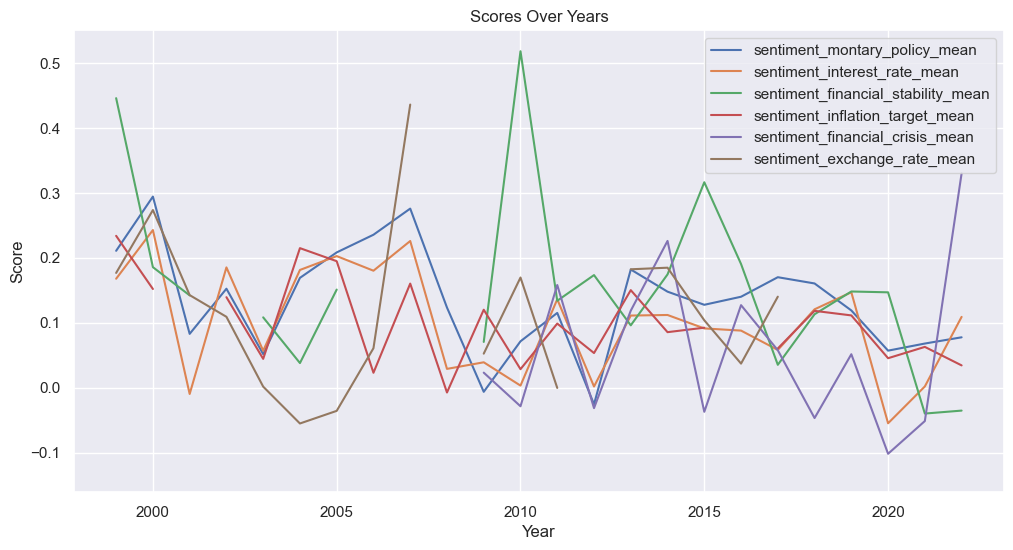

In [662]:
plt.figure(figsize=(12, 6))

for col in sentiment_columns:
    plt.plot(sentiment_by_topic_10['year'], sentiment_by_topic_10[col], label=col)

plt.xlabel('Year')
plt.ylabel('Score')
plt.title('Scores Over Years')
plt.legend()
plt.show()

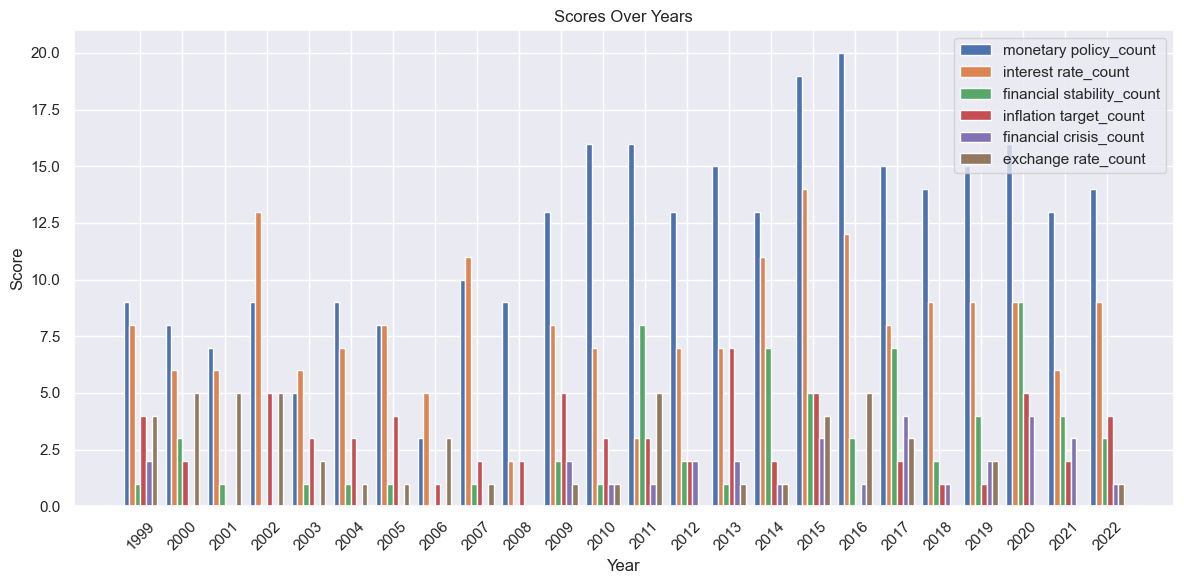

In [663]:
# Number of years and topics
years = sentiment_by_topic_10['year']
topics = sentiment_columns
n_years = len(years)
n_topics = len(topics)

# Set bar width
bar_width = 0.8 / n_topics  # Total width divided among topics
x = np.arange(n_years)  # Positions for each year

plt.figure(figsize=(12, 6))

for i, col in enumerate(score_columns):
    # Offset positions for each topic
    offset = (i - n_topics / 2) * bar_width + bar_width/2
    plt.bar(x + offset, sentiment_by_topic_10[col], width=bar_width, label=col)

plt.xlabel('Year')
plt.ylabel('Score')
plt.title('Scores Over Years')
plt.xticks(x, years, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

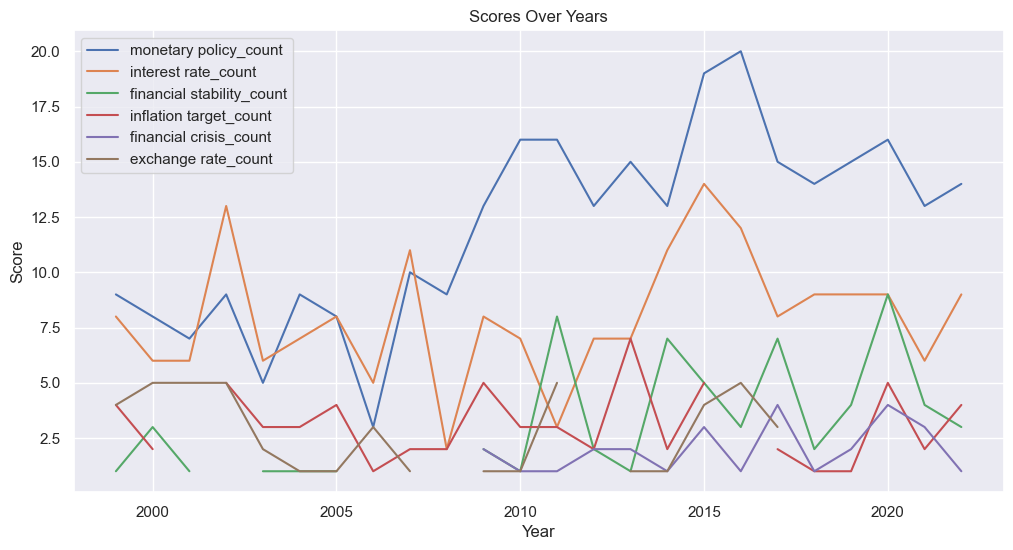

In [666]:
plt.figure(figsize=(12, 6))

for col in bigram_count:
    plt.plot(sentiment_by_topic_10['year'], sentiment_by_topic_10[col], label=col)

plt.xlabel('Year')
plt.ylabel('Score')
plt.title('Scores Over Years')
plt.legend()
plt.show()

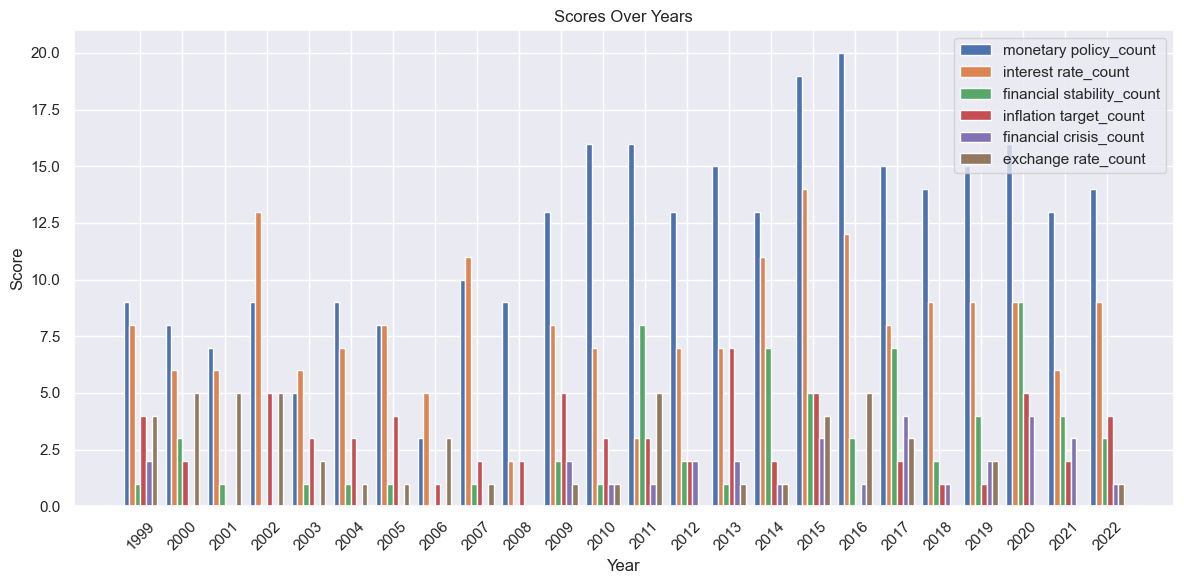

In [670]:
# Number of years and topics
years = sentiment_by_topic_10['year']
topics = bigram_count
n_years = len(years)
n_topics = len(topics)

# Set bar width
bar_width = 0.8 / n_topics  # Total width divided among topics
x = np.arange(n_years)  # Positions for each year

plt.figure(figsize=(12, 6))

for i, col in enumerate(score_columns):
    # Offset positions for each topic
    offset = (i - n_topics / 2) * bar_width + bar_width/2
    plt.bar(x + offset, sentiment_by_topic_10[col], width=bar_width, label=col)

plt.xlabel('Year')
plt.ylabel('Score')
plt.title('Scores Over Years')
plt.xticks(x, years, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

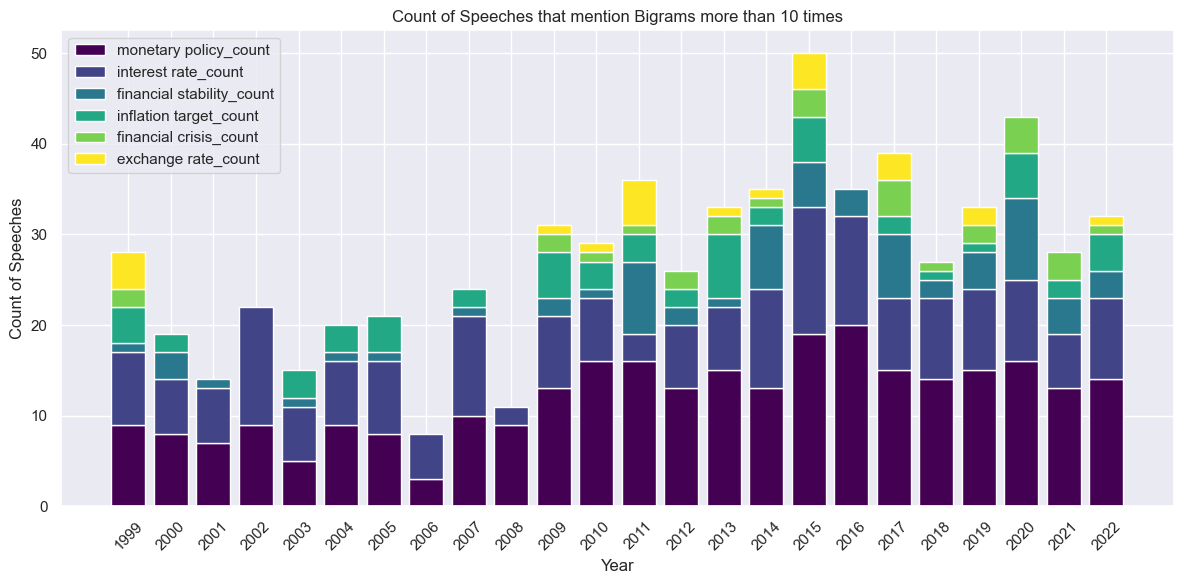

In [849]:
# Generate Viridis colors for each bar segment
num_colors = len(bigram_count)  # or len(sentiment_by_topic_10.columns)
colors = cm.get_cmap('viridis', num_colors).colors

# Set figure size
plt.figure(figsize=(12, 6))

# X positions
indices = np.arange(len(sentiment_by_topic_10['year']))

# Initialize the bottom for stacking
bottoms = np.zeros(len(sentiment_by_topic_10))

# Plot each column as stacked bars
for i, col in enumerate(bigram_count):
    plt.bar(indices, sentiment_by_topic_10[col], bottom=bottoms, color=colors[i], label=col)
    # Update bottoms for stacking
    bottoms += sentiment_by_topic_10[col]

# Set x labels
plt.xlabel('Year')
plt.ylabel('Count of Speeches')
plt.title('Count of Speeches that mention Bigrams more than 10 times')
plt.xticks(indices, sentiment_by_topic_10['year'], rotation=45)

plt.legend(loc='upper left', bbox_to_anchor=(0, 1))
plt.tight_layout()
plt.show()

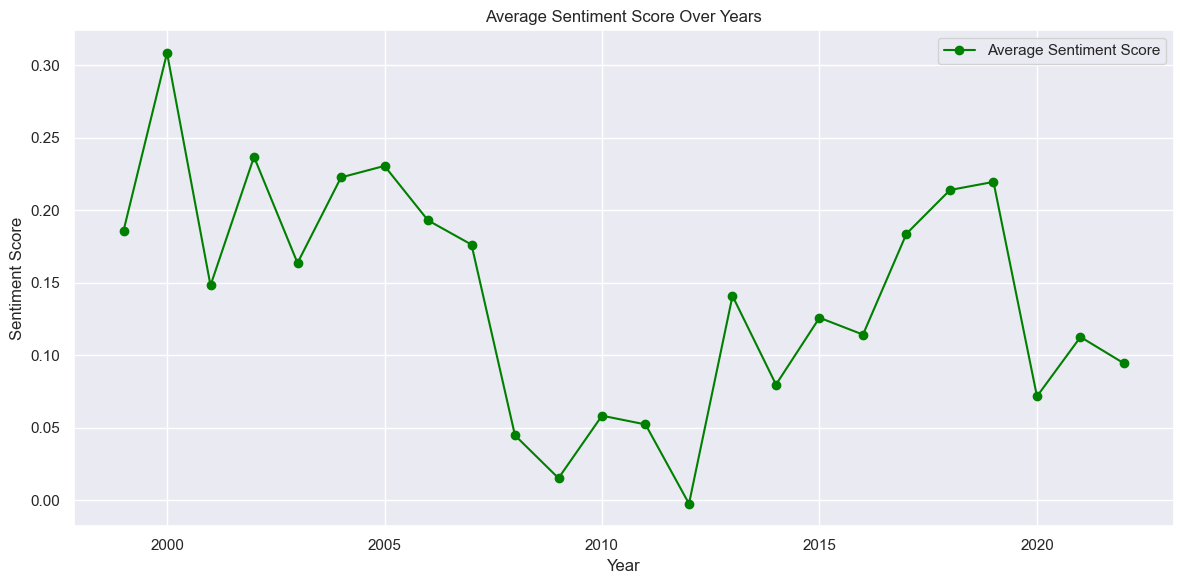

In [676]:
plt.figure(figsize=(12, 6))
plt.plot(
    boe_speeches_1999_2022_yearly['year'],
    boe_speeches_1999_2022_yearly['sentiment_lexicon_weighted'],
    color='green',
    marker='o',
    label='Average Sentiment Score'
)

plt.xlabel('Year')
plt.ylabel('Sentiment Score')
plt.title('Average Sentiment Score Over Years')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [714]:
sentiment_by_topic_10_weighted = pd.merge(sentiment_by_topic_10, boe_speeches_1999_2022_yearly[['year', 'sentiment_lexicon_weighted']], on='year', how='left')

sentiment_by_topic_10_weighted.head()

year  sentiment_montary_policy_mean  monetary policy_sum  \
0  1999                       0.210901                  231   
1  2000                       0.294427                  161   
2  2001                       0.082977                  107   
3  2002                       0.152509                  186   
4  2003                       0.051797                  185   

   monetary policy_count  monetary policy_mean  sentiment_interest_rate_mean  \
0                      9             25.666667                      0.167894   
1                      8             20.125000                      0.242870   
2                      7             15.285714                     -0.009596   
3                      9             20.666667                      0.185330   
4                      5             37.000000                      0.056963   

   interest rate_sum  interest rate_count  interest rate_mean  \
0                284                    8           35.500000   
1                141                    6           23.500000   
2                130                    6           21.666667   
3                338                   13           26.000000   
4                192                    6           32.000000   

   sentiment_financial_stability_mean  ...  inflation target_mean  \
0                            0.445985  ...              20.250000   
1                            0.185691  ...              20.500000   
2                            0.142246  ...                    NaN   
3                                 NaN  ...              17.800000   
4                            0.108403  ...              30.666667   

   sentiment_financial_crisis_mean  financial crisis_sum  \
0                        -0.128622                  29.0   
1                              NaN                   NaN   
2                              NaN                   NaN   
3                              NaN                   NaN   
4                              NaN                   NaN   

   financial crisis_count  financial crisis_mean  \
0                     2.0                   14.5   
1                     NaN                    NaN   
2                     NaN                    NaN   
3                     NaN                    NaN   
4                     NaN                    NaN   

   sentiment_exchange_rate_mean  exchange rate_sum  exchange rate_count  \
0                      0.176839              197.0                  4.0   
1                      0.273693              156.0                  5.0   
2                      0.142656              111.0                  5.0   
3                      0.109249              145.0                  5.0   
4                      0.001722               25.0                  2.0   

   exchange rate_mean  sentiment_lexicon_weighted  
0               49.25                    0.185937  
1               31.20                    0.308585  
2               22.20                    0.148234  
3               29.00                    0.236919  
4               12.50                    0.163706  

[5 rows x 26 columns]

In [716]:
# Replace NaN with 0
sentiment_by_topic_10_weighted.fillna(value=0, inplace=True)

# View the DataFrame
sentiment_by_topic_10_weighted.head()

year  sentiment_montary_policy_mean  monetary policy_sum  \
0  1999                       0.210901                  231   
1  2000                       0.294427                  161   
2  2001                       0.082977                  107   
3  2002                       0.152509                  186   
4  2003                       0.051797                  185   

   monetary policy_count  monetary policy_mean  sentiment_interest_rate_mean  \
0                      9             25.666667                      0.167894   
1                      8             20.125000                      0.242870   
2                      7             15.285714                     -0.009596   
3                      9             20.666667                      0.185330   
4                      5             37.000000                      0.056963   

   interest rate_sum  interest rate_count  interest rate_mean  \
0                284                    8           35.500000   
1                141                    6           23.500000   
2                130                    6           21.666667   
3                338                   13           26.000000   
4                192                    6           32.000000   

   sentiment_financial_stability_mean  ...  inflation target_mean  \
0                            0.445985  ...              20.250000   
1                            0.185691  ...              20.500000   
2                            0.142246  ...               0.000000   
3                            0.000000  ...              17.800000   
4                            0.108403  ...              30.666667   

   sentiment_financial_crisis_mean  financial crisis_sum  \
0                        -0.128622                  29.0   
1                         0.000000                   0.0   
2                         0.000000                   0.0   
3                         0.000000                   0.0   
4                         0.000000                   0.0   

   financial crisis_count  financial crisis_mean  \
0                     2.0                   14.5   
1                     0.0                    0.0   
2                     0.0                    0.0   
3                     0.0                    0.0   
4                     0.0                    0.0   

   sentiment_exchange_rate_mean  exchange rate_sum  exchange rate_count  \
0                      0.176839              197.0                  4.0   
1                      0.273693              156.0                  5.0   
2                      0.142656              111.0                  5.0   
3                      0.109249              145.0                  5.0   
4                      0.001722               25.0                  2.0   

   exchange rate_mean  sentiment_lexicon_weighted  
0               49.25                    0.185937  
1               31.20                    0.308585  
2               22.20                    0.148234  
3               29.00                    0.236919  
4               12.50                    0.163706  

[5 rows x 26 columns]

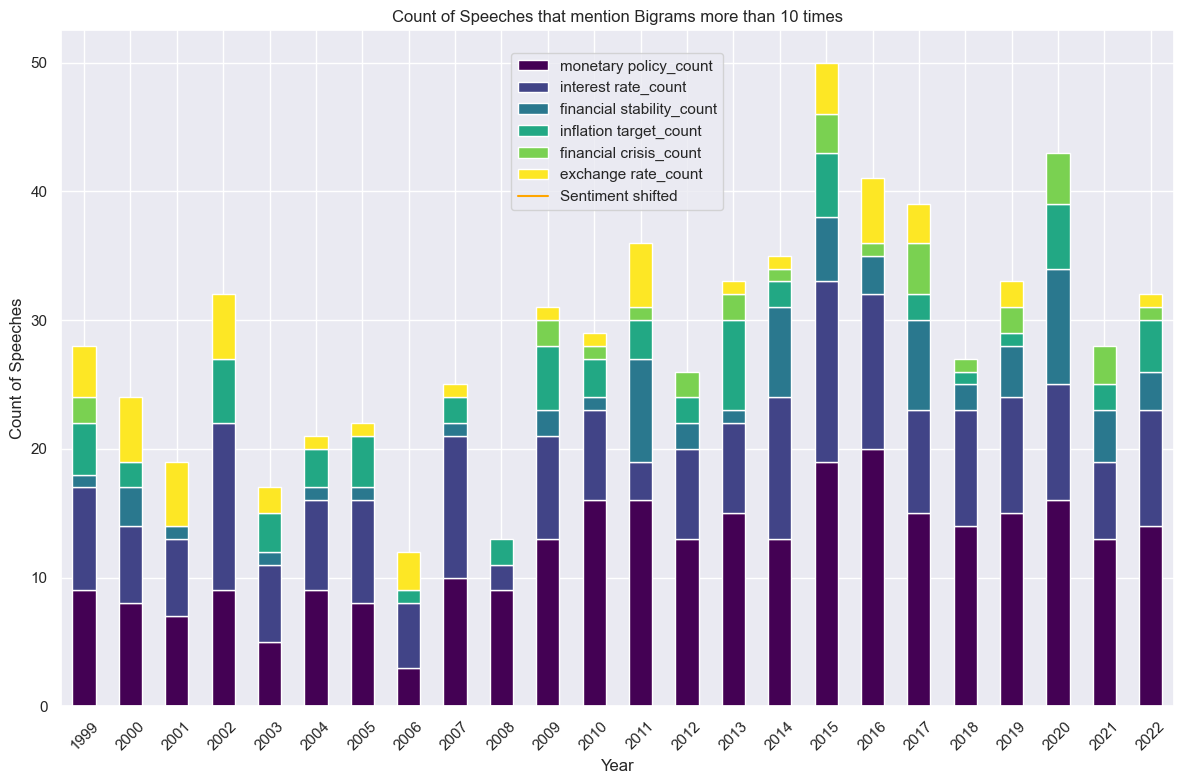

In [851]:
# Generate Viridis colors for each bar segment
num_colors = len(bigram_count)  # or len(sentiment_by_topic_10.columns)
colors = cm.get_cmap('viridis', num_colors).colors

# Plot the stacked bar chart
ax = sentiment_by_topic_10_weighted[bigram_count].plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    color=colors
)

# Explicitly set x-ticks to correspond to each bar group
ax.set_xticks(range(len(sentiment_by_topic_10_weighted)))
ax.set_xticklabels(sentiment_by_topic_10_weighted['year'], rotation=45)

# Set labels
ax.set_xlabel('Year')
ax.set_ylabel('Count of Speeches')

# Title
plt.title('Count of Speeches that mention Bigrams more than 10 times')

# Get handle for bar and line plots
handles, labels = ax.get_legend_handles_labels()
line_handles, line_labels = ax2.get_legend_handles_labels()

# Combine both handles and labels
handles += line_handles
labels += line_labels

# Show combined legend
ax.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, 0.85))

# Display the graph
plt.tight_layout()
plt.show()

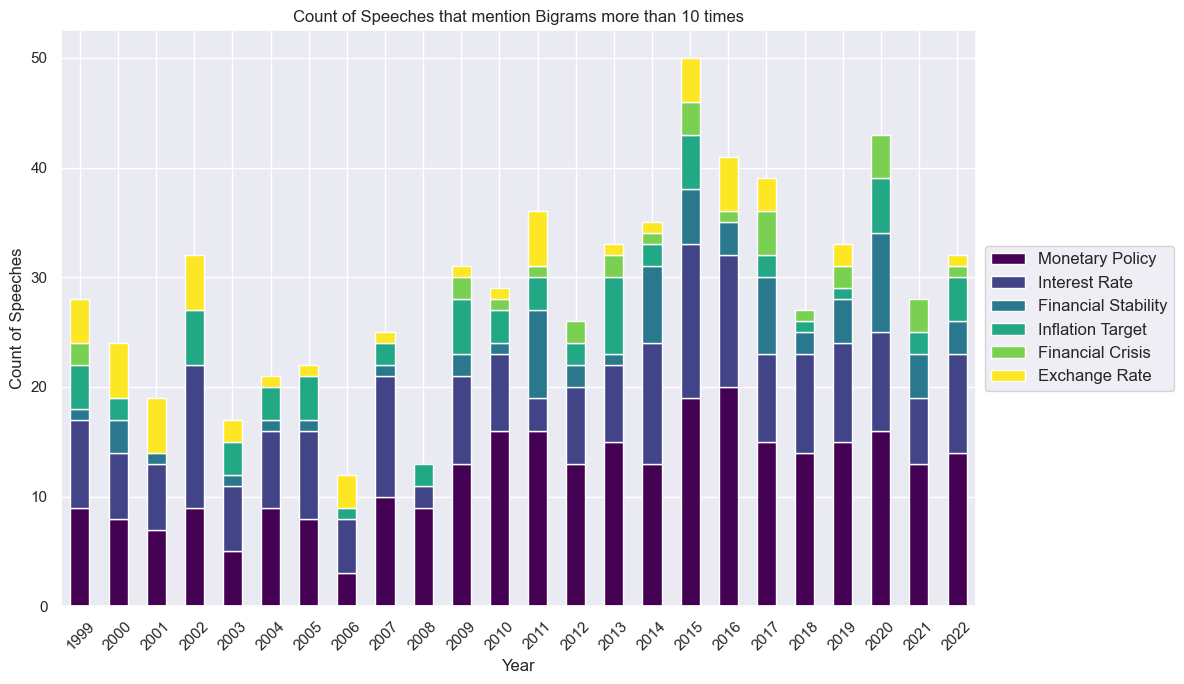

In [885]:
# Plot the stacked bar chart
ax = sentiment_by_topic_10_weighted[bigram_count].plot(
    kind='bar',
    stacked=True,
    figsize=(12, 7),
    color=colors
)

# Set x-ticks and labels
ax.set_xticks(range(len(sentiment_by_topic_10_weighted)))
ax.set_xticklabels(sentiment_by_topic_10_weighted['year'], rotation=45)

# Set axis labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Count of Speeches')
plt.title('Count of Speeches that mention Bigrams more than 10 times')

# Get current legend handles and labels
handles, labels = ax.get_legend_handles_labels()

# Create your custom labels
custom_labels = ['Monetary Policy', 'Interest Rate', 'Financial Stability', 'Inflation Target', 'Financial Crisis', 'Exchange Rate']
# Make sure the length matches the number of handles

# Assign custom labels to labels variable
labels = custom_labels

# Move legend to the right
ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

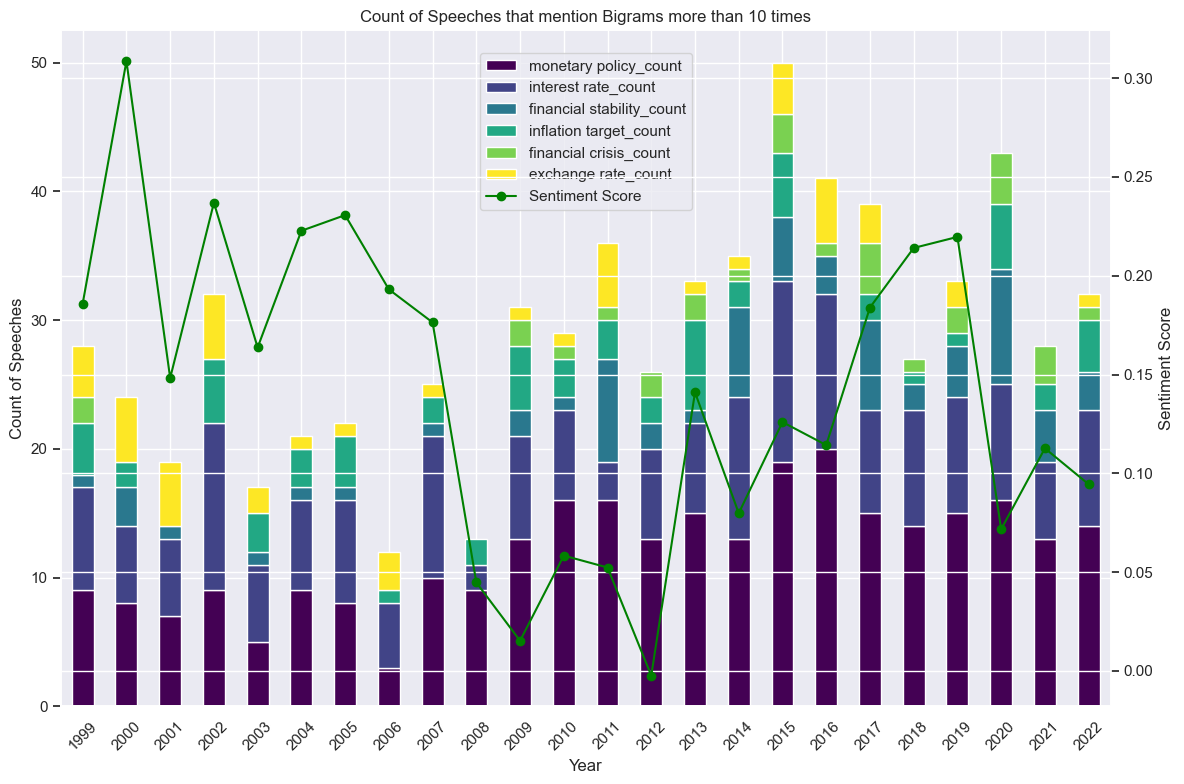

In [752]:
# Generate Viridis colors for each bar segment
num_colors = len(bigram_count)  # or len(sentiment_by_topic_10.columns)
colors = cm.get_cmap('viridis', num_colors).colors

# Plot the stacked bar chart
ax = sentiment_by_topic_10_weighted[bigram_count].plot(
    kind='bar',
    stacked=True,
    figsize=(12, 8),
    color=colors
)

# Create a secondary axis sharing the same x-axis
ax2 = ax.twinx()

# Plot the line on the secondary axis
ax2.plot(
    range(len(sentiment_by_topic_10_weighted)),
    sentiment_by_topic_10_weighted['sentiment_lexicon_weighted'],
    color='green',
    marker='o',
    label='Sentiment Score'
)

# Explicitly set x-ticks to correspond to each bar group
ax.set_xticks(range(len(sentiment_by_topic_10_weighted)))
ax.set_xticklabels(sentiment_by_topic_10_weighted['year'], rotation=45)

# Set labels
ax.set_xlabel('Year')
ax.set_ylabel('Count of Speeches')
ax2.set_ylabel('Sentiment Score')

# Title
plt.title('Count of Speeches that mention Bigrams more than 10 times')

# Get handle for bar and line plots
handles, labels = ax.get_legend_handles_labels()
line_handles, line_labels = ax2.get_legend_handles_labels()

# Combine both handles and labels
handles += line_handles
labels += line_labels

# Show combined legend
ax.legend(handles, labels, loc='center', bbox_to_anchor=(0.5, 0.85))

# Display the graph
plt.tight_layout()
plt.show()

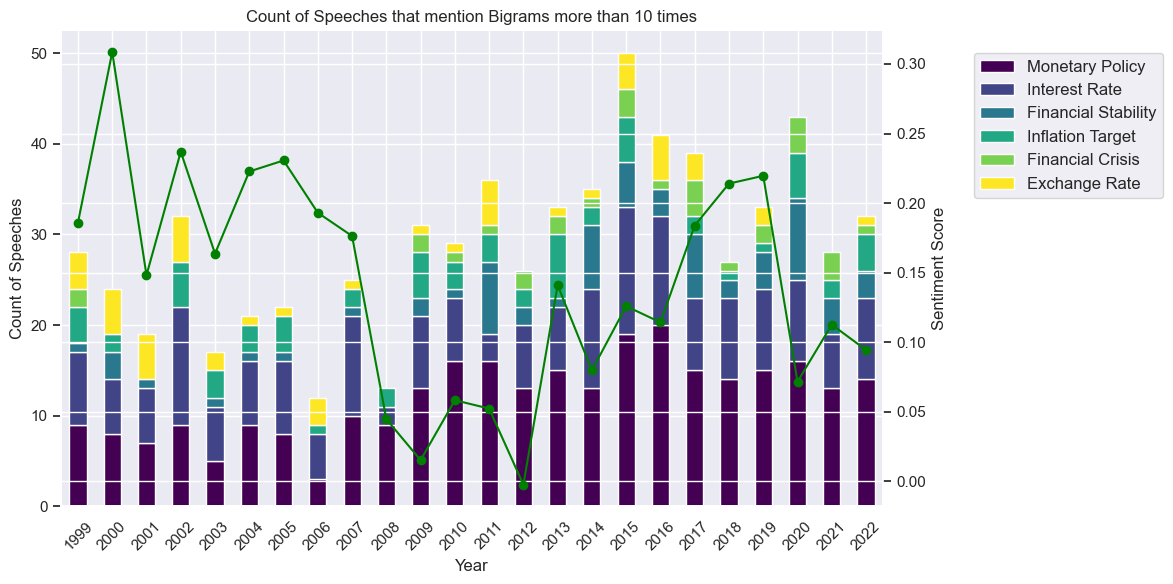

In [901]:
# Generate Viridis colors for each bar segment
num_colors = len(bigram_count)  # or len(sentiment_by_topic_10.columns)
colors = cm.get_cmap('viridis', num_colors).colors

# Plot the stacked bar chart
ax = sentiment_by_topic_10_weighted[bigram_count].plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    color=colors
)

# Create a secondary axis sharing the same x-axis
ax2 = ax.twinx()

# Plot the line on the secondary axis
ax2.plot(
    range(len(sentiment_by_topic_10_weighted)),
    sentiment_by_topic_10_weighted['sentiment_lexicon_weighted'],
    color='green',
    marker='o',
    label='Sentiment Score'
)

# Explicitly set x-ticks to correspond to each bar group
ax.set_xticks(range(len(sentiment_by_topic_10_weighted)))
ax.set_xticklabels(sentiment_by_topic_10_weighted['year'], rotation=45)

# Set labels
ax.set_xlabel('Year')
ax.set_ylabel('Count of Speeches')
ax2.set_ylabel('Sentiment Score')

# Title
plt.title('Count of Speeches that mention Bigrams more than 10 times')

# Get handle for bar and line plots
handles, labels = ax.get_legend_handles_labels()
line_handles, line_labels = ax2.get_legend_handles_labels()

# Combine both handles and labels
handles += line_handles
labels += line_labels

# Create your custom labels
custom_labels = ['Monetary Policy', 'Interest Rate', 'Financial Stability', 'Inflation Target', 'Financial Crisis', 'Exchange Rate']
# Make sure the length matches the number of handles

# Assign custom labels to labels variable
labels = custom_labels

# Move legend to the right
ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1.1, 0.8), fontsize=12)


# Display the graph
plt.tight_layout()
plt.show()

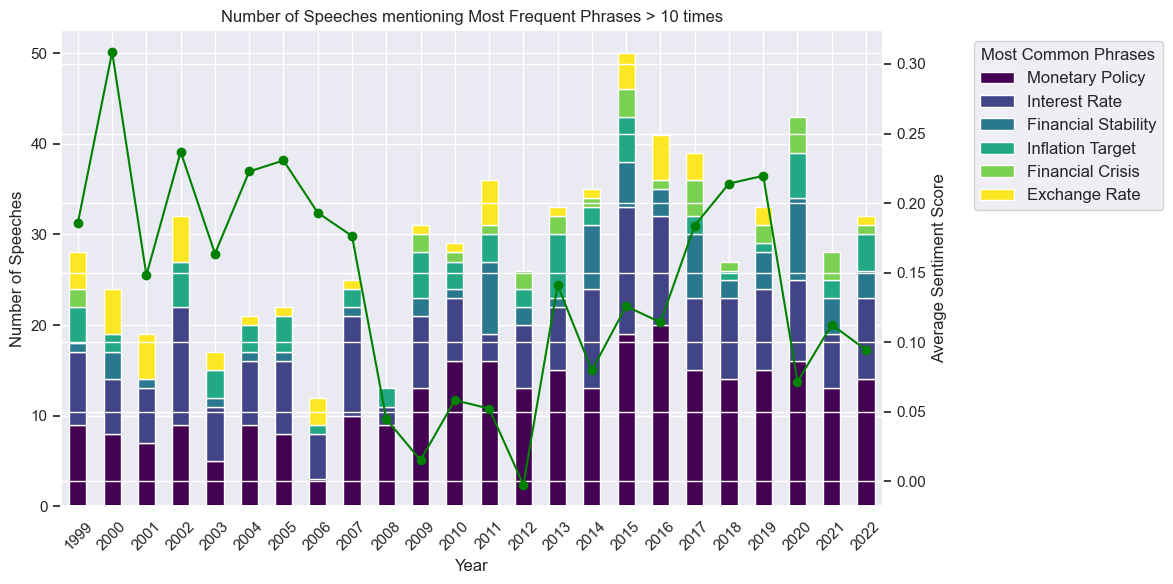

In [919]:
# Plot the stacked bar chart
ax = sentiment_by_topic_10_weighted[bigram_count].plot(
    kind='bar',
    stacked=True,
    figsize=(12, 6),
    color=colors,
    zorder=2  # Bars are on top
)

# Create secondary axis sharing the same x-axis
ax2 = ax.twinx()

# Plot the sentiment line
ax2.plot(
    range(len(sentiment_by_topic_10_weighted)),
    sentiment_by_topic_10_weighted['sentiment_lexicon_weighted'],
    color='green',
    marker='o',
    label='Sentiment Score',
    zorder=3  # Line is above bars
)

# Now, send the tick lines and spines of ax2 behind the bars

# Send the tick lines of ax2 behind
ax2.tick_params(zorder=1)  # Lower zorder so ticks are behind bars

# Send spines (border lines) of ax2 behind
for spine in ax2.spines.values():
    spine.set_zorder(1)

# Synchronize tick positions for better alignment (optional)
ax.set_xticks(range(len(sentiment_by_topic_10_weighted)))
ax.set_xticklabels(sentiment_by_topic_10_weighted['year'], rotation=45)

# Set labels
ax.set_xlabel('Year')
ax.set_ylabel('Number of Speeches')
ax2.set_ylabel('Average Sentiment Score')

# Title
plt.title('Number of Speeches mentioning Most Frequent Phrases > 10 times')

# Legend handles and labels
handles, labels = ax.get_legend_handles_labels()
line_handles, line_labels = ax2.get_legend_handles_labels()

# Combine legends
handles += line_handles
labels += line_labels

# Custom labels
custom_labels = ['Monetary Policy', 'Interest Rate', 'Financial Stability', 'Inflation Target', 'Financial Crisis', 'Exchange Rate']
labels = custom_labels

# Position legend to the right
ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1.1, 0.8), fontsize=12, title='Most Common Phrases')

plt.tight_layout()
plt.show()

In [489]:
boe_indicators_1999_2022.columns

Index(['index', 'reference', 'country', 'date_format', 'year_month', 'year',
       'year_month_dt', 'title', 'author', 'is_gov', 'text', 'text_lemmatised',
       'text_lemmatised_str', 'word_count_text', 'word_count_text_cleaned',
       'sentiment_lexicon_simple', 'sentiment_lexicon_simple_std',
       'sentiment_lexicon_weighted', 'sentiment_lexicon_weighted_std',
       'uk_inflation_rate_CPIH', 'uk_unemployment_rate', 'uk_gdp_growth',
       'uk_interest_rate', 'uk_consumer_confidence', 'gbp_usd_fx', 'ftse_250',
       'gilts_short ', 'gilts_medium ', 'gilts_long ',
       'uk_credit_growth_no_cc', 'uk_credit_growth_only_cc',
       'avg_price_all_property_types', 'monetary policy', 'interest rate',
       'financial stability', 'inflation target', 'financial crisis',
       'exchange rate'],
      dtype='object')

In [492]:
boe_indicators_1999_2022.head()

index     reference         country date_format year_month  year  \
0      8  r990112a_BOE  united kingdom  1999-01-12    1999-01  1999   
1      9  r990118a_BOE  united kingdom  1999-01-18    1999-01  1999   
2     10  r990201a_BOE  united kingdom  1999-02-01    1999-02  1999   
3     11  r990210a_BOE  united kingdom  1999-02-10    1999-02  1999   
4     12  r990218a_BOE  united kingdom  1999-02-18    1999-02  1999   

  year_month_dt                     title  author  is_gov  ... gilts_long   \
0    1999-01-01                    Speech  george       1  ...        4.32   
1    1999-01-01                    Speech  george       1  ...        4.32   
2    1999-02-01                    Speech  george       1  ...        4.42   
3    1999-02-01                    Speech  george       1  ...        4.42   
4    1999-02-01  The Chancellor's Lecture  george       1  ...        4.42   

  uk_credit_growth_no_cc uk_credit_growth_only_cc  \
0                   13.5                     26.1   
1                   13.5                     26.1   
2                   13.2                     26.1   
3                   13.2                     26.1   
4                   13.2                     26.1   

   avg_price_all_property_types  monetary policy  interest rate  \
0                         67157                7              1   
1                         67157                8              4   
2                         67157                8              1   
3                         67157                2              1   
4                         67157               21              8   

   financial stability  inflation target  financial crisis  exchange rate  
0                    0                 1                 0              7  
1                    0                 2                 0              5  
2                    0                 0                 0              4  
3                    0                 0                 0              3  
4                    0                 9                 0              7  

[5 rows x 38 columns]

**Monthly Analysis**

In [ ]:
monetary_policy_10_avg_monthly = boe_monetary_policy_10.groupby('year_month')['sentiment_lexicon_weighted'].mean().reset_index()
monetary_policy_10_avg_monthly.rename(columns={'sentiment_lexicon_weighted': 'Monetary Policy'}, inplace=True)

In [ ]:
interest_rate_10_avg_monthly = boe_interest_rate_10.groupby('year_month')['sentiment_lexicon_weighted'].mean().reset_index()
interest_rate_10_avg_monthly.rename(columns={'sentiment_lexicon_weighted': 'Interest Rate'}, inplace=True)

In [ ]:
financial_stability_10_avg_monthly = boe_financial_stability_10.groupby('year_month')['sentiment_lexicon_weighted'].mean().reset_index()
financial_stability_10_avg_monthly.rename(columns={'sentiment_lexicon_weighted': 'Financial Stability'}, inplace=True)

In [ ]:
inflation_target_10_avg_monthly = boe_inflation_target_10.groupby('year_month')['sentiment_lexicon_weighted'].mean().reset_index()
inflation_target_10_avg_monthly.rename(columns={'sentiment_lexicon_weighted': 'Inflation Target'}, inplace=True)

In [ ]:
financial_crisis_10_avg_monthly = boe_financial_crisis_10.groupby('year_month')['sentiment_lexicon_weighted'].mean().reset_index()
financial_crisis_10_avg_monthly.rename(columns={'sentiment_lexicon_weighted': 'Financial Crisis'}, inplace=True)

In [ ]:
exchange_rate_10_avg_monthly = boe_exchange_rate_10.groupby('year_month')['sentiment_lexicon_weighted'].mean().reset_index()
exchange_rate_10_avg_monthly.rename(columns={'sentiment_lexicon_weighted': 'Exchange Rate'}, inplace=True)

In [ ]:
# List of DataFrames to merge
dataframes_to_merge = [interest_rate_10_avg_monthly, financial_stability_10_avg_monthly, inflation_target_10_avg_monthly, \
                       financial_crisis_10_avg_monthly, exchange_rate_10_avg_monthly]

# Use reduce to merge all DataFrames in the list
sentiment_by_topic_10 = reduce(lambda left, right: left.merge(right, on='year_month', how='left'), dataframes_to_merge, monetary_policy_10_avg_monthly)

# View the merged DataFrame
sentiment_by_topic_10.head()

In [ ]:
# Filter for months before and after global financial crisis
sentiment_by_topic_10_crisis = sentiment_by_topic_10[(sentiment_by_topic_10['year_month'] >= '2008-03') & (sentiment_by_topic_10['year_month'] <= '2009-03')].reset_index()

# View the DataFrame
sentiment_by_topic_10_crisis 

In [ ]:
# Filter for months before and after brexit
sentiment_by_topic_10_brexit = sentiment_by_topic_10[(sentiment_by_topic_10['year_month'] >= '2016-01') & (sentiment_by_topic_10['year_month'] <= '2016-12')].reset_index()

# View the DataFrame
sentiment_by_topic_10_brexit 

In [ ]:
# Filter for months before and after covid
sentiment_by_topic_10_covid = sentiment_by_topic_10[(sentiment_by_topic_10['year_month'] >= '2019-09') & (sentiment_by_topic_10['year_month'] <= '2020-09')].reset_index()

# View the DataFrame
sentiment_by_topic_10_covid

**Calculation of count**

In [517]:
boe_indicators_1999_2022.describe()

index                    date_format         year  \
count  1201.000000                           1201  1201.000000   
mean    608.000000  2012-11-20 07:12:50.358034944  2012.397169   
min       8.000000            1999-01-12 00:00:00  1999.000000   
25%     308.000000            2008-07-15 00:00:00  2008.000000   
50%     608.000000            2013-12-11 00:00:00  2013.000000   
75%     908.000000            2018-02-26 00:00:00  2018.000000   
max    1208.000000            2022-10-20 00:00:00  2022.000000   
std     346.843144                            NaN     6.414667   

                       year_month_dt       is_gov  word_count_text  \
count                           1201  1201.000000      1201.000000   
mean   2012-11-04 02:03:29.825145600     0.200666      4280.969192   
min              1999-01-01 00:00:00     0.000000       231.000000   
25%              2008-07-01 00:00:00     0.000000      2562.000000   
50%              2013-12-01 00:00:00     0.000000      3674.000000   
75%              2018-02-01 00:00:00     0.000000      5015.000000   
max              2022-10-01 00:00:00     1.000000     37522.000000   
std                              NaN     0.400666      3195.407040   

       word_count_text_cleaned  sentiment_lexicon_simple  \
count              1201.000000               1201.000000   
mean               2412.530391                 -0.083511   
min                 121.000000                 -0.532051   
25%                1405.000000                 -0.184971   
50%                2047.000000                 -0.098958   
75%                2815.000000                 -0.002985   
max               23119.000000                  0.628571   
std                1924.344932                  0.151936   

       sentiment_lexicon_simple_std  sentiment_lexicon_weighted  ...  \
count                   1201.000000                 1201.000000  ...   
mean                      -0.334396                    0.130766  ...   
min                       -2.838660                   -0.423899  ...   
25%                       -0.900863                   -0.005789  ...   
50%                       -0.420642                    0.110776  ...   
75%                        0.115190                    0.236519  ...   
max                        3.641258                    1.025714  ...   
std                        0.848278                    0.201263  ...   

       gilts_long   uk_credit_growth_no_cc  uk_credit_growth_only_cc  \
count  1201.000000             1201.000000               1201.000000   
mean      3.072011                5.637968                  6.762781   
min       0.596199               -4.800000                -20.700000   
25%       1.872535                0.000000                  3.600000   
50%       3.160957                6.800000                  5.500000   
75%       4.340346               10.500000                  9.100000   
max       5.030000               14.600000                 26.100000   
std       1.278984                5.412168                  8.219756   

       avg_price_all_property_types  monetary policy  interest rate  \
count                   1201.000000      1201.000000    1201.000000   
mean                  172266.033306         7.269775       6.027477   
min                    67157.000000         0.000000       0.000000   
25%                   153306.000000         0.000000       0.000000   
50%                   169800.000000         3.000000       2.000000   
75%                   207385.000000        10.000000       7.000000   
max                   265727.000000       133.000000     130.000000   
std                    43799.628002        11.106927      11.649181   

       financial stability  inflation target  financial crisis  exchange rate  
count          1201.000000       1201.000000       1201.000000    1201.000000  
mean              2.439634          2.383014          1.970025       2.051624  
min               0.000000          0.000000          0.000000      

In [ ]:
boe_indicators_1999_2022

In [ ]:
# Filter for months before and after covid
boe_indicators_1999 = boe_indicators_1999_2022[(boe_indicators_1999_2022['year_month'] >= '1999-01') & (boe_indicators_1999_2022['year_month'] <= '1999-12')].reset_index()

boe_indicators_1999

## 4. Exploratory Analysis for Correlation with Economic Indicators

**Prepare the data**

In [192]:
# View the DataFrame
boe_speeches_1999_2022_yearly.head()

year  sentiment_lexicon_simple  sentiment_lexicon_simple_std  \
0  1999                 -0.051135                     -0.153640   
1  2000                  0.037997                      0.343998   
2  2001                 -0.087290                     -0.355498   
3  2002                 -0.030069                     -0.036025   
4  2003                 -0.070092                     -0.259477   

   sentiment_lexicon_weighted  sentiment_lexicon_weighted_std  \
0                    0.185937                       -0.064958   
1                    0.308585                        0.459943   
2                    0.148234                       -0.226316   
3                    0.236919                        0.153231   
4                    0.163706                       -0.160098   

   uk_inflation_rate_CPIH  uk_unemployment_rate  uk_gdp_growth  \
0                1.294533              5.980000       1.006667   
1                0.784556              5.500000       0.830556   
2                1.219525              5.075000       0.520000   
3                1.379433              5.150000       0.546667   
4                1.371211              5.042105       0.805263   

   uk_interest_rate  uk_consumer_confidence  gbp_usd_fx     ftse_250  \
0          5.358333                0.156667    1.622406  5716.781754   
1          5.979167               -0.388889    1.529136  6501.639693   
2          5.081250                0.140000    1.441217  6102.856224   
3          4.000000                1.103333    1.492741  5368.412391   
4          3.697368               -5.457895    1.626196  4854.418901   

   gilts_short   gilts_medium   gilts_long   uk_credit_growth_no_cc  \
0      5.326333       4.992667     4.592333               12.860000   
1      5.901389       5.305000     4.497778               11.297222   
2      5.014250       4.890250     4.604750               10.162500   
3      4.844000       4.879000     4.696000               13.903333   
4      4.171186       4.456977     4.579004               12.215789   

   uk_credit_growth_only_cc  avg_price_all_property_types  
0                 23.380000                  71727.166667  
1                 21.158333                  81757.027778  
2                 18.155000                  89094.600000  
3                 18.436667                 102983.866667  
4                 20.236842                 119253.421053

In [ ]:
boe_speeches_1999_2022_yearly.head()

### 4.1. Plot the data

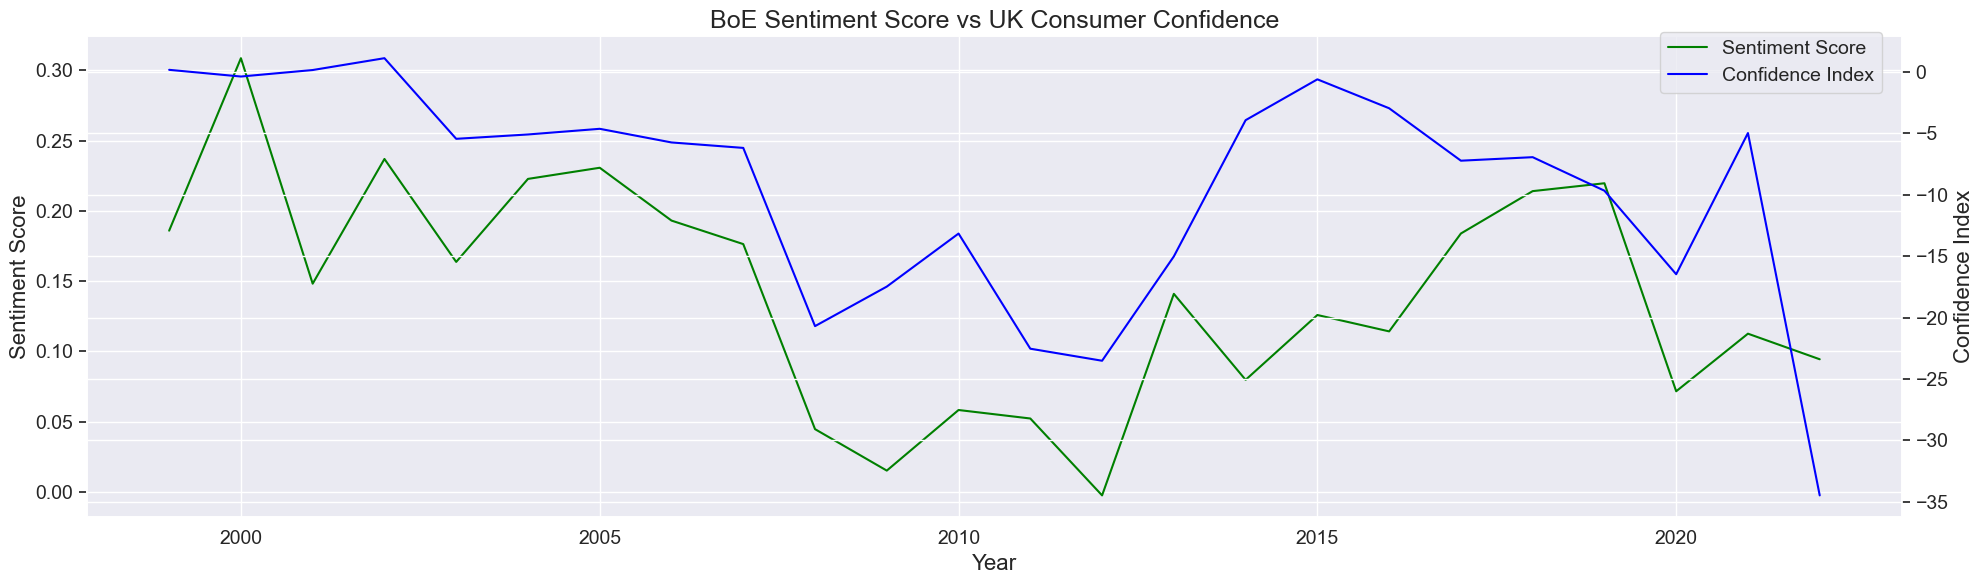

In [232]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot sentiment score on primary y-axis.
ax1.plot(boe_speeches_1999_2022_yearly['year'], boe_speeches_1999_2022_yearly['sentiment_lexicon_weighted'], color='green', label='Sentiment Score')
ax1.set_xlabel('Year',fontsize=16)
ax1.set_ylabel('Sentiment Score', fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=14)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot consumer confidence on secondary y-axis
ax2.plot(boe_speeches_1999_2022_yearly['year'], boe_speeches_1999_2022_yearly['uk_consumer_confidence'], color='blue', label='Confidence Index')
ax2.set_ylabel('Confidence Index', fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=14)

# Add title and legend
plt.title('BoE Sentiment Score vs UK Consumer Confidence', fontsize=18)
fig.legend(loc='upper right', bbox_to_anchor=(0.95, 0.95), fontsize=14)

# Display the chart
plt.tight_layout()
plt.show()

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot sentiment score on primary y-axis.
ax1.plot(boe_speeches_1999_2022_yearly['year'], boe_speeches_1999_2022_yearly['sentiment_lexicon_weighted'], color='green', label='Sentiment Score')
ax1.set_xlabel('Year', fontsize=16)
ax1.set_ylabel('Sentiment Score', fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=14)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot inflation on secondary y-axis
ax2.plot(boe_speeches_1999_2022_yearly['year'], boe_speeches_1999_2022_yearly['uk_inflation_rate_CPIH'], color='blue', label='Inflation Rate')
ax2.set_ylabel('Inflation Rate', fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=14)

# Add title and legend
plt.title('BoE Sentiment Score vs UK Inflation Rate', fontsize=18)
fig.legend(loc='upper right', bbox_to_anchor=(0.95, 0.95), fontsize=14)

# Display the chart
plt.tight_layout()
plt.show()

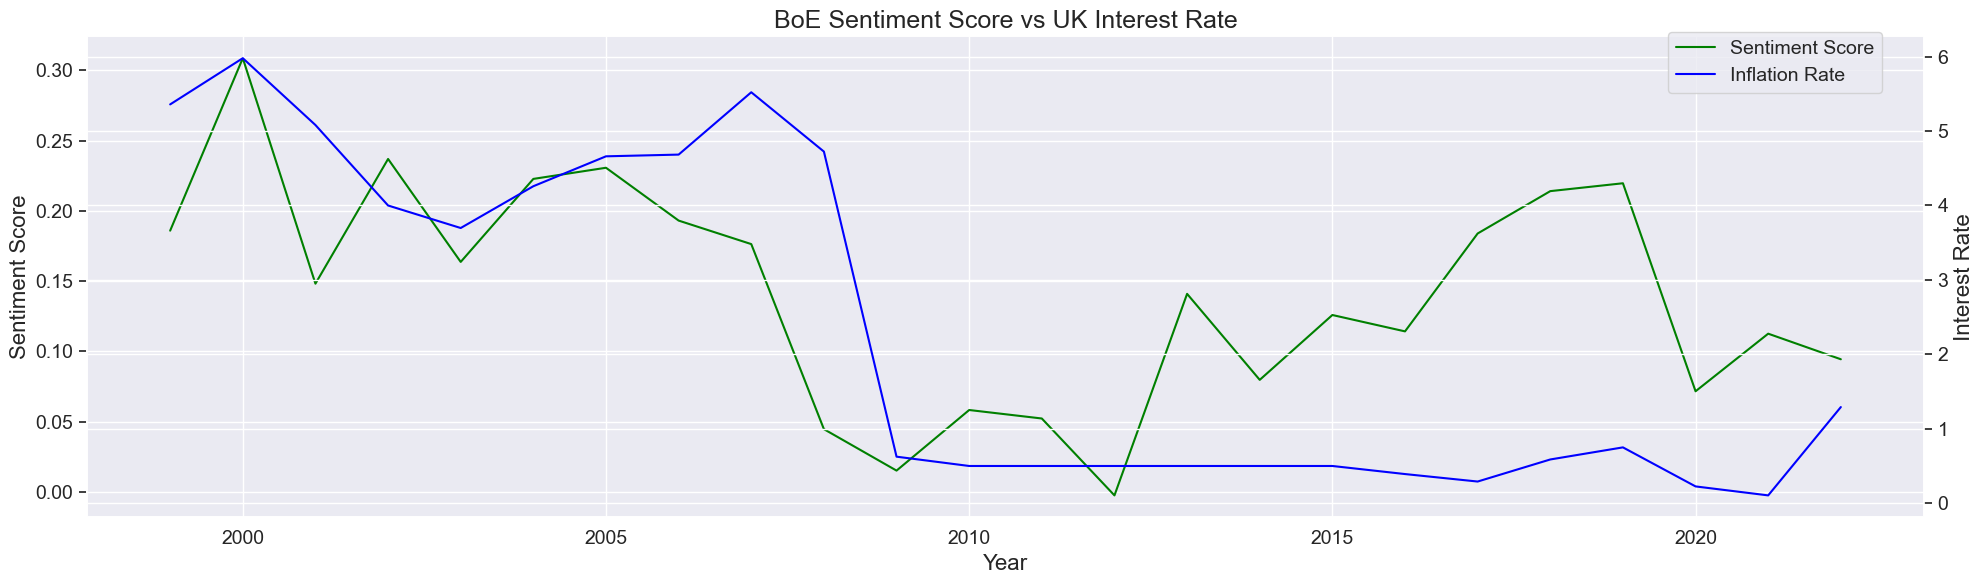

In [248]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot sentiment score on primary y-axis.
ax1.plot(boe_speeches_1999_2022_yearly['year'], boe_speeches_1999_2022_yearly['sentiment_lexicon_weighted'], color='green', label='Sentiment Score')
ax1.set_xlabel('Year', fontsize=16)
ax1.set_ylabel('Sentiment Score', fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=14)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot inflation on secondary y-axis
ax2.plot(boe_speeches_1999_2022_yearly['year'], boe_speeches_1999_2022_yearly['uk_interest_rate'], color='blue', label='Inflation Rate')
ax2.set_ylabel('Interest Rate', fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=14)

# Add title and legend
plt.title('BoE Sentiment Score vs UK Interest Rate', fontsize=18)
fig.legend(loc='upper right', bbox_to_anchor=(0.95, 0.95), fontsize=14)

# Display the chart
plt.tight_layout()
plt.show()

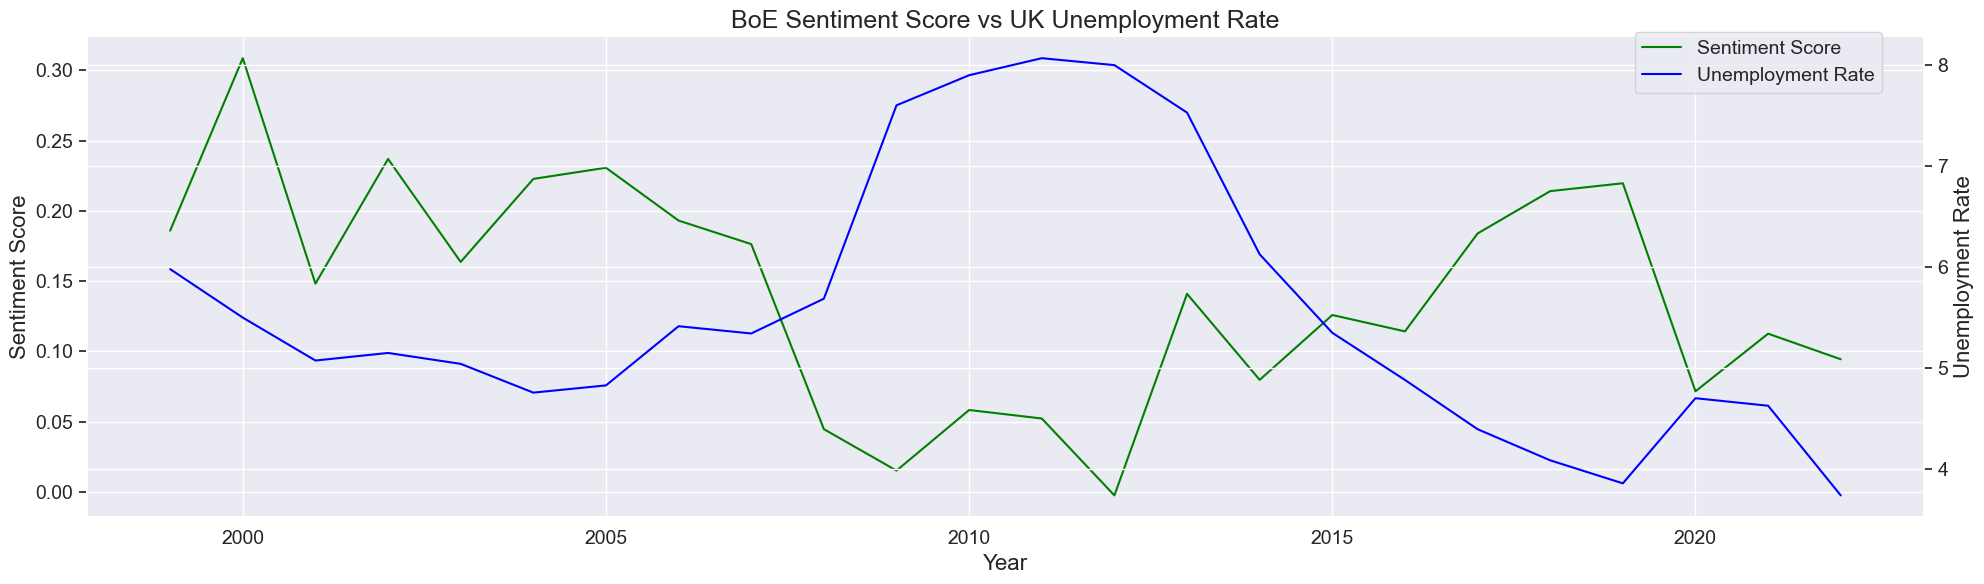

In [236]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot sentiment score on primary y-axis.
ax1.plot(boe_speeches_1999_2022_yearly['year'], boe_speeches_1999_2022_yearly['sentiment_lexicon_weighted'], color='green', label='Sentiment Score')
ax1.set_xlabel('Year', fontsize=16)
ax1.set_ylabel('Sentiment Score', fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=14)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot unemployment on secondary y-axis
ax2.plot(boe_speeches_1999_2022_yearly['year'], boe_speeches_1999_2022_yearly['uk_unemployment_rate'], color='blue', label='Unemployment Rate')
ax2.set_ylabel('Unemployment Rate', fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=14)

# Add title and legend
plt.title('BoE Sentiment Score vs UK Unemployment Rate', fontsize=18)
fig.legend(loc='upper right', bbox_to_anchor=(0.95, 0.95), fontsize=14)

# Display the chart
plt.tight_layout()
plt.show()

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot sentiment score on primary y-axis.
ax1.plot(boe_speeches_1999_2022_yearly['year'], boe_speeches_1999_2022_yearly['sentiment_lexicon_weighted'], color='green', label='Sentiment Score')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment Score', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot GDP on secondary y-axis
ax2.plot(boe_speeches_1999_2022_yearly['year'], boe_speeches_1999_2022_yearly['uk_gdp_growth'], color='blue', label='GDP Growth')
ax2.set_ylabel('GDP Growth', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('BoE Sentiment Score vs UK GDP Growth')
fig.legend(loc='upper right', bbox_to_anchor=(1, 1))

# Display the chart
plt.tight_layout()
plt.show()

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot sentiment score on primary y-axis.
ax1.plot(boe_speeches_1999_2022_yearly['year'], boe_speeches_1999_2022_yearly['sentiment_lexicon_weighted'], color='green', label='Sentiment Score')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment Score', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot GBP USD exchange rate on secondary y-axis
ax2.plot(boe_speeches_1999_2022_yearly['year'], boe_speeches_1999_2022_yearly['gbp_usd_fx'], color='blue', label='GBP USD Forex')
ax2.set_ylabel('GBP USD Forex', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('BoE Sentiment Score vs GBP USD Forex')
fig.legend(loc='upper right', bbox_to_anchor=(1, 1))

# Display the chart
plt.tight_layout()
plt.show()

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot sentiment score on primary y-axis.
ax1.plot(boe_speeches_1999_2022_yearly['year'], boe_speeches_1999_2022_yearly['sentiment_lexicon_weighted'], color='green', label='Sentiment Score')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment Score', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot FTSE 250 on secondary y-axis
ax2.plot(boe_speeches_1999_2022_yearly['year'], boe_speeches_1999_2022_yearly['ftse_250'], color='blue', label='FTSE 250')
ax2.set_ylabel('FTSE 250', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('BoE Sentiment Score vs FTSE 250')
fig.legend(loc='upper right', bbox_to_anchor=(1, 1))

# Display the chart
plt.tight_layout()
plt.show()

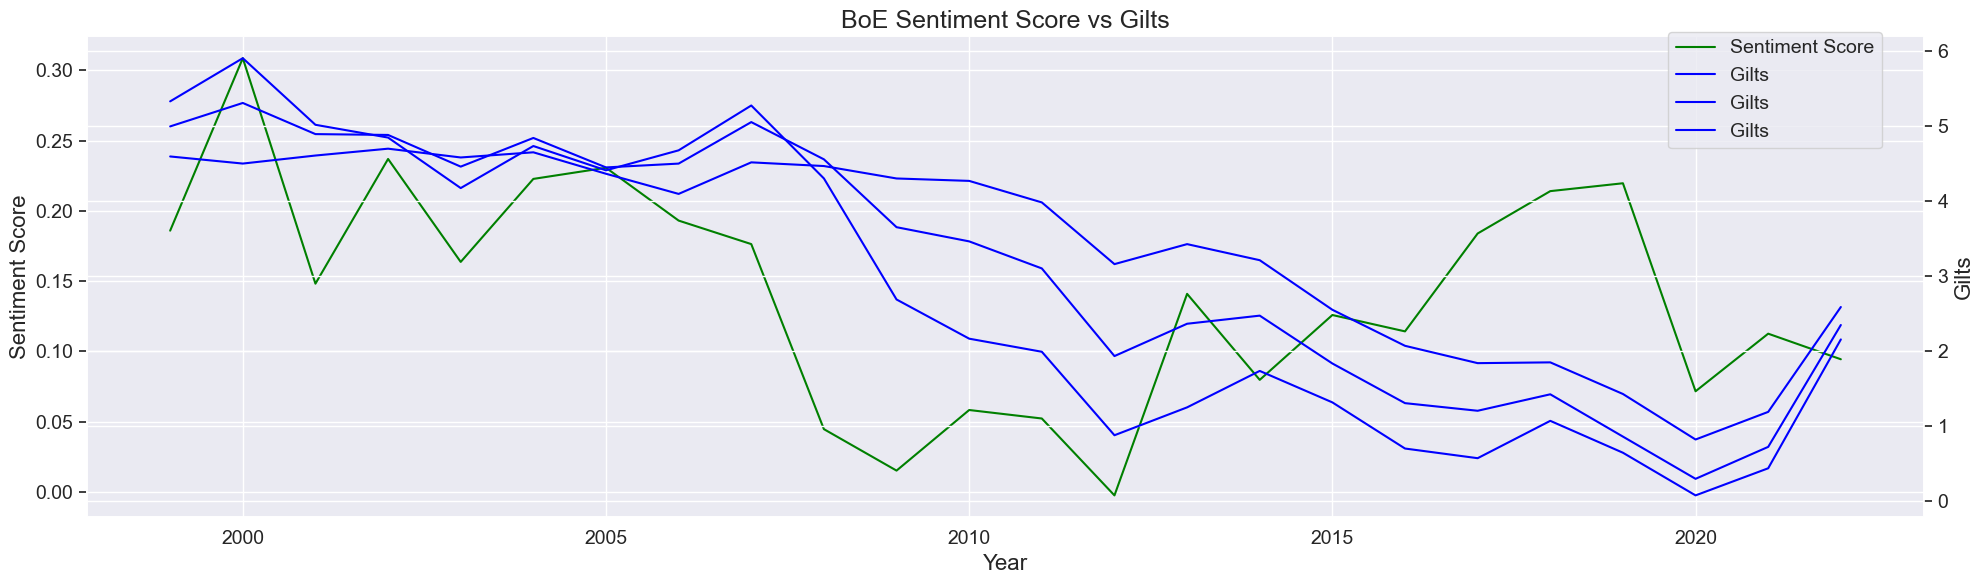

In [238]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot sentiment score on primary y-axis.
ax1.plot(boe_speeches_1999_2022_yearly['year'], boe_speeches_1999_2022_yearly['sentiment_lexicon_weighted'], color='green', label='Sentiment Score')
ax1.set_xlabel('Year', fontsize=16)
ax1.set_ylabel('Sentiment Score', fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=14)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot gilts on secondary y-axis
ax2.plot(boe_speeches_1999_2022_yearly['year'], boe_speeches_1999_2022_yearly[['gilts_short ', 'gilts_medium ', 'gilts_long ']], color='blue', label='Gilts')
ax2.set_ylabel('Gilts', fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=14)

# Add title and legend
plt.title('BoE Sentiment Score vs Gilts', fontsize=18)
fig.legend(loc='upper right', bbox_to_anchor=(0.95, 0.95), fontsize=14)

# Display the chart
plt.tight_layout()
plt.show()

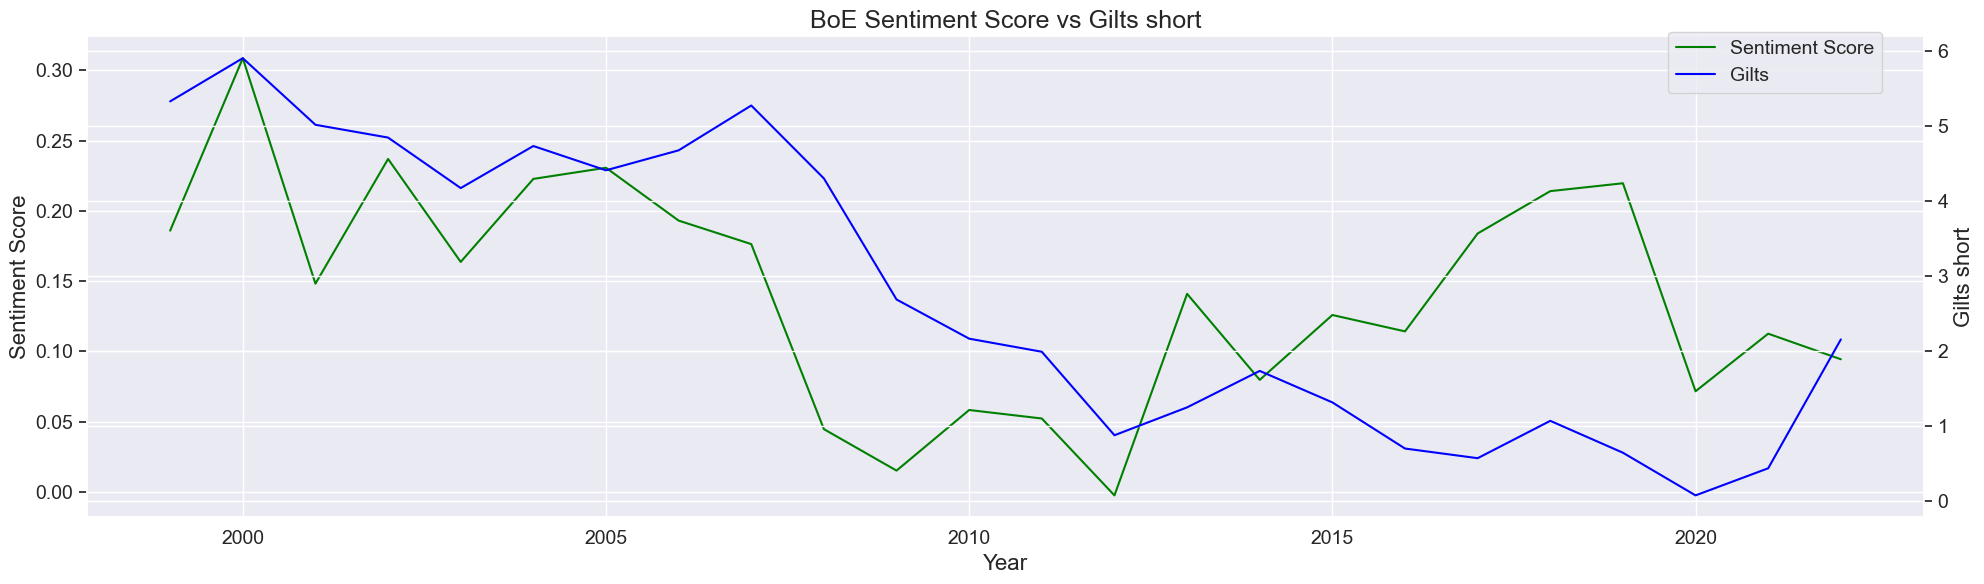

In [242]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot sentiment score on primary y-axis.
ax1.plot(boe_speeches_1999_2022_yearly['year'], boe_speeches_1999_2022_yearly['sentiment_lexicon_weighted'], color='green', label='Sentiment Score')
ax1.set_xlabel('Year', fontsize=16)
ax1.set_ylabel('Sentiment Score', fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=14)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot gilts on secondary y-axis
ax2.plot(boe_speeches_1999_2022_yearly['year'], boe_speeches_1999_2022_yearly[['gilts_short ']], color='blue', label='Gilts')
ax2.set_ylabel('Gilts short', fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=14)

# Add title and legend
plt.title('BoE Sentiment Score vs Gilts short', fontsize=18)
fig.legend(loc='upper right', bbox_to_anchor=(0.95, 0.95), fontsize=14)

# Display the chart
plt.tight_layout()
plt.show()

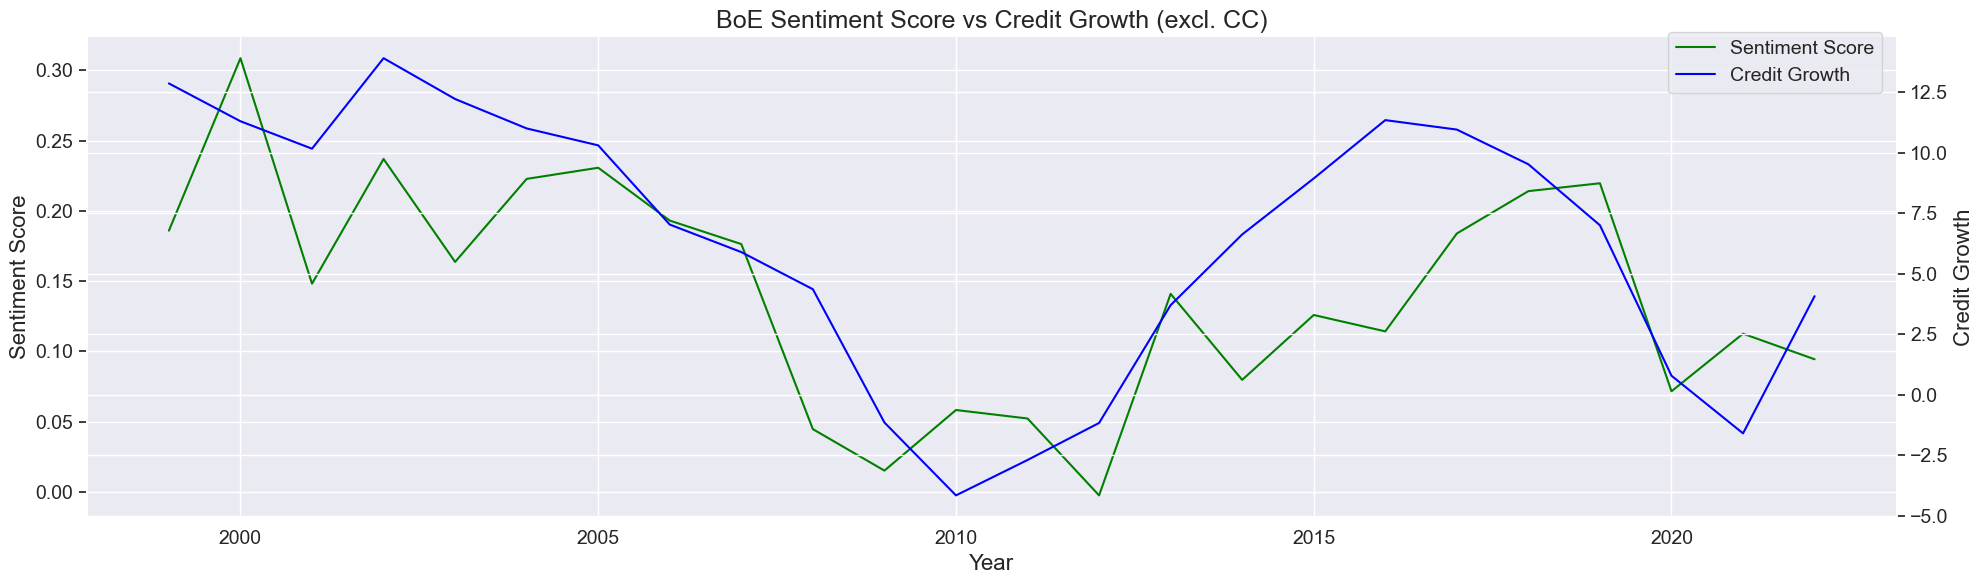

In [246]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot sentiment score on primary y-axis.
ax1.plot(boe_speeches_1999_2022_yearly['year'], boe_speeches_1999_2022_yearly['sentiment_lexicon_weighted'], color='green', label='Sentiment Score')
ax1.set_xlabel('Year', fontsize=16)
ax1.set_ylabel('Sentiment Score', fontsize=16)
ax1.tick_params(axis='both', which='major', labelsize=14)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot credit growth on secondary y-axis
ax2.plot(boe_speeches_1999_2022_yearly['year'], boe_speeches_1999_2022_yearly[['uk_credit_growth_no_cc']], color='blue', label='Credit Growth')
ax2.set_ylabel('Credit Growth', fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=14)

# Add title and legend
plt.title('BoE Sentiment Score vs Credit Growth (excl. CC)', fontsize=18)
fig.legend(loc='upper right', bbox_to_anchor=(0.95, 0.95), fontsize=14)

# Display the chart
plt.tight_layout()
plt.show()

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot sentiment score on primary y-axis.
ax1.plot(boe_speeches_1999_2022_yearly['year'], boe_speeches_1999_2022_yearly['sentiment_lexicon_weighted'], color='green', label='Sentiment Score')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment Score', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot Property Prices on secondary y-axis
ax2.plot(boe_speeches_1999_2022_yearly['year'], boe_speeches_1999_2022_yearly['avg_price_all_property_types'], color='blue', label='Average Property Prices')
ax2.set_ylabel('Average Property Prices', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('BoE Sentiment Score vs Average Property Prices')
fig.legend(loc='upper right', bbox_to_anchor=(1, 1))

# Display the chart
plt.tight_layout()
plt.show()

In [ ]:
# Define function for scatterplot.
generate_scatterplot(boe_indicators_1999_2022, x_axis='sentiment_lexicon_weighted', \
                     y_axis='uk_interest_rate', title=None, hue=None, save_path=None)

In [ ]:
# Define function for scatterplot.
generate_scatterplot(boe_indicators_1999_2022, x_axis='sentiment_lexicon_weighted', \
                     y_axis='uk_unemployment_rate', title=None, hue=None, save_path=None)

In [ ]:
# Define function for scatterplot.
generate_scatterplot(boe_indicators_1999_2022, x_axis='sentiment_lexicon_weighted', \
                     y_axis='uk_credit_growth_no_cc', title=None, hue=None, save_path=None)

In [ ]:
# Define function for scatterplot.
generate_scatterplot(boe_indicators_1999_2022, x_axis='sentiment_lexicon_weighted', \
                     y_axis='uk_consumer_confidence', title=None, hue=None, save_path=None)

In [ ]:
# Define function for scatterplot.
generate_scatterplot(boe_indicators_1999_2022, x_axis='sentiment_lexicon_weighted', \
                     y_axis='gilts_short ', title=None, hue=None, save_path=None)

### 4.3. Initial statistical analysis

In [ ]:
boe_indicators_1999_2022.columns

**4.3.a. Simple Correlation**

In [ ]:
# Create a pairplot for sentiment score and all economic indicators.
columns_sentiment = ['sentiment_lexicon_weighted', 'uk_inflation_rate_CPIH', 'uk_unemployment_rate', 'uk_gdp_growth',
                             'uk_interest_rate', 'uk_consumer_confidence', 'gbp_usd_fx', 'ftse_250', 'gilts_short ', 
                             'gilts_medium ', 'gilts_long ', 'uk_credit_growth_no_cc', 'uk_credit_growth_only_cc',
                             'avg_price_all_property_types']

# Correlation matrix for GPT sentiment score with all economic indicators
correlation_matrix = boe_indicators_1999_2022[columns_sentiment].corr()

# Display the correlation matrix
correlation_matrix

In [ ]:
# Heatmap of the correlation matrix for GPT sentiment score with all economic indicators
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='viridis', cbar=True)

# Customize title and labels
plt.title('Correlation Heatmap of all Economic Indicators with Sentiment')
plt.show()

In [ ]:
# Create a pairplot for GPT sentiment score and price/ inflation indicators
columns_sentiment_price = ['sentiment_lexicon_weighted', 'uk_inflation_rate_CPIH', 'uk_interest_rate',
                             'avg_price_all_property_types']

# Correlation matrix for GPT sentiment score with price/ inflation indicators
correlation_matrix_price = boe_indicators_1999_2022[columns_sentiment_price].corr()

# Display the correlation matrix
correlation_matrix_price

In [ ]:
# Heatmap of the correlation matrix with price/ inflation indicators
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix_price, annot=True, fmt=".2f", cmap='viridis', cbar=True)

# Customize title and labels
plt.title('Correlation Heatmap of Price/Inflation Indicators with Sentiment')
plt.show()

In [ ]:
# Create a pairplot for GPT sentiment score and macroeconnomic indicators
columns_sentiment_macro = ['sentiment_lexicon_weighted', 'uk_gdp_growth', 'uk_unemployment_rate', 
                            'uk_credit_growth_no_cc', 'uk_consumer_confidence']

# Correlation matrix for GPT sentiment score with macroeconomic indicators
correlation_matrix_macro = boe_indicators_1999_2022[columns_sentiment_macro].corr()

# Display the correlation matrix
correlation_matrix_macro

In [ ]:
# Heatmap of the correlation matrix with macroeconomic indicators
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix_macro, annot=True, fmt=".2f", cmap='viridis', cbar=True)

# Customize title and labels
plt.title('Correlation Heatmap of Macroeconomic Indicators with GPT Sentiment')
plt.show()

In [ ]:
# Create a pairplot for GPT sentiment score and financial indicators
columns_sentiment_finance = ['sentiment_lexicon_weighted', 'gbp_usd_fx', 'ftse_250', 'gilts_short ', 
                             'gilts_medium ', 'gilts_long ']

# Correlation matrix for GPT sentiment score with financial indicators
correlation_matrix_finance = boe_indicators_1999_2022[columns_sentiment_finance].corr()

# Display the correlation matrix
correlation_matrix_finance

In [ ]:
# Heatmap of the correlation matrix with finance indicators
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix_finance, annot=True, fmt=".2f", cmap='viridis', cbar=True)

# Customize title and labels
plt.title('Correlation Heatmap of Financial Indicators with GPT Sentiment')
plt.show()

In [ ]:
# Create a pairplot for GPT sentiment score and most impactful indicators
columns_sentiment_top = ['sentiment_lexicon_weighted', 'uk_interest_rate', 'uk_unemployment_rate', 
                            'uk_credit_growth_no_cc', 'uk_consumer_confidence', 'gilts_short ']

# Correlation matrix for GPT sentiment score with and most impactful indicators
correlation_matrix_top = boe_indicators_1999_2022[columns_sentiment_top].corr()

# Display the correlation matrix
correlation_matrix_top

In [ ]:
# Heatmap of the correlation matrix with most impactful indicators
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix_top, annot=True, fmt=".2f", cmap='viridis', cbar=True)

# Customize title and labels
plt.title('Correlation Heatmap of Most Impactful Indicators with Sentiment')
plt.show()

## 5. Non-linear correaltion analysis

In [756]:
# Copy the DataFranme for further manipulation
boe_rf = boe_indicators_1999_2022.copy()

In [758]:
boe_rf.head()

index     reference         country date_format year_month  year  \
0      8  r990112a_BOE  united kingdom  1999-01-12    1999-01  1999   
1      9  r990118a_BOE  united kingdom  1999-01-18    1999-01  1999   
2     10  r990201a_BOE  united kingdom  1999-02-01    1999-02  1999   
3     11  r990210a_BOE  united kingdom  1999-02-10    1999-02  1999   
4     12  r990218a_BOE  united kingdom  1999-02-18    1999-02  1999   

  year_month_dt                     title  author  is_gov  ... gilts_long   \
0    1999-01-01                    Speech  george       1  ...        4.32   
1    1999-01-01                    Speech  george       1  ...        4.32   
2    1999-02-01                    Speech  george       1  ...        4.42   
3    1999-02-01                    Speech  george       1  ...        4.42   
4    1999-02-01  The Chancellor's Lecture  george       1  ...        4.42   

  uk_credit_growth_no_cc uk_credit_growth_only_cc  \
0                   13.5                     26.1   
1                   13.5                     26.1   
2                   13.2                     26.1   
3                   13.2                     26.1   
4                   13.2                     26.1   

   avg_price_all_property_types  monetary policy  interest rate  \
0                         67157                7              1   
1                         67157                8              4   
2                         67157                8              1   
3                         67157                2              1   
4                         67157               21              8   

   financial stability  inflation target  financial crisis  exchange rate  
0                    0                 1                 0              7  
1                    0                 2                 0              5  
2                    0                 0                 0              4  
3                    0                 0                 0              3  
4                    0                 9                 0              7  

[5 rows x 38 columns]

In [759]:
boe_rf.dtypes

index                                      int64
reference                                 object
country                                   object
date_format                       datetime64[ns]
year_month                             period[M]
year                                       int32
year_month_dt                     datetime64[ns]
title                                     object
author                                    object
is_gov                                     int64
text                                      object
text_lemmatised                           object
text_lemmatised_str                       object
word_count_text                            int64
word_count_text_cleaned                    int64
sentiment_lexicon_simple                 float64
sentiment_lexicon_simple_std             float64
sentiment_lexicon_weighted               float64
sentiment_lexicon_weighted_std           float64
uk_inflation_rate_CPIH                   float64
uk_unemployment_rate

In [760]:
# Set 'date' as index for resampling
boe_rf.set_index('date_format', inplace=True)

In [761]:
# View the DataFrame
boe_rf.head()

index     reference         country year_month  year  \
date_format                                                         
1999-01-12       8  r990112a_BOE  united kingdom    1999-01  1999   
1999-01-18       9  r990118a_BOE  united kingdom    1999-01  1999   
1999-02-01      10  r990201a_BOE  united kingdom    1999-02  1999   
1999-02-10      11  r990210a_BOE  united kingdom    1999-02  1999   
1999-02-18      12  r990218a_BOE  united kingdom    1999-02  1999   

            year_month_dt                     title  author  is_gov  \
date_format                                                           
1999-01-12     1999-01-01                    Speech  george       1   
1999-01-18     1999-01-01                    Speech  george       1   
1999-02-01     1999-02-01                    Speech  george       1   
1999-02-10     1999-02-01                    Speech  george       1   
1999-02-18     1999-02-01  The Chancellor's Lecture  george       1   

                                                          text  ...  \
date_format                                                     ...   
1999-01-12   I am only too well aware of the pressure curre...  ...   
1999-01-18   It would be a masterly understatement to descr...  ...   
1999-02-01   I should like to add my personal thanks to you...  ...   
1999-02-10   Thank you, Padraic. I wasn't quite sure what y...  ...   
1999-02-18   As you would expect of a central banker I will...  ...   

            gilts_long  uk_credit_growth_no_cc  uk_credit_growth_only_cc  \
date_format                                                                
1999-01-12         4.32                   13.5                      26.1   
1999-01-18         4.32                   13.5                      26.1   
1999-02-01         4.42                   13.2                      26.1   
1999-02-10         4.42                   13.2                      26.1   
1999-02-18         4.42                   13.2                      26.1   

             avg_price_all_property_types  monetary policy  interest rate  \
date_format                                                                 
1999-01-12                          67157                7              1   
1999-01-18                          67157                8              4   
1999-02-01                          67157                8              1   
1999-02-10                          67157                2              1   
1999-02-18                          67157               21              8   

             financial stability  inflation target  financial crisis  \
date_format                                                            
1999-01-12                     0                 1                 0   
1999-01-18                     0                 2                 0   
1999-02-01                     0                 0                 0   
1999-02-10                     0                 0                 0   
1999-02-18                     0                 9                 0   

             exchange rate  
date_format                 
1999-01-12               7  
1999-01-18               5  
1999-02-01               4  
1999-02-10               3  
1999-02-18               7  

[5 rows x 37 columns]

### 5.1. Random Forst - Monthly Analysis with BoE Wordlist Sentiment Score

**Does sentiment predict economic indicators?**

In [ ]:
# Aggregate sentiment scores and consumer confidence monthly
boe_rf_monthly = boe_rf.resample('M').agg({
            'sentiment_lexicon_weighted': 'mean',
            'uk_consumer_confidence': 'mean',
            'uk_inflation_rate_CPIH': 'mean',
            'uk_unemployment_rate': 'mean',
            'uk_gdp_growth': 'mean',
            'uk_interest_rate': 'mean',
            'uk_consumer_confidence': 'mean', 
            'gbp_usd_fx': 'mean',
            'ftse_250': 'mean',
            'gilts_short ': 'mean',
            'gilts_medium ': 'mean', 
            'gilts_long ': 'mean', 
            'uk_credit_growth_no_cc': 'mean',
            'uk_credit_growth_only_cc': 'mean',
            'avg_price_all_property_types': 'mean'
})

# Reset index to turn 'date' back into a column
boe_rf_monthly.reset_index(inplace=True)

In [ ]:
# View the DataFrame
boe_rf_monthly.head()

In [ ]:
# Create date-related features
boe_rf_monthly['month'] = boe_rf_monthly['date_format'].dt.month
boe_rf_monthly['quarter'] = boe_rf_monthly['date_format'].dt.quarter
boe_rf_monthly['year'] = boe_rf_monthly['date_format'].dt.year

In [ ]:
# View the DataFrame
boe_rf_monthly.head()

In [ ]:
# Create lagged feature for sentiment score with 1 month lag
boe_rf_monthly['sentiment_lexicon_weighted_lag_1m'] = boe_rf_monthly['sentiment_lexicon_weighted'].shift(1)

In [ ]:
# Create lagged feature for sentiment score with 1 month lag
boe_rf_monthly['sentiment_lexicon_weighted_lag_2m'] = boe_rf_monthly['sentiment_lexicon_weighted'].shift(2)

In [ ]:
# Create lagged feature for sentiment score with 1 month lag
boe_rf_monthly['sentiment_lexicon_weighted_lag_3m'] = boe_rf_monthly['sentiment_lexicon_weighted'].shift(3)

In [ ]:
# View the DataFrame
boe_rf_monthly.head()

In [ ]:
# Drop first row(s) with NaN values due to lagging
boe_rf_monthly.dropna(inplace=True)

In [ ]:
# List of targets
targets = [
    'uk_consumer_confidence',
    'uk_inflation_rate_CPIH',
    'uk_unemployment_rate',
    'uk_gdp_growth',
    'uk_interest_rate',
    'gbp_usd_fx',
    'ftse_250',
    'gilts_short ',
    'gilts_medium ', 
    'gilts_long ', 
    'uk_credit_growth_no_cc',
    'uk_credit_growth_only_cc',
    'avg_price_all_property_types'
]

# Features
feature_cols = [
    'sentiment_lexicon_weighted',
    'sentiment_lexicon_weighted_lag_1m',
    'sentiment_lexicon_weighted_lag_2m',
    'sentiment_lexicon_weighted_lag_3m',
    'month', 'quarter', 'year'
]

# Loop through each target
for target in targets:
    print(f"\nTraining model for: {target}")
    y = boe_rf_monthly[target]
    X = boe_rf_monthly[feature_cols]

    # Time-series aware split without shuffling
    split_idx = int(len(boe_rf_monthly) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Initialize and train the model
    rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    rf.fit(X_train, y_train)

    # Make predictions
    y_pred = rf.predict(X_test)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"RMSE: {rmse:.3f}")
    print(f"R^2: {r2:.3f}")

In [ ]:
# List of targets
targets = [
    'uk_consumer_confidence',
    'uk_inflation_rate_CPIH',
    'uk_unemployment_rate',
    'uk_gdp_growth',
    'uk_interest_rate',
    'gbp_usd_fx',
    'ftse_250',
    'gilts_short ',
    'gilts_medium ', 
    'gilts_long ', 
    'uk_credit_growth_no_cc',
    'uk_credit_growth_only_cc',
    'avg_price_all_property_types'
]

# Features
feature_cols = [
    'sentiment_lexicon_weighted_lag_2m',
]

# Loop through each target
for target in targets:
    print(f"\nTraining model for: {target}")
    y = boe_rf_monthly[target]
    X = boe_rf_monthly[feature_cols]

    # Time-series aware split without shuffling
    split_idx = int(len(boe_rf_monthly) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Initialize and train the model
    rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    rf.fit(X_train, y_train)

    # Make predictions
    y_pred = rf.predict(X_test)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"RMSE: {rmse:.3f}")
    print(f"R^2: {r2:.3f}")

**Do economic indicators predict sentiment?**

In [ ]:
# List of targets
targets = [
    'sentiment_lexicon_weighted',
]

# Features
feature_cols = [
    'uk_consumer_confidence',
    'uk_inflation_rate_CPIH',
    'uk_unemployment_rate',
    'uk_gdp_growth',
    'uk_interest_rate',
    'gbp_usd_fx',
    'ftse_250',
    'gilts_short ',
    'gilts_medium ', 
    'gilts_long ', 
    'uk_credit_growth_no_cc',
    'uk_credit_growth_only_cc',
    'avg_price_all_property_types'
]

# Loop through each target
for target in targets:
    print(f"\nTraining model for: {target}")
    y = boe_rf_monthly[target]
    X = boe_rf_monthly[feature_cols]

    # Time-series aware split without shuffling
    split_idx = int(len(boe_rf_monthly) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Initialize and train the model
    rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    rf.fit(X_train, y_train)

    # Make predictions
    y_pred = rf.predict(X_test)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"RMSE: {rmse:.3f}")
    print(f"R^2: {r2:.3f}")

**Conclusion**: negative R2 suggest model performs worse than simply predicting the mean of the target variable for all observations.

### 5.2.Random Forest Quarterly Analysis woth BoE Wordlist Sentiment Score

**Does sentiment predict economic indicators?**

In [ ]:
# Aggregate sentiment scores and consumer confidence monthly
boe_rf_quarterly = boe_rf.resample('Q').agg({
            'sentiment_lexicon_weighted': 'mean',
            'uk_consumer_confidence': 'mean',
            'uk_inflation_rate_CPIH': 'mean',
            'uk_unemployment_rate': 'mean',
            'uk_gdp_growth': 'mean',
            'uk_interest_rate': 'mean',
            'uk_consumer_confidence': 'mean', 
            'gbp_usd_fx': 'mean',
            'ftse_250': 'mean',
            'gilts_short ': 'mean',
            'gilts_medium ': 'mean', 
            'gilts_long ': 'mean', 
            'uk_credit_growth_no_cc': 'mean',
            'uk_credit_growth_only_cc': 'mean',
            'avg_price_all_property_types': 'mean'
})

# Reset index to turn 'date' back into a column
boe_rf_quarterly.reset_index(inplace=True)

In [ ]:
# Create date-related features
boe_rf_quarterly['month'] = boe_rf_quarterly['date_format'].dt.month
boe_rf_quarterly['quarter'] = boe_rf_quarterly['date_format'].dt.quarter
boe_rf_quarterly['year'] = boe_rf_quarterly['date_format'].dt.year

In [ ]:
# Create lagged features (3 months lag is now 1 quarter lag)
boe_rf_quarterly['sentiment_lexicon_weighted_lag_1q'] = boe_rf_quarterly['sentiment_lexicon_weighted'].shift(1)

In [ ]:
# View the DataFrame
boe_rf_quarterly.head()

In [ ]:
# Drop NaNs due to lag
boe_rf_quarterly.dropna(inplace=True)

In [ ]:
# List of targets
targets = [
    'uk_consumer_confidence',
    'uk_inflation_rate_CPIH',
    'uk_unemployment_rate',
    'uk_gdp_growth',
    'uk_interest_rate',
    'uk_consumer_confidence', 
    'gbp_usd_fx',
    'ftse_250',
    'gilts_short ',
    'gilts_medium ', 
    'gilts_long ', 
    'uk_credit_growth_no_cc',
    'uk_credit_growth_only_cc',
    'avg_price_all_property_types'
]

# Features
feature_cols = [
    'sentiment_lexicon_weighted', 
    'sentiment_lexicon_weighted_lag_1q',
    'month', 'quarter', 'year'
]

# Loop through each target
for target in targets:
    print(f"\nTraining model for: {target}")
    y = boe_rf_quarterly[target]
    X = boe_rf_quarterly[feature_cols]

    # Time-series aware split without shuffling
    split_idx = int(len(boe_rf_quarterly) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Initialize and train the model
    rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    rf.fit(X_train, y_train)

    # Make predictions
    y_pred = rf.predict(X_test)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"RMSE: {rmse:.3f}")
    print(f"R^2: {r2:.3f}")

**Conclusion**: negative R2 suggest model performs worse than simply predicting the mean of the target variable for all observations.

**Do economic indicators predict sentiment?**

In [ ]:
# List of targets
targets = [
    'sentiment_lexicon_weighted',
]

# Features
feature_cols = [
    'uk_consumer_confidence',
    'uk_inflation_rate_CPIH',
    'uk_unemployment_rate',
    'uk_gdp_growth',
    'uk_interest_rate',
    'gbp_usd_fx',
    'ftse_250',
    'gilts_short ',
    'gilts_medium ', 
    'gilts_long ', 
    'uk_credit_growth_no_cc',
    'uk_credit_growth_only_cc',
    'avg_price_all_property_types'
]

# Loop through each target
for target in targets:
    print(f"\nTraining model for: {target}")
    y = boe_rf_quarterly[target]
    X = boe_rf_quarterly[feature_cols]

    # Time-series aware split without shuffling
    split_idx = int(len(boe_rf_quarterly) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Initialize and train the model
    rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    rf.fit(X_train, y_train)

    # Make predictions
    y_pred = rf.predict(X_test)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"RMSE: {rmse:.3f}")
    print(f"R^2: {r2:.3f}")

**Observations**: model explains roughly 32.6% of the variance in the data. moderate level of explanatory power.

### 5.3.Random Forest with BoE Wordlist Sentiment Score after checking whether series are stationary

Check for stationarity to ensure analysis or modeling is valid, and transform the data if it is not stationary

In [790]:
# List of variables you want to test
variables = ['sentiment_lexicon_weighted',
             'uk_consumer_confidence',
             'uk_inflation_rate_CPIH',
             'uk_unemployment_rate',
             'uk_gdp_growth',
             'uk_interest_rate',
             'gbp_usd_fx',
             'ftse_250',
             'gilts_short ',
             'gilts_medium ',
             'gilts_long ',
             'uk_credit_growth_no_cc',
             'uk_credit_growth_only_cc',
             'avg_price_all_property_types']

# Loop over each variable
for var in variables:
    series = boe_rf[var]
    result = adfuller(series.dropna())  # drop NaNs if any
    print(f"{var}: p-value = {result[1]:.4f}")

sentiment_lexicon_weighted: p-value = 0.0042
uk_consumer_confidence: p-value = 0.6762
uk_inflation_rate_CPIH: p-value = 0.9101
uk_unemployment_rate: p-value = 0.6788
uk_gdp_growth: p-value = 0.0000
uk_interest_rate: p-value = 0.3117
gbp_usd_fx: p-value = 0.4019
ftse_250: p-value = 0.5079
gilts_short : p-value = 0.2794
gilts_medium : p-value = 0.6901
gilts_long : p-value = 0.7010
uk_credit_growth_no_cc: p-value = 0.4252
uk_credit_growth_only_cc: p-value = 0.0916
avg_price_all_property_types: p-value = 0.8011


**Observation**: the following variables are not stationary and need to be transformed (p>0.05):
- uk_consumer_confidence: p-value = 0.6036
- uk_inflation_rate_CPIH: p-value = 0.9002
- uk_unemployment_rate: p-value = 0.6910
- uk_interest_rate: p-value = 0.1180
- gbp_usd_fx: p-value = 0.4149
- ftse_250: p-value = 0.5971
- gilts_short : p-value = 0.2890
- gilts_medium : p-value = 0.4514
- gilts_long : p-value = 0.6089
- uk_credit_growth_no_cc: p-value = 0.4432
- uk_credit_growth_only_cc: p-value = 0.0974
- avg_price_all_property_types: p-value = 0.8106

In [766]:
# Create a new dataframe to transform the data
boe_rf_diff = boe_rf.copy()

In [823]:
# transform original series into a change series, highlighting how much it increases or decreases from one period to the next
variables = [
    'sentiment_lexicon_weighted', 'uk_consumer_confidence', 'uk_inflation_rate_CPIH', 'uk_unemployment_rate',
    'uk_gdp_growth', 'uk_interest_rate', 'gbp_usd_fx', 'ftse_250',
    'gilts_short ', 'gilts_medium ', 'gilts_long ',
    'uk_credit_growth_no_cc', 'uk_credit_growth_only_cc',
    'avg_price_all_property_types'
]

# For example, create differenced versions of all variables
for var in variables:
    boe_rf_diff[f'{var}_diff'] = boe_rf_diff[var].diff()

In [780]:
# View the DataFrame
boe_rf_diff.head()

index     reference         country year_month  year  \
date_format                                                         
1999-01-18       9  r990118a_BOE  united kingdom    1999-01  1999   
1999-02-01      10  r990201a_BOE  united kingdom    1999-02  1999   
1999-02-10      11  r990210a_BOE  united kingdom    1999-02  1999   
1999-02-18      12  r990218a_BOE  united kingdom    1999-02  1999   
1999-02-24      13  r990224a_BOE  united kingdom    1999-02  1999   

            year_month_dt                     title  author  is_gov  \
date_format                                                           
1999-01-18     1999-01-01                    Speech  george       1   
1999-02-01     1999-02-01                    Speech  george       1   
1999-02-10     1999-02-01                    Speech  george       1   
1999-02-18     1999-02-01  The Chancellor's Lecture  george       1   
1999-02-24     1999-02-01                    Speech  george       1   

                                                          text  ...  \
date_format                                                     ...   
1999-01-18   It would be a masterly understatement to descr...  ...   
1999-02-01   I should like to add my personal thanks to you...  ...   
1999-02-10   Thank you, Padraic. I wasn't quite sure what y...  ...   
1999-02-18   As you would expect of a central banker I will...  ...   
1999-02-24   Some months ago, by quoting my initial reactio...  ...   

            uk_unemployment_rate_diff uk_interest_rate_diff  gbp_usd_fx_diff  \
date_format                                                                    
1999-01-18                        0.0                   0.0         0.000000   
1999-02-01                        0.0                  -0.5        -0.023345   
1999-02-10                        0.0                   0.0         0.000000   
1999-02-18                        0.0                   0.0         0.000000   
1999-02-24                        0.0                   0.0         0.000000   

             ftse_250_diff  gilts_short _diff  gilts_medium _diff  \
date_format                                                         
1999-01-18        0.000000               0.00                0.00   
1999-02-01      287.614478               0.15                0.15   
1999-02-10        0.000000               0.00                0.00   
1999-02-18        0.000000               0.00                0.00   
1999-02-24        0.000000               0.00                0.00   

             gilts_long _diff  uk_credit_growth_no_cc_diff  \
date_format                                                  
1999-01-18                0.0                          0.0   
1999-02-01                0.1                         -0.3   
1999-02-10                0.0                          0.0   
1999-02-18                0.0                          0.0   
1999-02-24                0.0                          0.0   

             uk_credit_growth_only_cc_diff  avg_price_all_property_types_diff  
date_format                                                                    
1999-01-18                             0.0                                0.0  
1999-02-01                             0.0                                0.0  
1999-02-10                             0.0                                0.0  
1999-02-18                             0.0                                0.0  
1999-02-24                             0.0                                0.0  

[5 rows x 49 columns]

In [769]:
# Drop NaNs due to lag
boe_rf_diff.dropna(inplace=True)

In [770]:
# List of targets
targets = [
    'uk_consumer_confidence_diff',
    'uk_inflation_rate_CPIH_diff',
    'uk_unemployment_rate_diff',
    'uk_gdp_growth',
    'uk_interest_rate_diff',
    'gbp_usd_fx_diff',
    'ftse_250_diff',
    'gilts_short _diff',
    'gilts_medium _diff', 
    'gilts_long _diff', 
    'uk_credit_growth_no_cc_diff',
    'uk_credit_growth_only_cc_diff',
    'avg_price_all_property_types_diff'
]

# Features
feature_cols = [
    'sentiment_lexicon_weighted',
    'sentiment_lexicon_weighted_lag_1m',
    'sentiment_lexicon_weighted_lag_2m',
    'sentiment_lexicon_weighted_lag_3m',
    'month', 'quarter', 'year'
]

# Features
feature_cols = [
    'sentiment_lexicon_weighted']

# Loop through each target
for target in targets:
    print(f"\nTraining model for: {target}")
    y = boe_rf_diff[target]
    X = boe_rf_diff[feature_cols]

    # Time-series aware split without shuffling
    split_idx = int(len(boe_rf_diff) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Initialize and train the model
    rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    rf.fit(X_train, y_train)

    # Make predictions
    y_pred = rf.predict(X_test)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"RMSE: {rmse:.3f}")
    print(f"R^2: {r2:.3f}")


Training model for: uk_consumer_confidence_diff
RMSE: 1.857
R^2: -0.034

Training model for: uk_inflation_rate_CPIH_diff
RMSE: 0.248
R^2: -0.087

Training model for: uk_unemployment_rate_diff
RMSE: 0.060
R^2: -0.167

Training model for: uk_gdp_growth
RMSE: 6.299
R^2: -0.028

Training model for: uk_interest_rate_diff
RMSE: 0.109
R^2: -0.685

Training model for: gbp_usd_fx_diff
RMSE: 0.015
R^2: -1.133

Training model for: ftse_250_diff
RMSE: 467.959
R^2: -0.125

Training model for: gilts_short _diff
RMSE: 0.145
R^2: -0.176

Training model for: gilts_medium _diff
RMSE: 0.125
R^2: -0.141

Training model for: gilts_long _diff
RMSE: 0.107
R^2: -0.073

Training model for: uk_credit_growth_no_cc_diff
RMSE: 0.358
R^2: -0.115

Training model for: uk_credit_growth_only_cc_diff
RMSE: 0.987
R^2: -0.032

Training model for: avg_price_all_property_types_diff
RMSE: 1718.000
R^2: -0.054


**Observation**: R2 is still negative.

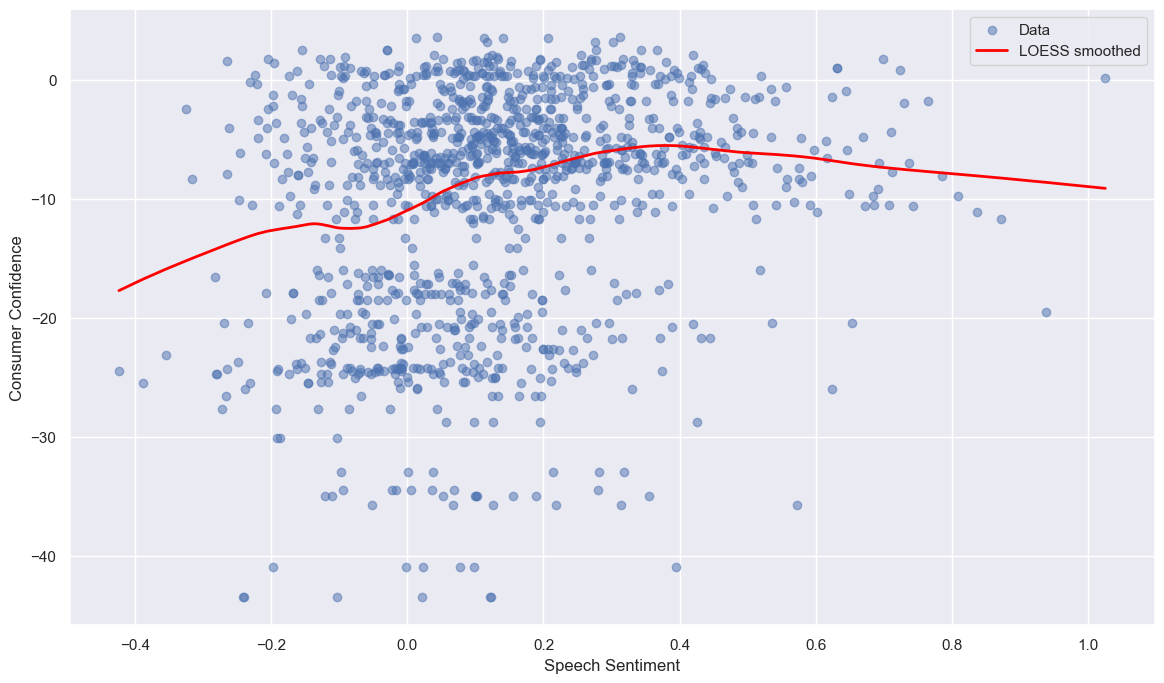

In [771]:
# Correlation between sentiment score and consumer confidene
x = boe_rf['sentiment_lexicon_weighted']
y = boe_rf['uk_consumer_confidence']

# Apply LOWESS smoothing
smoothed = lowess(y, x, frac=0.3)  # frac is smoothing span

# Plot original data
plt.scatter(x, y, alpha=0.5, label='Data')
# Plot smoothed line
plt.plot(smoothed[:, 0], smoothed[:, 1], color='red', linewidth=2, label='LOESS smoothed')
plt.xlabel('Speech Sentiment')
plt.ylabel('Consumer Confidence')
plt.legend()
plt.show()

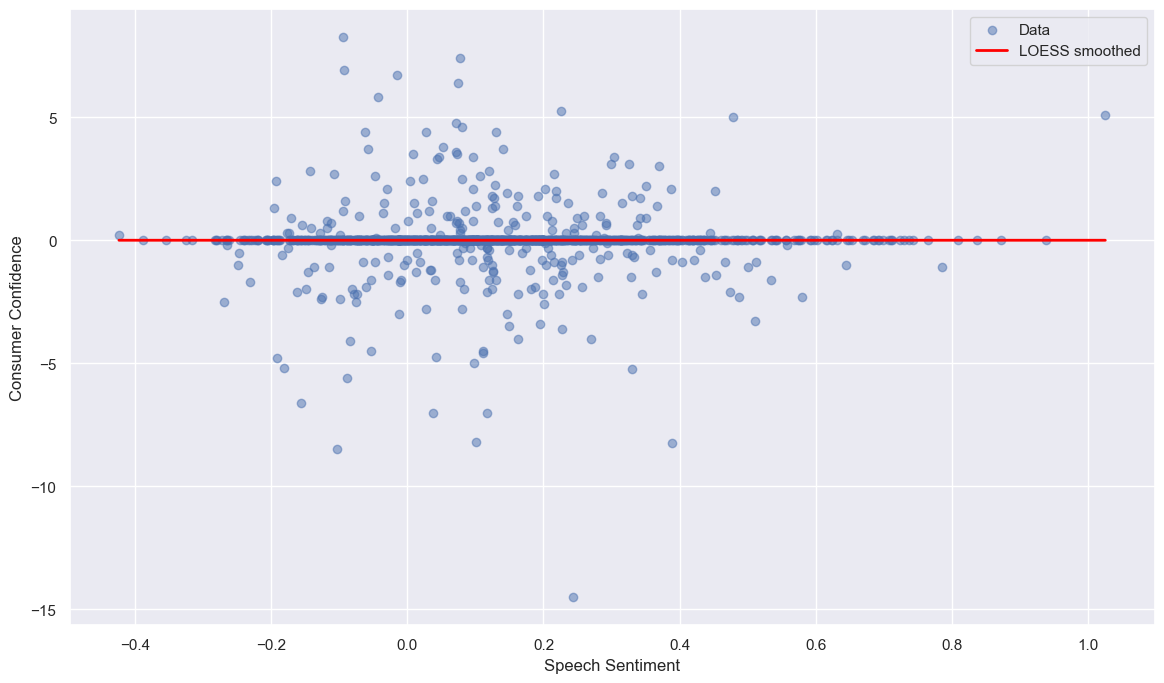

In [778]:
# Correlation between sentiment score and consumer confidene
x = boe_rf_diff['sentiment_lexicon_weighted']
y = boe_rf_diff['uk_consumer_confidence_diff']

# Apply LOWESS smoothing
smoothed = lowess(y, x, frac=0.3)  # frac is smoothing span

# Plot original data
plt.scatter(x, y, alpha=0.5, label='Data')
# Plot smoothed line
plt.plot(smoothed[:, 0], smoothed[:, 1], color='red', linewidth=2, label='LOESS smoothed')
plt.xlabel('Speech Sentiment')
plt.ylabel('Consumer Confidence')
plt.legend()
plt.show()

### 5.4. Cross Correlation between two time series at different lags

- Positive lags: sentiment leads indicator
- Negative lags: variable leads sentiment

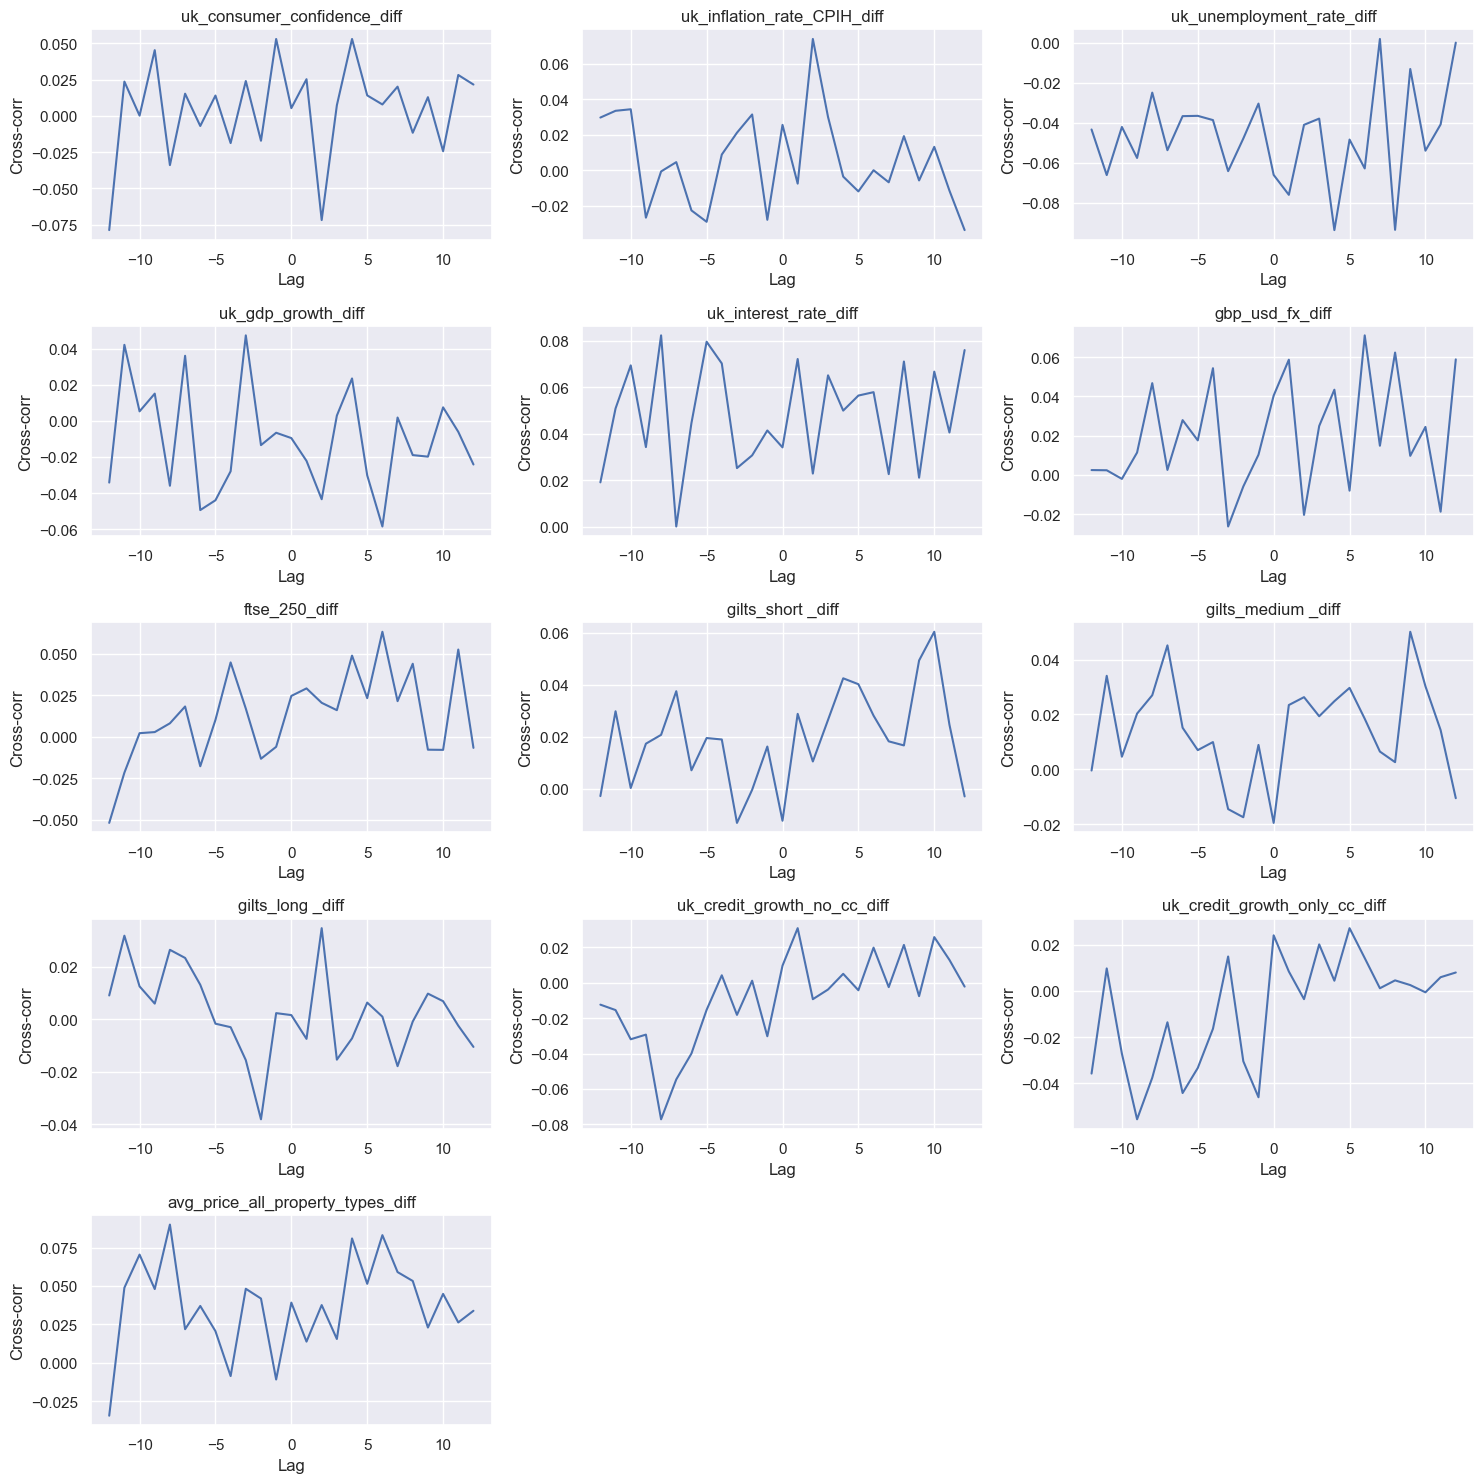

In [921]:
indicators_diff = ['uk_consumer_confidence_diff', 'uk_inflation_rate_CPIH_diff', 'uk_unemployment_rate_diff',
              'uk_gdp_growth_diff', 'uk_interest_rate_diff', 'gbp_usd_fx_diff', 'ftse_250_diff',
              'gilts_short _diff', 'gilts_medium _diff', 'gilts_long _diff',
              'uk_credit_growth_no_cc_diff', 'uk_credit_growth_only_cc_diff',
              'avg_price_all_property_types_diff']
lags = range(-12, 13)

n_vars = len(indicators)
ncols = 3
nrows = (n_vars + ncols - 1) // ncols  # Calculate number of rows needed

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))  # Adjust size as needed

# Flatten axes array for easy looping if multiple rows
axes = axes.flatten()

for i, var in enumerate(indicators_diff):
    cc = [boe_rf_diff['sentiment_lexicon_weighted'].corr(boe_rf_diff[var].shift(lag)) for lag in lags]
    ax = axes[i]
    ax.plot(lags, cc)
    ax.set_title(f'{var}')
    ax.set_xlabel('Lag')
    ax.set_ylabel('Cross-corr')
    ax.grid(True)

# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [809]:
for i, var in enumerate(indicators_diff):
    p_values = []
    cc = []
    for lag in lags:
        x = boe_rf_diff['sentiment_lexicon_weighted']
        y = boe_rf_diff[var].shift(lag)
        # Drop NaNs
        valid_idx = x.dropna().index.intersection(y.dropna().index)
        x_valid = x.loc[valid_idx]
        y_valid = y.loc[valid_idx]
        r = x_valid.corr(y_valid)
        cc.append(r)
        # Convert r to t-statistic
        n = len(valid_idx)
        if n > 2:
            t_stat = r * np.sqrt((n - 2) / (1 - r**2))
            # two-sided p-value
            p = 2 * (1 - stats.t.cdf(abs(t_stat), df=n - 2))
        else:
            p = np.nan  # Not enough data
        p_values.append(p)
    
    # Now, plot CC + mark significance with stars or different color if p<0.05
    ax = axes[i]
    ax.plot(lags, cc)
    # Mark significant points
    for j, p in enumerate(p_values):
        if p < 0.05:
            ax.scatter(lags[j], cc[j], color='red')  # or add a star marker
    ax.set_title(f'{var}')
    ax.set_xlabel('Lag')
    ax.set_ylabel('Cross-corr')
    ax.grid(True)

   # Print significant lags with both p-value and correlation coefficient
    print(f"\nSignificant lags for {var}:")
    for lag_idx, p in enumerate(p_values):
        if not np.isnan(p) and p < 0.05:
            corr_coeff = cc[lag_idx]
            print(f"Lag {lags[lag_idx]}: p-value={p:.4f}, correlation={corr_coeff:.3f}")


Significant lags for uk_consumer_confidence_diff:
Lag -12: p-value=0.0098, correlation=-0.079
Lag 2: p-value=0.0180, correlation=-0.072

Significant lags for uk_inflation_rate_CPIH_diff:
Lag 2: p-value=0.0150, correlation=0.074

Significant lags for uk_unemployment_rate_diff:
Lag -11: p-value=0.0297, correlation=-0.066
Lag -3: p-value=0.0343, correlation=-0.064
Lag 0: p-value=0.0292, correlation=-0.066
Lag 1: p-value=0.0122, correlation=-0.076
Lag 4: p-value=0.0020, correlation=-0.094
Lag 6: p-value=0.0391, correlation=-0.063
Lag 8: p-value=0.0021, correlation=-0.094

Significant lags for uk_gdp_growth:
Lag 9: p-value=0.0283, correlation=0.067
Lag 10: p-value=0.0127, correlation=0.076
Lag 11: p-value=0.0174, correlation=0.072
Lag 12: p-value=0.0136, correlation=0.075

Significant lags for uk_interest_rate_diff:
Lag -10: p-value=0.0226, correlation=0.069
Lag -8: p-value=0.0068, correlation=0.082
Lag -5: p-value=0.0088, correlation=0.080
Lag -4: p-value=0.0207, correlation=0.070
Lag 1: 

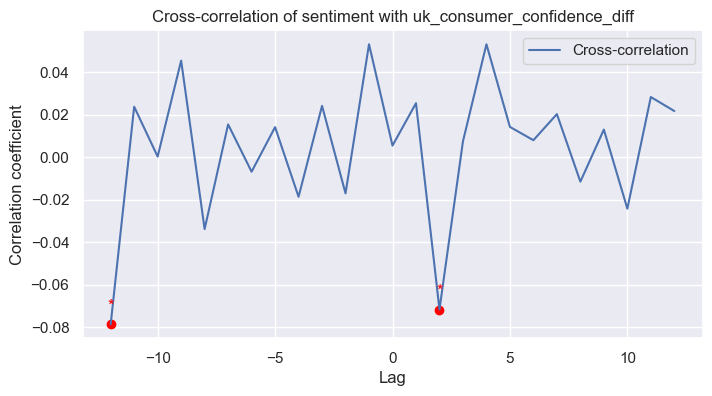


Significant lags for uk_consumer_confidence_diff:
Lag -12: p-value=0.0098, correlation=-0.079
Lag 2: p-value=0.0181, correlation=-0.072


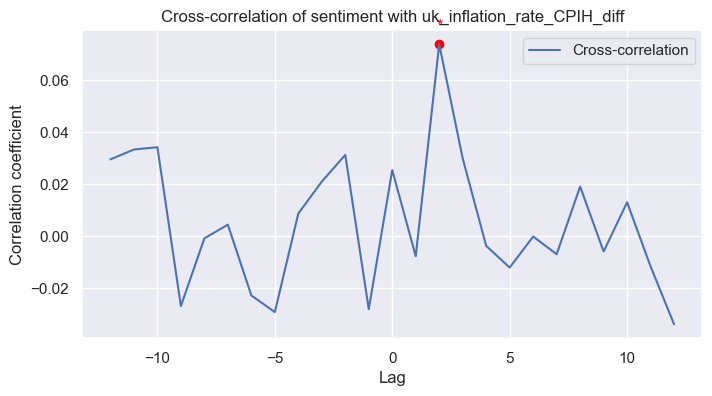


Significant lags for uk_inflation_rate_CPIH_diff:
Lag 2: p-value=0.0150, correlation=0.074


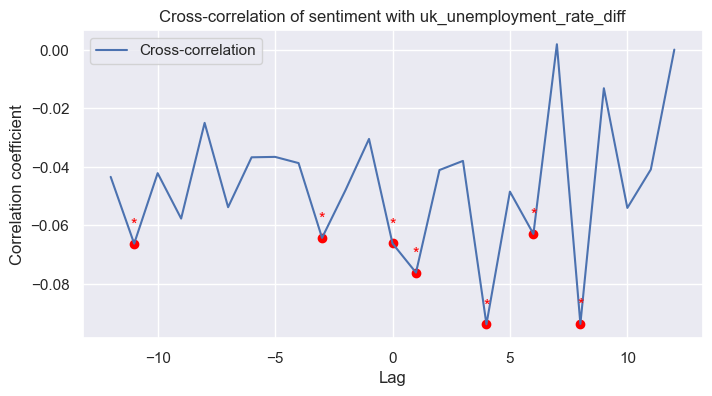


Significant lags for uk_unemployment_rate_diff:
Lag -11: p-value=0.0297, correlation=-0.066
Lag -3: p-value=0.0343, correlation=-0.064
Lag 0: p-value=0.0292, correlation=-0.066
Lag 1: p-value=0.0121, correlation=-0.076
Lag 4: p-value=0.0020, correlation=-0.094
Lag 6: p-value=0.0387, correlation=-0.063
Lag 8: p-value=0.0021, correlation=-0.094


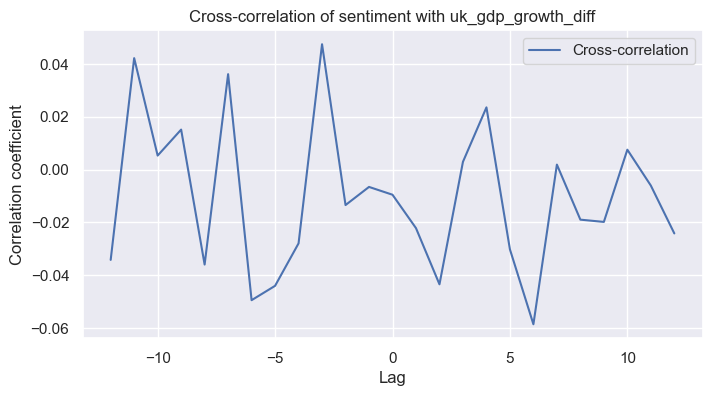


Significant lags for uk_gdp_growth_diff:


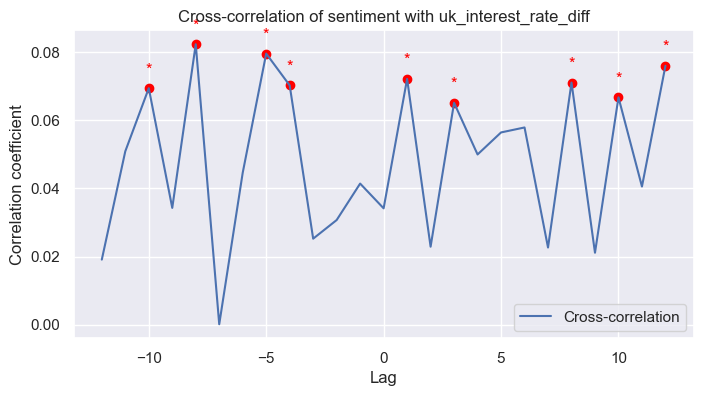


Significant lags for uk_interest_rate_diff:
Lag -10: p-value=0.0226, correlation=0.069
Lag -8: p-value=0.0068, correlation=0.082
Lag -5: p-value=0.0088, correlation=0.080
Lag -4: p-value=0.0207, correlation=0.070
Lag 1: p-value=0.0174, correlation=0.072
Lag 3: p-value=0.0320, correlation=0.065
Lag 8: p-value=0.0195, correlation=0.071
Lag 10: p-value=0.0285, correlation=0.067
Lag 12: p-value=0.0127, correlation=0.076


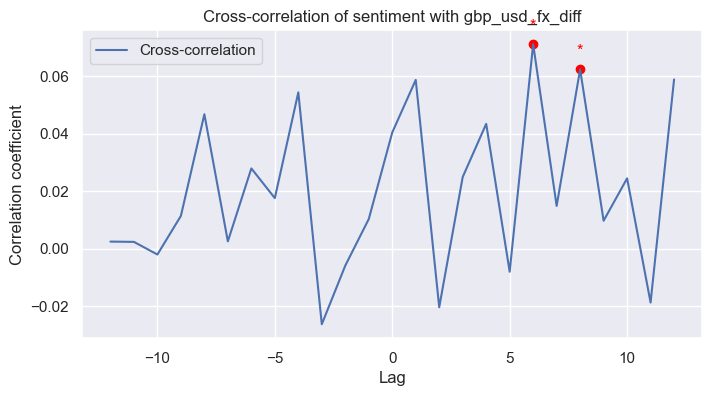


Significant lags for gbp_usd_fx_diff:
Lag 6: p-value=0.0195, correlation=0.071
Lag 8: p-value=0.0408, correlation=0.062


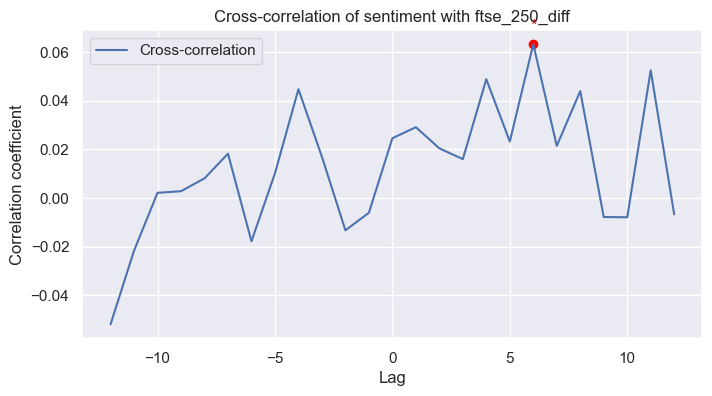


Significant lags for ftse_250_diff:
Lag 6: p-value=0.0380, correlation=0.063


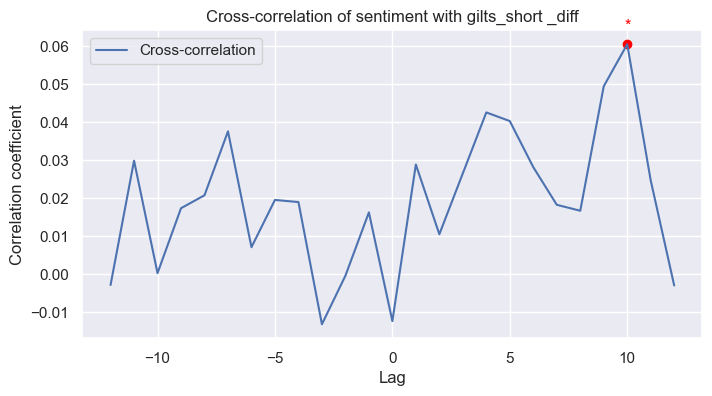


Significant lags for gilts_short _diff:
Lag 10: p-value=0.0475, correlation=0.060


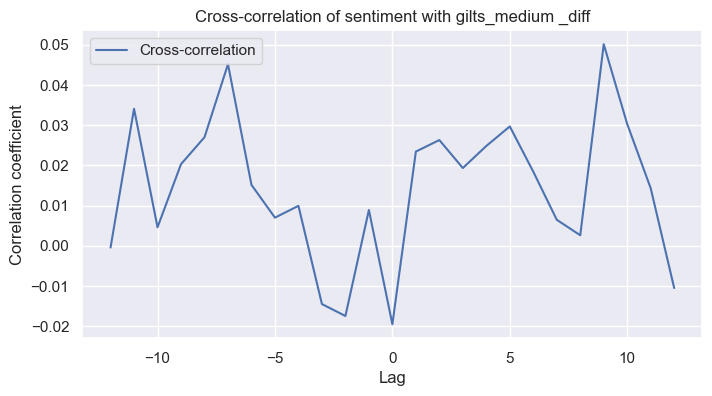


Significant lags for gilts_medium _diff:


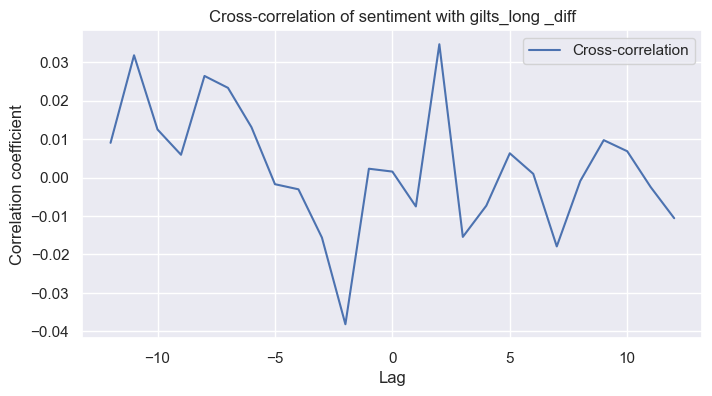


Significant lags for gilts_long _diff:


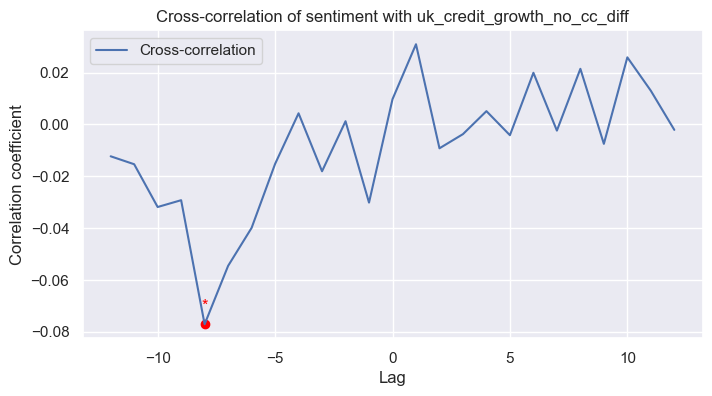


Significant lags for uk_credit_growth_no_cc_diff:
Lag -8: p-value=0.0112, correlation=-0.077


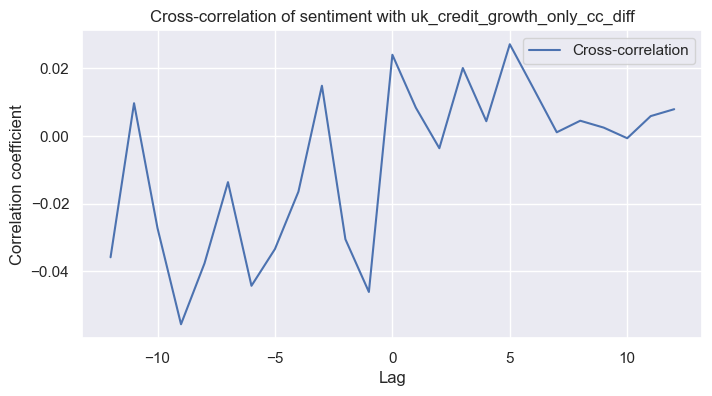


Significant lags for uk_credit_growth_only_cc_diff:


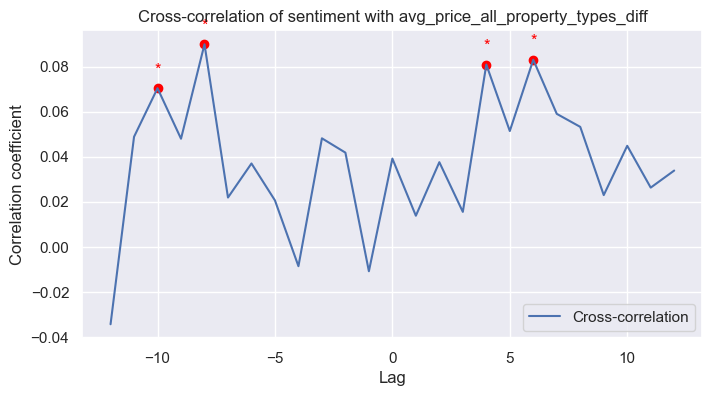


Significant lags for avg_price_all_property_types_diff:
Lag -10: p-value=0.0208, correlation=0.070
Lag -8: p-value=0.0031, correlation=0.090
Lag 4: p-value=0.0078, correlation=0.081
Lag 6: p-value=0.0063, correlation=0.083


In [923]:
for i, var in enumerate(indicators_diff):
    cc = []
    p_values = []

    for lag in lags:
        x = boe_rf_diff['sentiment_lexicon_weighted']
        y = boe_rf_diff[var].shift(lag)

        # Drop NaNs that might be introduced after shift
        valid_idx = x.dropna().index.intersection(y.dropna().index)
        n = len(valid_idx)

        if n > 2:
            x_valid = x.loc[valid_idx]
            y_valid = y.loc[valid_idx]
            r = x_valid.corr(y_valid)
            cc.append(r)
            # Convert r to t-stat and p-value
            t_stat = r * np.sqrt((n - 2) / (1 - r**2))
            p = 2 * (1 - stats.t.cdf(abs(t_stat), df=n - 2))
        else:
            cc.append(np.nan)
            p = np.nan
        p_values.append(p)

    # Plotting the correlation over lags
    plt.figure(figsize=(8, 4))
    plt.plot(lags, cc, label='Cross-correlation')
    for j, p in enumerate(p_values):
        if not np.isnan(p) and p < 0.05:
            plt.scatter(lags[j], cc[j], color='red', marker='o')
            plt.annotate('*', (lags[j], cc[j]), textcoords="offset points", xytext=(0,10), ha='center', color='red')

    plt.title(f'Cross-correlation of sentiment with {var}')
    plt.xlabel('Lag')
    plt.ylabel('Correlation coefficient')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Print significant lags with both p-value and correlation coefficient
    print(f"\nSignificant lags for {var}:")
    for lag_idx, p in enumerate(p_values):
        if not np.isnan(p) and p < 0.05:
            corr_coeff = cc[lag_idx]
            print(f"Lag {lags[lag_idx]}: p-value={p:.4f}, correlation={corr_coeff:.3f}")

In [ ]:
for var in indicators:
    for lag in lags:
        shifted_sentiment = boe_rf_diff['sentiment_lexicon_weighted'].shift(lag)
        
        fig, ax1 = plt.subplots(figsize=(12, 4))
        
        color1 = 'blue'
        color2 = 'orange'

        # Plot indicator on primary axis
        ax1.plot(boe_rf_diff.index, boe_rf_diff[var], color=color1, label='Indicator')
        ax1.set_xlabel('Time')
        ax1.set_ylabel(var, color=color1)
        ax1.tick_params(axis='y', labelcolor=color1)

        # Plot sentiment on secondary axis
        ax2 = ax1.twinx()
        ax2.plot(boe_rf_diff.index, shifted_sentiment, color=color2, label='Sentiment shifted')
        ax2.set_ylabel('Sentiment', color=color2)
        ax2.tick_params(axis='y', labelcolor=color2)

        plt.title(f'{var} with sentiment shifted by {lag}')
        plt.legend(loc='upper left')
        ax1.legend(loc='upper right')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [ ]:
for var in indicators:
    for lag in lags:
        sentiment = boe_rf_diff['sentiment_lexicon_weighted']
        shifted_sentiment = sentiment.shift(lag)
        indicator_series = boe_rf_diff[var]

        # Normalize all three series
        sentiment_norm = (sentiment - sentiment.mean()) / sentiment.std()
        shifted_sentiment_norm = (shifted_sentiment - shifted_sentiment.mean()) / shifted_sentiment.std()
        indicator_norm = (indicator_series - indicator_series.mean()) / indicator_series.std()

        # Plot
        plt.figure(figsize=(12, 4))
        plt.plot(boe_rf_diff.index, indicator_norm, label='Indicator (normalized)', color='blue')
        plt.plot(boe_rf_diff.index, shifted_sentiment_norm, label='Sentiment shifted (normalized)', color='orange')

        plt.title(f'{var} with sentiment shifted by {lag} (normalized)')
        plt.xlabel('Time')
        plt.ylabel('Normalized value')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [ ]:
# Define your window size for smoothing (e.g., 7 periods)
window_size = 7

for var in indicators:
    for lag in lags:
        sentiment = boe_rf_diff['sentiment_lexicon_weighted']
        shifted_sentiment = sentiment.shift(lag)
        indicator_series = boe_rf_diff[var]
        
        # Calculate moving averages
        sentiment_ma = sentiment.rolling(window=window_size, min_periods=1).mean()
        shifted_sent_ma = shifted_sentiment.rolling(window=window_size, min_periods=1).mean()
        indicator_ma = indicator_series.rolling(window=window_size, min_periods=1).mean()
        
        # Plot smoothed series
        plt.figure(figsize=(12, 4))
        plt.plot(boe_rf_diff.index, indicator_ma, label='Indicator (smoothed)', color='blue')
        plt.plot(boe_rf_diff.index, shifted_sent_ma, label='Sentiment shift (smoothed)', color='orange')

        plt.title(f'{var} with sentiment shifted by {lag} (smoothed)')
        plt.xlabel('Time')
        plt.ylabel('Smoothed and normalized value')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [ ]:
# Define your window size for smoothing
window_size = 7

for var in indicators:
    for lag in lags:
        sentiment = boe_rf_diff['sentiment_lexicon_weighted']
        shifted_sentiment = sentiment.shift(lag)
        indicator_series = boe_rf_diff[var]
        
        # Calculate moving averages
        sentiment_ma = sentiment.rolling(window=window_size, min_periods=1).mean()
        shifted_sent_ma = shifted_sentiment.rolling(window=window_size, min_periods=1).mean()
        indicator_ma = indicator_series.rolling(window=window_size, min_periods=1).mean()
        
        # Normalize (standardize) after smoothing
        sentiment_norm = (sentiment_ma - sentiment_ma.mean()) / sentiment_ma.std()
        shifted_sent_norm = (shifted_sent_ma - shifted_sent_ma.mean()) / shifted_sent_ma.std()
        indicator_norm = (indicator_ma - indicator_ma.mean()) / indicator_ma.std()
        
        # Plot normalized and smoothed series
        plt.figure(figsize=(12, 4))
        plt.plot(boe_rf_diff.index, indicator_norm, label='Indicator (smoothed & normalized)', color='blue')
        plt.plot(boe_rf_diff.index, shifted_sent_norm, label='Sentiment shifted (smoothed & normalized)', color='orange')
        
        plt.title(f'{var} with sentiment shifted by {lag} (smoothed & normalized)')
        plt.xlabel('Time')
        plt.ylabel('Normalized & Smoothed Value')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [ ]:
# Filter out Brexit period
start_date = '2016-01-01'
end_date = '2016-12-31'

# Filter the data to this period
period_df = boe_rf_diff.loc[start_date:end_date]

# Then apply your smoothing/normalization and plot
# For example, with smoothing + normalization:
window_size = 7
for var in indicators:
    for lag in lags:
        sentiment = period_df['sentiment_lexicon_weighted']
        shifted_sentiment = sentiment.shift(lag)
        indicator_series = period_df[var]
        
        # Smooth
        sentiment_ma = sentiment.rolling(window=window_size, min_periods=1).mean()
        shifted_sent_ma = shifted_sentiment.rolling(window=window_size, min_periods=1).mean()
        indicator_ma = indicator_series.rolling(window=window_size, min_periods=1).mean()
        
        # Normalize
        sentiment_norm = (sentiment_ma - sentiment_ma.mean()) / sentiment_ma.std()
        shifted_sent_norm = (shifted_sent_ma - shifted_sent_ma.mean()) / shifted_sent_ma.std()
        indicator_norm = (indicator_ma - indicator_ma.mean()) / indicator_ma.std()
        
        # Plot
        plt.figure(figsize=(12, 4))
        plt.plot(period_df.index, indicator_norm, label='Indicator')
        plt.plot(period_df.index, shifted_sent_norm, label='Sentiment shifted')
        plt.title(f'{var} with sentiment shift at lag {lag} (filtered period)')
        plt.legend()
        plt.grid(True)
        plt.show()


In [803]:
# List of target variables to test against sentiment
targets = [
    'uk_consumer_confidence_diff', 'uk_inflation_rate_CPIH_diff', 'uk_unemployment_rate_diff',
    'uk_gdp_growth', 'uk_interest_rate_diff', 'gbp_usd_fx_diff', 'ftse_250_diff',
    'gilts_short _diff', 'gilts_medium _diff', 'gilts_long _diff',
    'uk_credit_growth_no_cc_diff', 'uk_credit_growth_only_cc_diff',
    'avg_price_all_property_types_diff'
]

max_lag = 4  # or whatever lag range you prefer

results_dict = {}

for target in targets:
    # Prepare data: stationarize if needed
    data = boe_rf_diff[[target, 'sentiment_lexicon_weighted']].dropna()
    # Optionally difference if non-stationary
    # data = data.diff().dropna()
    
    print(f"\nTesting if sentiment Granger-causes {target}")
    # Run test
    results = grangercausalitytests(data, maxlag=max_lag, verbose=False)
    # Store or process results
    results_dict[target] = results
    # Optionally, print or interpret results
    for lag in range(1, max_lag+1):
        p_value = results[lag][0]['ssr_ftest'][1]  # or other tests
        print(f"Lag {lag}: p-value = {p_value:.4f}")


Testing if sentiment Granger-causes uk_consumer_confidence_diff
Lag 1: p-value = 0.0661
Lag 2: p-value = 0.1292
Lag 3: p-value = 0.2065
Lag 4: p-value = 0.2818

Testing if sentiment Granger-causes uk_inflation_rate_CPIH_diff
Lag 1: p-value = 0.3355
Lag 2: p-value = 0.3200
Lag 3: p-value = 0.3478
Lag 4: p-value = 0.5285

Testing if sentiment Granger-causes uk_unemployment_rate_diff
Lag 1: p-value = 0.3317
Lag 2: p-value = 0.2413
Lag 3: p-value = 0.1211
Lag 4: p-value = 0.2419

Testing if sentiment Granger-causes uk_gdp_growth
Lag 1: p-value = 0.7878
Lag 2: p-value = 0.8523
Lag 3: p-value = 0.3641
Lag 4: p-value = 0.3794

Testing if sentiment Granger-causes uk_interest_rate_diff
Lag 1: p-value = 0.1736
Lag 2: p-value = 0.2567
Lag 3: p-value = 0.4623
Lag 4: p-value = 0.2915

Testing if sentiment Granger-causes gbp_usd_fx_diff
Lag 1: p-value = 0.7197
Lag 2: p-value = 0.9213
Lag 3: p-value = 0.8026
Lag 4: p-value = 0.2965

Testing if sentiment Granger-causes ftse_250_diff
Lag 1: p-value = 